In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import read_mist_models
from os import listdir
from os.path import isfile, join
import glob
from scipy.interpolate import *
import matplotlib.cm as cm
import math
import scipy.optimize
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib
from joblib import dump,load
import pandas as pd
CMAP = plt.cm.coolwarm

In [2]:
%matplotlib inline

# Data-Handling Functions

In [3]:
def get_mist_data(dir_,verbose=True):
    dir_list = glob.glob(dir_+"\*.eep", recursive=True)
    age, mass, log_L,phase, temp = [],[],[],[],[]
    for file in dir_list:
        eep = read_mist_models.EEP(file,verbose=verbose)
        age.append(eep.eeps['star_age'])
        mass.append(eep.eeps['star_mass'])
        log_L.append(eep.eeps['log_L'])
        phase.append(eep.eeps["phase"])
        temp.append(np.power(10,eep.eeps["log_Teff"]))
    return age, mass, log_L,phase, temp

def get_mist_data2(dir_,verbose=True):
    dir_list = glob.glob(dir_+"\*.eep", recursive=True)
    age, mass, log_L,phase, temp = [],[],[],[],[]
    he_core = []
    for file in dir_list:
        eep = read_mist_models.EEP(file,verbose=verbose)
        age.append(eep.eeps['star_age'])
        mass.append(eep.eeps['star_mass'])
        log_L.append(eep.eeps['log_L'])
        phase.append(eep.eeps["phase"])
        temp.append(np.power(10,eep.eeps["log_Teff"]))
        he_core.append(eep.eeps["he_core_mass"])
    return age, mass, log_L,phase, temp, he_core

def flatten(arr):
    new_arr = []
    for m in arr:
        new_arr.extend(list(m))
    return new_arr


def monotonic_indices(arr):
    mon_arr = [[]]
    for x in range(len(arr)-1):
        if(arr[x+1] > arr[x]):
            mon_arr[-1].append(x)
        else: mon_arr.append([x])
    max_ind = 0
    max_size = 0
    for i in range(len(mon_arr)):
        if(np.size(mon_arr[i]) > max_size):
            max_size = np.size(mon_arr[i])
            max_ind = i
    return mon_arr[max_ind]


def clean_data(age_full, mass_full, log_L_full,phase_full, T_full):
    
    phase_full
    mass_clean, log_L_clean,age_clean,T_clean=[],[],[],[]
    for m_list, l_list, a_list,phase,temp in zip(mass_full, log_L_full, age_full,phase_full,T_full):
        phase=np.array(phase)
        clean_indices = np.where((np.array(phase)<max(PHASE_RANGE)) & (np.array(phase) > min(PHASE_RANGE)))
        #clean_indices = monotonic_indices(l_list)

        mass_clean.append(np.array(m_list)[clean_indices]), log_L_clean.append(np.array(l_list)[clean_indices]), age_clean.append(np.array(a_list)[clean_indices]),T_clean.append(np.array(temp)[clean_indices])
    return age_clean, mass_clean, log_L_clean,T_clean

def get_MIST_tracks_and_feh(feh_range):
    all_tracks = np.sort(glob.glob("MIST_high_res/*"))
    all_tracks = np.concatenate((all_tracks[-3:][::-1],all_tracks[0:-3]))
    filtered_tracks = []
    feh = []
    for track in all_tracks:
        s = (track.split("feh_")[-1]).split("_")[0]
        sign = s[0]
        if(sign == "p"): sign = 1
        else: sign = -1
        feh_val = float(s[1:])*sign
        if(is_in(feh_val, feh_range)):
            feh.append(feh_val)
            filtered_tracks.append(track)
    return filtered_tracks, feh



def get_all_MIST_data(all_tracks, clean=True, verbose=True):
    all_ages, all_mass, all_L,all_T, all_ages_full, all_mass_full, all_L_full,all_phases_full, all_T_full = [],[],[],[],[],[],[],[],[]
    for i,tracks in enumerate(all_tracks):
        age_full, mass_full, log_L_full,phase_full, T_full,  = get_mist_data(tracks,verbose=verbose)
        all_mass_full.append(mass_full)
        all_ages_full.append(age_full)
        all_L_full.append(log_L_full)
        all_phases_full.append(phase_full)
        all_T_full.append(T_full)
        if(clean):
            age, mass, log_L,temp = clean_data(age_full, mass_full, log_L_full,phase_full, T_full)
            all_ages.append(age), all_mass.append(mass), all_L.append(log_L), all_T.append(temp)
        else:
            all_ages.append(age_full), all_mass.append(mass_full), all_L.append(log_L_full), all_T.append(all_T_full)

    return all_ages, all_mass, all_L,all_T, all_ages_full, all_mass_full, all_L_full,all_phases_full,all_T_full


def get_all_MIST_data2(all_tracks, clean=True, verbose=True):
    all_ages, all_mass, all_L,all_T, all_ages_full, all_mass_full, all_L_full,all_phases_full, all_T_full = [],[],[],[],[],[],[],[],[]
    all_he=[]
    for i,tracks in enumerate(all_tracks):
        age_full, mass_full, log_L_full,phase_full, T_full, he_full = get_mist_data2(tracks,verbose=verbose)
        all_mass_full.append(mass_full)
        all_ages_full.append(age_full)
        all_L_full.append(log_L_full)
        all_phases_full.append(phase_full)
        all_T_full.append(T_full)
        if(clean):
            age, mass, log_L,temp = clean_data(age_full, mass_full, log_L_full,phase_full, T_full)
            all_ages.append(age), all_mass.append(mass), all_L.append(log_L), all_T.append(temp)
        else:
            all_ages.append(age_full), all_mass.append(mass_full), all_L.append(log_L_full), all_T.append(all_T_full), all_he.append(he_full)

    return all_ages, all_mass, all_L,all_T, all_ages_full, all_mass_full, all_L_full,all_phases_full,all_T_full,all_he

# Analysis Functions

In [4]:


def is_in(x_eval, x_list):
    return ((np.any(np.array(x_list) <= x_eval)) and (np.any(np.array(x_list) >= x_eval)))

def interp_1d(x,y,x_eval, interp_type):
    y_out =[]
    for x_list, y_list in  zip(x, y):        
        if(is_in(x_eval, x_list)):
            y_out.append(interp1d(x_list,y_list, kind=interp_type)(x_eval))
    return np.array(y_out)



def get_l_stables(age, mass,temp, log_L, a_start, m_eval, isoirr):
    
    m_interp = interp_1d(age, mass, a_start, "linear")
    l_interp = interp_1d(age, log_L, a_start, "linear")
    t_interp = interp_1d(age, temp, a_start, "linear")
    m_eval_temp = m_eval[np.where(m_eval <= np.max(m_interp))]
    try:
        l_stables = interp1d(m_interp,l_interp, kind="linear")(m_eval_temp)
        if(isoirr): 
# #             print("YEP")
# #             print(np.power(10,l_stables)*np.power(m_eval_temp,2))
# #             print(l_stables, m_eval_temp)
#             f_0 = np.power(10,l_stables)*np.power(m_eval_temp,2)
#             t_stable = interp1d(m_interp,t_interp, kind="linear")(m_eval_temp)
#             #print(len(mass), len(temp))
#             #print(mass, temp)
#             return calc_f_ir(t_stable,f_0)
            return np.power(10,l_stables)*np.power(m_eval_temp,2)

        else: return l_stables
    except Exception as e:
        print("Error in get_l_stables", e)
        print(m_interp, l_interp, m_eval)
        return []
        

def exp(x, a,b,c):
    return a * np.exp(-b * x) + c

def pow_law(x, a,b,c,base):
    return a * np.power(base,-b * x) + c

def exp_der(x, a,b,c):
    return -b*a * np.exp(-b * x)



def chi_sq(data,fit):
    return np.sum(np.power(fit-data,2)/fit)

def residual(data,fit):
    return np.sum(np.power(fit-data,2))


def find_gaps(m_interp, a_interp):
    m,a = [m_interp[0]],[a_interp[0]]
    for x in range(len(m_interp)-1):
        if(np.abs(m_interp[x+1]-m_interp[x]) > 0.05): return np.array(m),np.array(a)
        m.append(m_interp[x+1])
        a.append(a_interp[x+1])
    return np.array(m),np.array(a)
        
    


def get_fits(age, mass,temp, log_L,l_stables,a_start,isoirr, SIGMA=False,poly=False):
    a,m,fit,indices = [],[],[],[]
    poly_fits = []
    for i,l_stable in enumerate(l_stables): 
    
        if(isoirr):
            interp_over = []
            for x in range(len(mass)):
#                 f_0 = np.array(np.power(10,log_L[x])*np.power(mass[x],2))
#                 interp_over.append(calc_f_ir(temp[x],f_0))
                interp_over.append(np.power(10,log_L[x])*np.power(mass[x],2))
            m_interp = interp_1d(interp_over,mass, l_stable, "linear")[::-1]
            a_interp = interp_1d(interp_over,age, l_stable, "linear")[::-1]
        else:
            m_interp = interp_1d(log_L,mass, l_stable, "linear")[::-1]
            a_interp = interp_1d(log_L,age, l_stable, "linear")[::-1]
        m_interp, a_interp = find_gaps(m_interp, a_interp)

        inds = np.where(a_interp > a_start)
        m_interp = m_interp[inds]
        a_interp = a_interp[inds]
        if(len(m_interp)<2):  continue
        indices.append(i)

        m.append(m_interp)
        a.append(a_interp)
        
        if(poly):
            fit.append(np.polyfit(a_interp,m_interp,DEGREE_OF_FIT))
        else:

            try:
                p0 = (m_interp[0]-m_interp[-1],2/(np.abs(a_interp[0] - a_interp[-1])),m_interp[-1])

                if(SIGMA):
                    if(np.max(a_interp) < 80e9):
                        one_over_dif =np.abs(1/np.power((a_interp[1:] -a_interp[:-1]),1))
                        sigma=np.insert(one_over_dif,0,np.min(one_over_dif))   #np.array([1/((n+1)*(n+1)) for n in range(len(a_interp))])
                        sigma=np.sqrt(sigma)
                        params, cv = scipy.optimize.curve_fit(exp, a_interp, m_interp, p0, sigma=sigma)
                    else:
                        params, cv = scipy.optimize.curve_fit(exp, a_interp, m_interp, p0)
                else:
                    params, cv = scipy.optimize.curve_fit(exp, a_interp, m_interp, p0)

                fit.append(params)

            except Exception as e:
                print(e)
                print("Failed to fit exponential. age, mass:", list(a_interp), list(m_interp))
                fit.append((0,1,0))
    return a,m,fit,indices


def get_m_vs_a(all_ages, all_mass, all_temps,all_L,feh, m_eval,a_start, isoirr=True, poly=False):
    all_l_stables, all_a, all_m, all_fits,all_indices = [],[],[],[],[]
    for age,mass,temp,log_L,i, met in zip(all_ages, all_mass, all_temps,all_L, range(len(all_ages)), feh):

        l_stables = get_l_stables(age, mass,temp, log_L, a_start, m_eval, isoirr)
        if(len(l_stables) > 0):
            a,m,fit, indices = get_fits(age, mass, temp,log_L,l_stables,a_start,isoirr,SIGMA=True,poly=poly)
            all_l_stables.append(l_stables)
            all_a.append(a)
            all_m.append(m)
            all_indices.append(indices)
            all_fits.append(fit)

    return all_l_stables, all_a, all_m, all_fits,all_indices





# def calc_f_eff(temp_list,f_0):
# #     #return radius instead, use this in mr^2 calc of angular momen
    
# #     seff_sol=1.0140
# #     a,b,c,d = 8.1774e-5, 1.7063e-9,-4.3241e-12,-6.6462e-16
# #     T=(np.array(temp_list)-5780)*1.0
# #     seff = seff_sol+a*T+b*np.power(T,2)+c*np.power(T,3)+d*np.power(T,4)
# #     d = np.sqrt(lum/seff)
    
    
    
#     #moist greenhouse:
#     seff=1.0140
#     a,b,c,d = 8.1774e-5, 1.7063e-9,-4.3241e-12,-6.6462e-16
#     T=(np.array(temp_list)-5780)*1.0
#     return f_0+a*T+b*np.power(T,2)+c*np.power(T,3)+d*np.power(T,4)
    
    
    
    

# def calc_f_ir(temp_list,f_list):
#     #moist greenhouse:
#     seff=1.0140
#     a,b,c,d = 8.1774e-5, 1.7063e-9,-4.3241e-12,-6.6462e-16
#     T=(np.array(temp_list)-5780)*1.0
#     return f_list*(seff+a*T+b*np.power(T,2)+c*np.power(T,3)+d*np.power(T,4))
        


# Generating Mass vs age for several metallicities

In [5]:
PHASE_RANGE = [-0.1, 0.1]
all_tracks, feh = get_MIST_tracks_and_feh(feh_range=[-4.6,0.6])
#all_tracks, feh = get_MIST_tracks_and_feh(feh_range=[-0.1,0.1])
all_ages, all_mass, all_L,all_T, all_ages_full, all_mass_full, all_L_full,all_phases_full, all_T_full = get_all_MIST_data(all_tracks, clean=True,verbose=False)

In [7]:
ISOIRR = True #If true, holds flux constant. If False, holds L constant
POLY=True
a_sol = 4.603e9
m_sol = 1.98847e30
m_ceres = 9.1e20
a_start = 2e9 #the age when starlifting starts
m_eval = np.arange(0.15,1.4,0.01)
DEGREE_OF_FIT = 3

In [7]:
all_l_stables, all_a, all_m, all_fits,all_indices = get_m_vs_a(all_ages, all_mass, all_T,all_L,feh,m_eval,a_start,isoirr=ISOIRR,poly=POLY)

C:\Users\Matthew\AppData\Local\Temp/ipykernel_5232/2482139245.py:128: RankWarning: Polyfit may be poorly conditioned
  a,m,fit, indices = get_fits(age, mass, temp,log_L,l_stables,a_start,isoirr,SIGMA=True,poly=poly)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_5232/2482139245.py:128: RankWarning: Polyfit may be poorly conditioned
  a,m,fit, indices = get_fits(age, mass, temp,log_L,l_stables,a_start,isoirr,SIGMA=True,poly=poly)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_5232/2482139245.py:128: RankWarning: Polyfit may be poorly conditioned
  a,m,fit, indices = get_fits(age, mass, temp,log_L,l_stables,a_start,isoirr,SIGMA=True,poly=poly)


# Plotting

In [8]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', size=16)    # fontsize of the x and y labels

### Checking the fits for a range of feh and initial mass

0.5


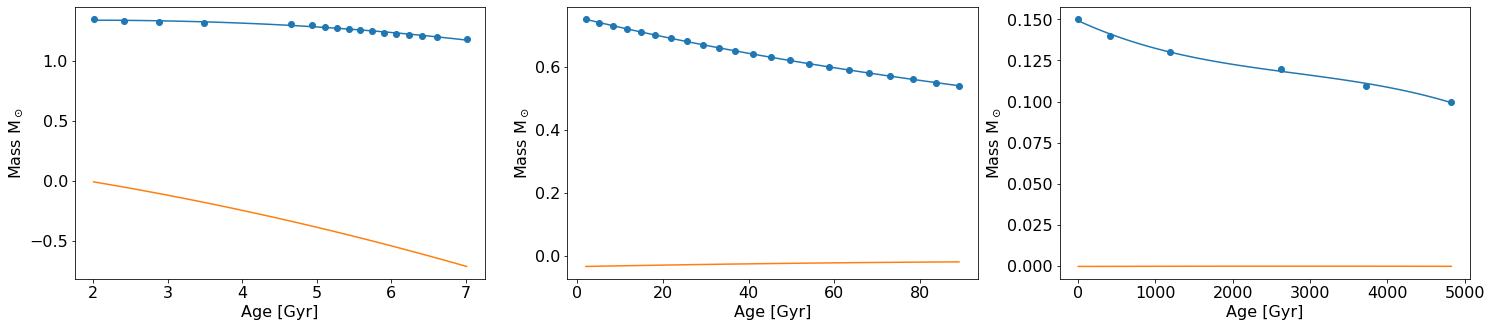

0.0


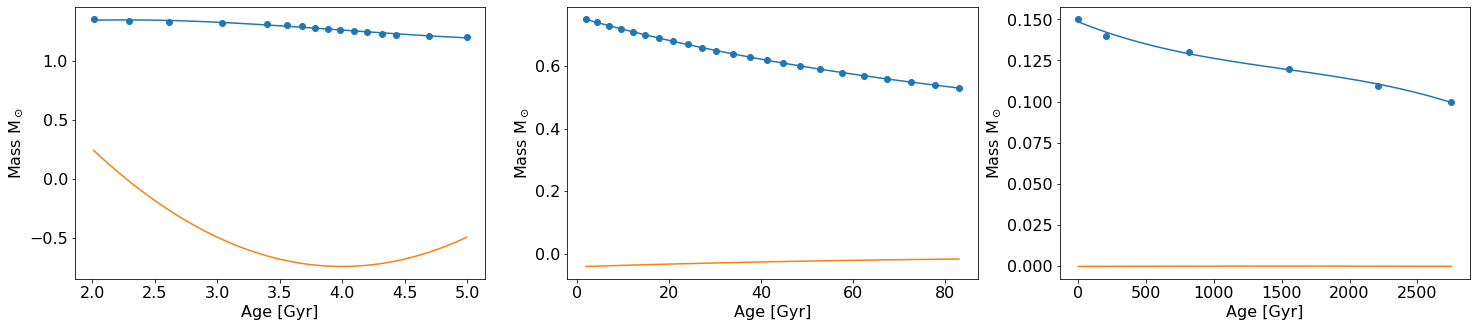

-4.0


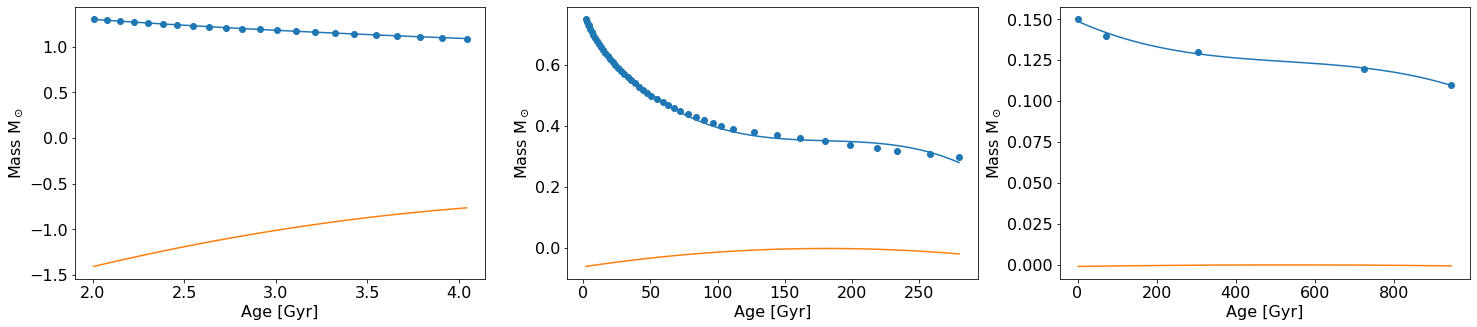

-1.0


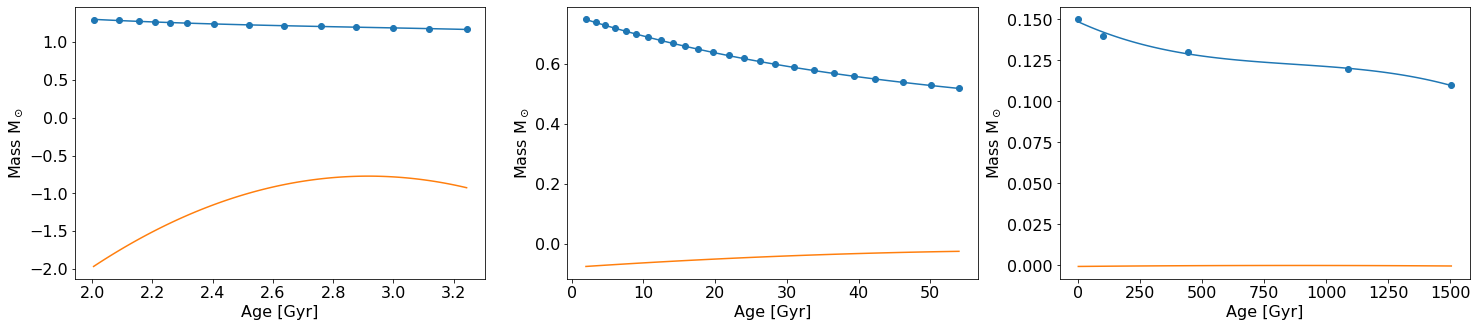

-2.0


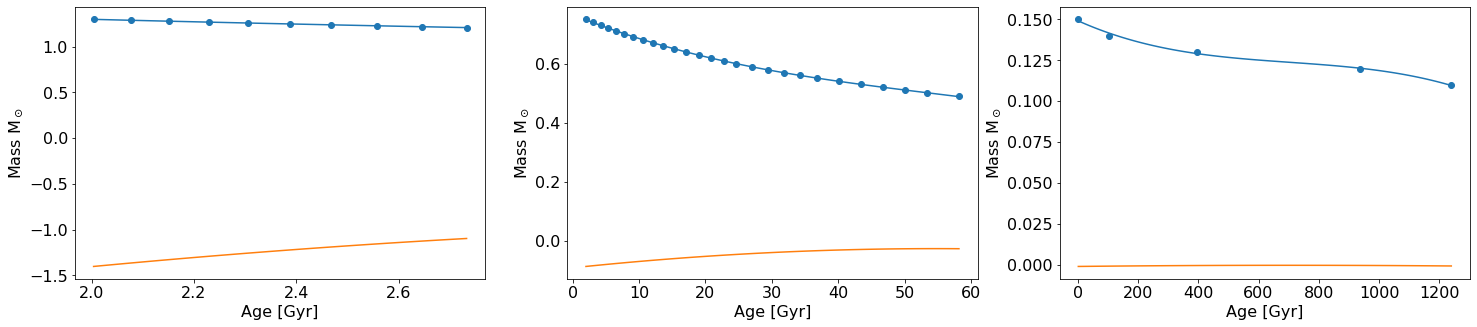

-3.0


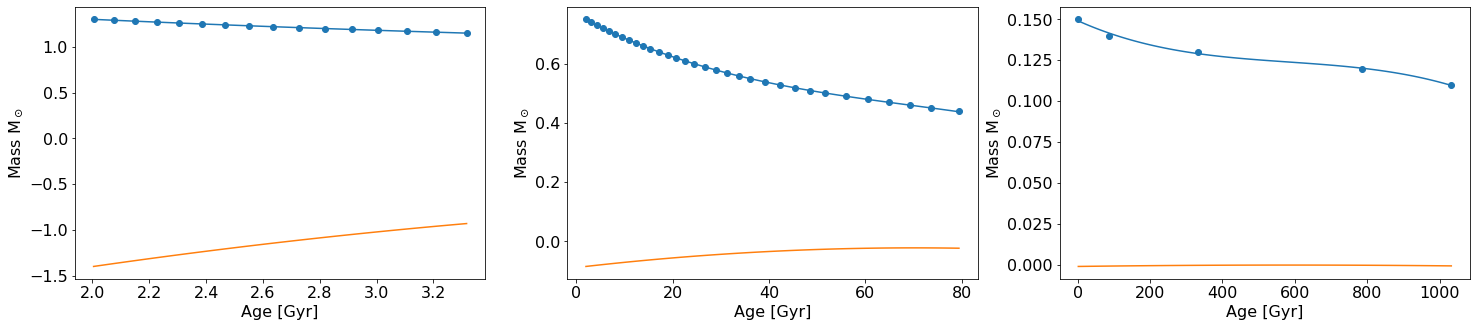

In [101]:
for x in range(len(feh)):
    f = feh[x]
    print(f)
    fig, axs = plt.subplots(1,3, figsize=(25,5))
    indices = [-1, int(len(all_m[x])/2), 0]

    for y in range(3):
        axs[y].set_xlabel("Age [Gyr]")
        axs[y].set_ylabel(r"Mass ${\rm M}_\odot$")
        axs[y].scatter(all_a[x][indices[y]]/1e9, all_m[x][indices[y]])
        pts = np.linspace(all_a[x][indices[y]][0],all_a[x][indices[y]][-1], 100)
        axs[y].plot(pts/1e9, np.poly1d(all_fits[x][indices[y]])(pts))
        
        
        axs[y].plot(pts/1e9, np.polyder(np.poly1d(all_fits[x][indices[y]]))(pts)*10000000000)
    #plt.savefig("figures/fit_checks/feh_"+str(feh[x])+".pdf")
    plt.show()    

### animation for the video

In [88]:
plt.rc('font', size=24)    # fontsize of the x and y labels
isoirr =False

a_start = a_sol #the age when starlifting starts
m_eval = np.arange(1.0,1.01,0.05)
all_l_stables, all_a, all_m, all_fits,all_indices = get_m_vs_a(all_ages, all_mass, all_T,all_L,feh,m_eval,a_start,isoirr=isoirr,poly=POLY)
a_sun, m_sun, fit_sun, l_stable_sun = all_a[1][0], all_m[1][0], all_fits[1][0], all_l_stables[1][0]
pts = np.linspace(a_sun[0],a_sun[-1], 100)



i=1
m_min, m_max = 0.95*m_sun[-1], 1.011*m_sun[0]
vmax, vmin = 0,0

for mass, log_l in zip(all_mass[i], all_L[i]):
    if(mass[0] > m_max or mass[0] < m_min): continue
    else: 
        vmax = max(vmax, np.max(log_l))
        vmin = min(vmin, np.min(log_l))
scatter_col = np.linspace(l_stable_sun,l_stable_sun,len(m_sun))

C:\Users\Matthew\AppData\Local\Temp/ipykernel_49016/3824431297.py:4: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(c,label=r"${\rm log}_{10}(L/{\rm L}_\odot)$",orientation="horizontal", pad=0.07)


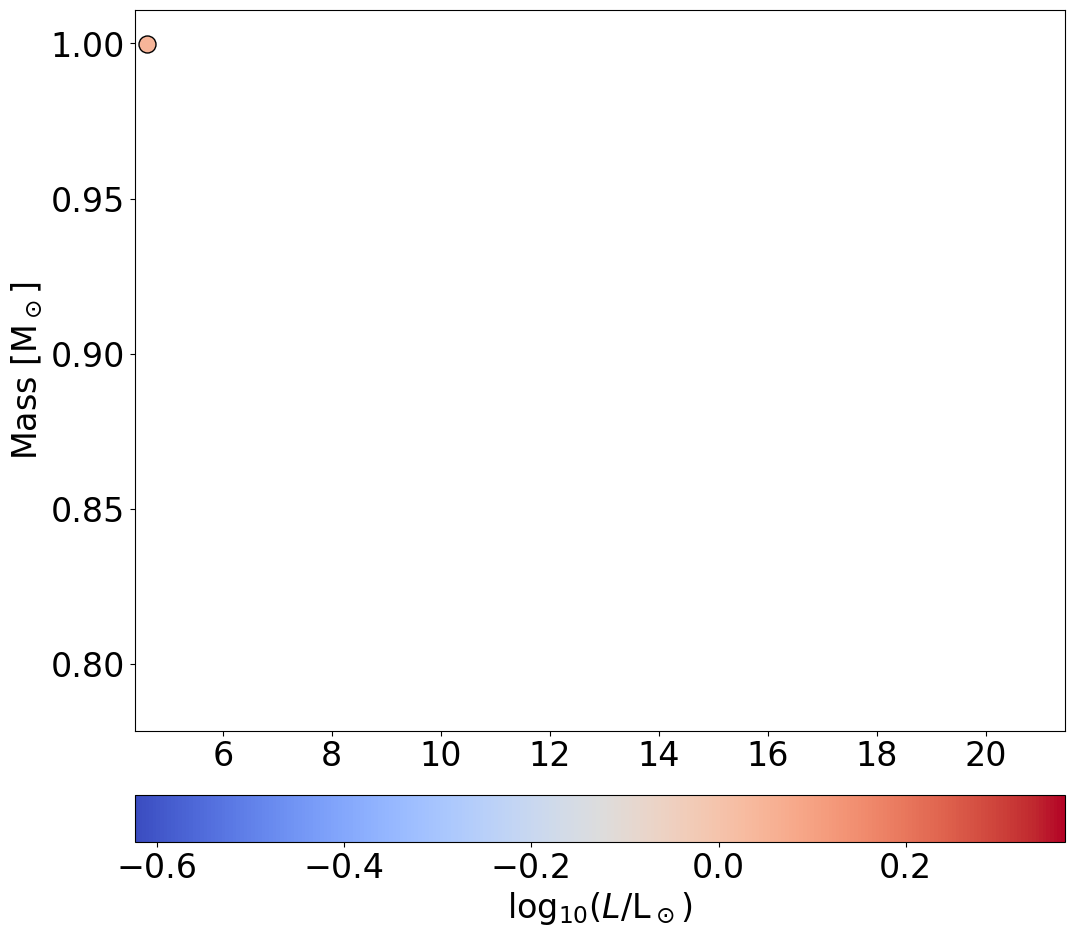

In [38]:
fig = plt.figure(figsize=(12,12))
plt.scatter(a_sun[0]/1e9, m_sun[0], label="Lazarus Sun", cmap=CMAP, c=scatter_col[0],s=150,edgecolors='black', vmin=vmin, vmax=vmax)

plt.colorbar(c,label=r"${\rm log}_{10}(L/{\rm L}_\odot)$",orientation="horizontal", pad=0.07)
plt.ylabel(r"Mass [${\rm M}_\odot$]")
plt.xlim(0.95*a_sun[0]/1e9,1.05*a_sun[-1]/1e9)
plt.ylim(m_min, m_max)   
plt.savefig("video_figures/pt1.pdf")
plt.savefig("video_figures/pt1.jpg")
plt.show()

C:\Users\Matthew\AppData\Local\Temp/ipykernel_49016/1239719069.py:7: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(c,label=r"${\rm log}_{10}(L/{\rm L}_\odot)$",orientation="horizontal", pad=0.07)


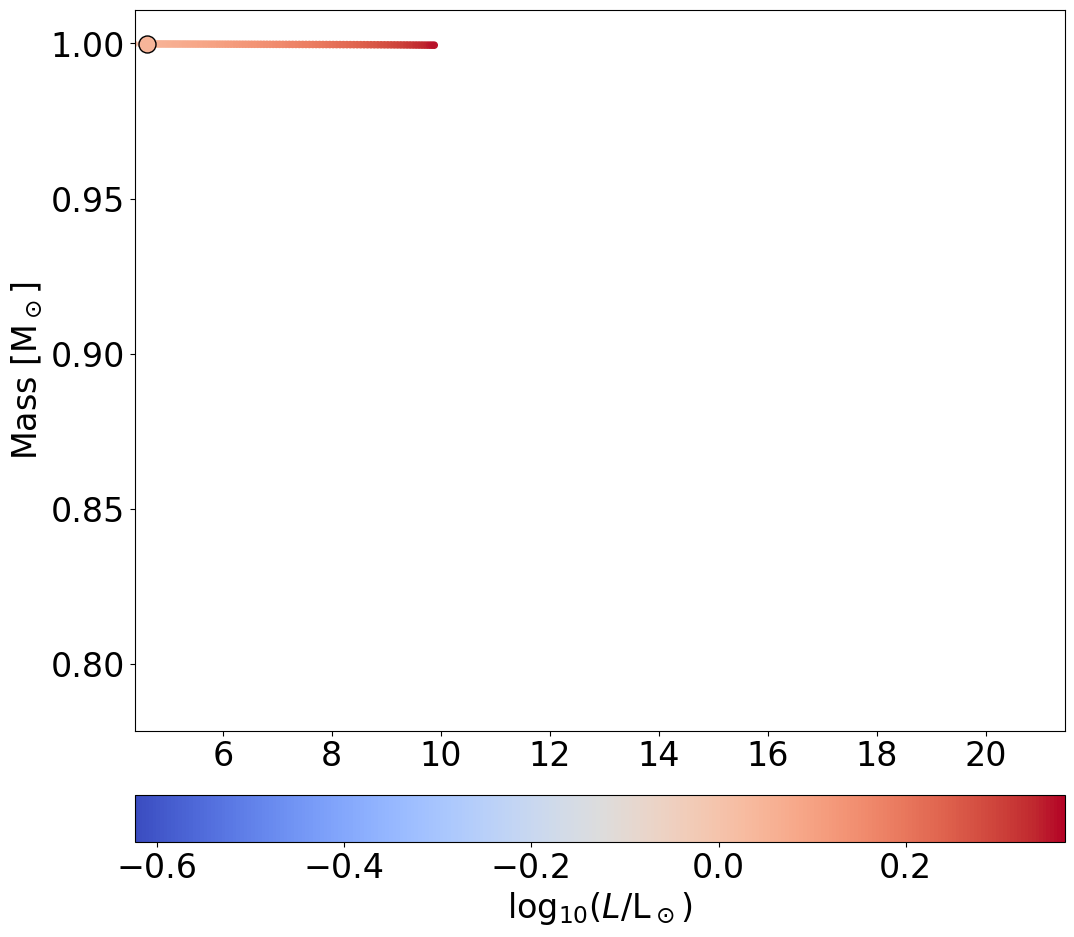

In [40]:
fig = plt.figure(figsize=(12,12))
sun_index=90
col = all_L[i][sun_index]
plt.scatter(all_ages[i][sun_index]/1e9,all_mass[i][sun_index], cmap=CMAP, c=col,s=20, vmin=vmin, vmax=vmax)  
plt.scatter(a_sun[0]/1e9, m_sun[0], label="Lazarus Sun", cmap=CMAP, c=scatter_col[0],s=150,edgecolors='black', vmin=vmin, vmax=vmax)

plt.colorbar(c,label=r"${\rm log}_{10}(L/{\rm L}_\odot)$",orientation="horizontal", pad=0.07)
plt.ylabel(r"Mass [${\rm M}_\odot$]")
plt.xlim(0.95*a_sun[0]/1e9,1.05*a_sun[-1]/1e9)
plt.ylim(m_min, m_max)   
plt.savefig("video_figures/pt2.pdf")
plt.savefig("video_figures/pt2.jpg")
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,12))
sun_index=90
col = all_L[i][sun_index]
plt.scatter(all_ages[i][sun_index]/1e9,all_mass[i][sun_index], cmap=CMAP, c=col,s=20, vmin=vmin, vmax=vmax)  
plt.scatter(a_sun[0]/1e9, m_sun[0], label="Lazarus Sun", cmap=CMAP, c=scatter_col[0],s=150,edgecolors='black', vmin=vmin, vmax=vmax)

plt.colorbar(c,label=r"${\rm log}_{10}(L/{\rm L}_\odot)$",orientation="horizontal", pad=0.07)
plt.ylabel(r"Mass [${\rm M}_\odot$]")
plt.xlim(0.95*a_sun[0]/1e9,1.05*a_sun[-1]/1e9)
plt.ylim(m_min, m_max)   
plt.savefig("video_figures/pt2.pdf")
plt.savefig("video_figures/pt2.jpg")
plt.show()

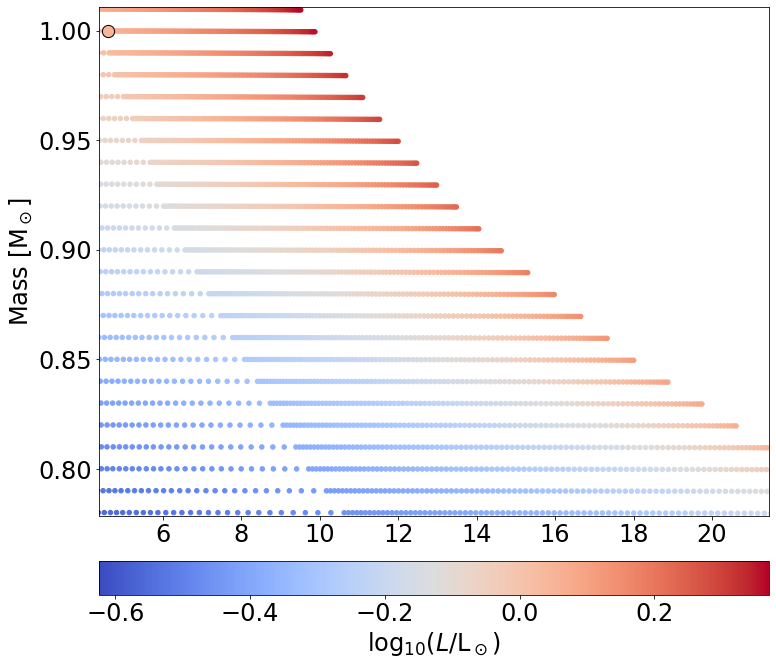

In [9]:
fig = plt.figure(figsize=(12,12))
for mass,age,log_l,temp in zip(all_mass[i], all_ages[i], all_L[i], all_T[i]):
    if(mass[0] > m_max or mass[0] < m_min): continue

    col = log_l
    c = plt.scatter(age/1e9,mass, cmap=CMAP, c=col,s=20, vmin=vmin, vmax=vmax)  
plt.scatter(a_sun[0]/1e9, m_sun[0], label="Lazarus Sun", cmap=CMAP, c=scatter_col[0],s=150,edgecolors='black', vmin=vmin, vmax=vmax)

plt.colorbar(c,label=r"${\rm log}_{10}(L/{\rm L}_\odot)$",orientation="horizontal", pad=0.07)
plt.ylabel(r"Mass [${\rm M}_\odot$]")
plt.xlim(0.95*a_sun[0]/1e9,1.05*a_sun[-1]/1e9)
plt.ylim(m_min, m_max)   
# plt.savefig("video_figures/pt3.pdf")
# plt.savefig("video_figures/pt3.jpg")
plt.show()

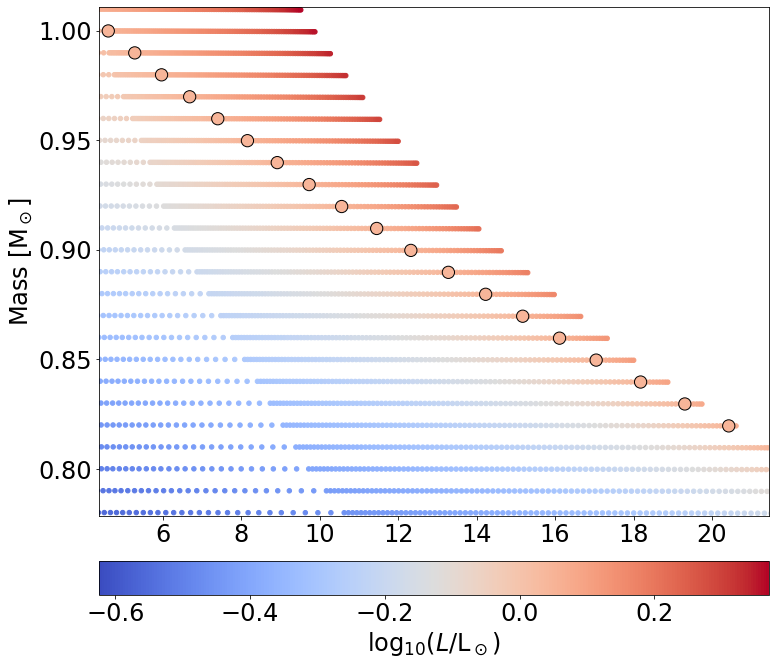

In [10]:
fig = plt.figure(figsize=(12,12))
for mass,age,log_l,temp in zip(all_mass[i], all_ages[i], all_L[i], all_T[i]):
    if(mass[0] > m_max or mass[0] < m_min): continue

    col = log_l
    c = plt.scatter(age/1e9,mass, cmap=CMAP, c=col,s=20, vmin=vmin, vmax=vmax)  
plt.scatter(a_sun/1e9, m_sun, label="Lazarus Sun", cmap=CMAP, c=scatter_col,s=150,edgecolors='black', vmin=vmin, vmax=vmax)

plt.colorbar(c,label=r"${\rm log}_{10}(L/{\rm L}_\odot)$",orientation="horizontal", pad=0.07)
plt.ylabel(r"Mass [${\rm M}_\odot$]")
plt.xlim(0.95*a_sun[0]/1e9,1.05*a_sun[-1]/1e9)
plt.ylim(m_min, m_max)   
# plt.savefig("video_figures/pt4.pdf")
# plt.savefig("video_figures/pt4.jpg")
plt.show()

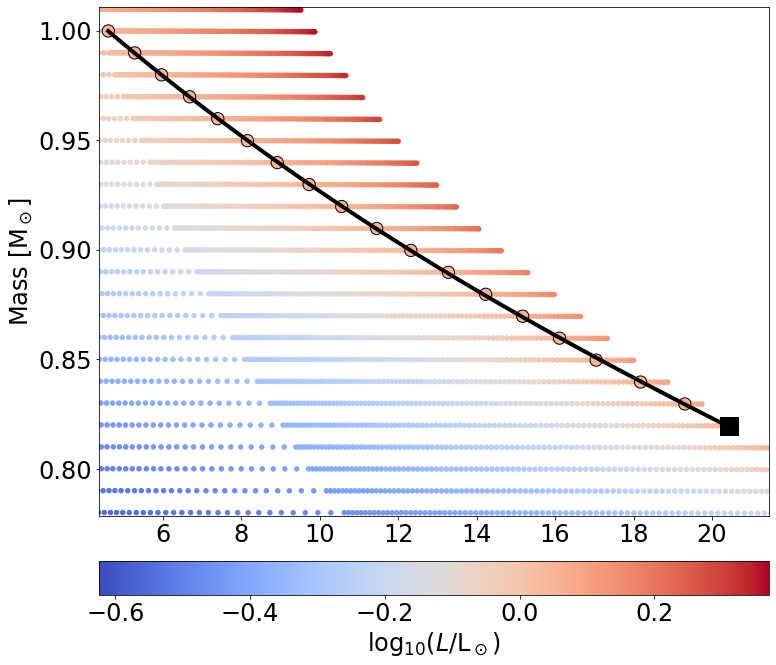

In [89]:
fig = plt.figure(figsize=(12,12))
for mass,age,log_l,temp in zip(all_mass[i], all_ages[i], all_L[i], all_T[i]):
    if(mass[0] > m_max or mass[0] < m_min): continue

    col = log_l
    c = plt.scatter(age/1e9,mass, cmap=CMAP, c=col,s=20, vmin=vmin, vmax=vmax) 
plt.plot(pts/1e9, np.poly1d(fit_sun)(pts), label="Fit",color="black",lw=4)

plt.scatter(a_sun/1e9, m_sun, label="Lazarus Sun", cmap=CMAP, c=scatter_col,s=150,edgecolors='black', vmin=vmin, vmax=vmax)
plt.scatter(a_sun[-1]/1e9, m_sun[-1], label="Terminal Sun", c="black",s=300,marker="s")

plt.colorbar(c,label=r"${\rm log}_{10}(L/{\rm L}_\odot)$",orientation="horizontal", pad=0.07)
plt.ylabel(r"Mass [${\rm M}_\odot$]")
plt.xlim(0.95*a_sun[0]/1e9,1.05*a_sun[-1]/1e9)
plt.ylim(m_min, m_max)   
# plt.savefig("video_figures/pt5.pdf")
# plt.savefig("video_figures/pt5.jpg")
plt.show()

# Comparing our derived m vs a to MESA

In [86]:
lc = 0
age, mass, logl = [],[],[]
for line in open("export_data/output_sun.txt"):
    lc+=1
    if(lc<45):continue
    if line in ['\n', '\r\n']: continue
    if((line.split()[0]).isnumeric()):
        newline = line
        linereset=False
    elif("E" in (line.split()[0])):
        newline += line
    else: linereset = True
    if(linereset): 
        splitline = newline.split()
        age1 = float(splitline[25])
        if(age1 < 1e6): continue
        mass.append(float(splitline[5]))
        age.append(age1)
        logl.append(float(splitline[27]))
lc = 0       
for line in open("export_data/output_SL.txt"):
    lc+=1
    if(lc<45):continue
    if line in ['\n', '\r\n']: continue
    if((line.split()[0]).isnumeric()):
        newline = line
        linereset=False
    elif("E" in (line.split()[0])):
        newline += line
    else: linereset = True
    if(linereset): 
        splitline = newline.split()
        age1 = float(splitline[25])
        if(age1 < 1e6): continue
        mass.append(float(splitline[5]))
        age.append(age1)
        logl.append(float(splitline[27]))
mesa_mass, mesa_age, mesa_l = mass,age,logl

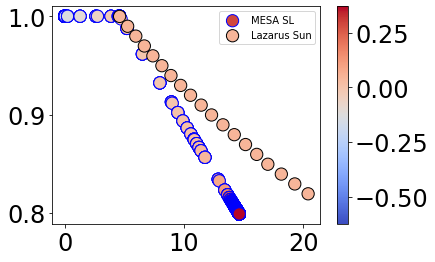

In [102]:
plt.scatter(np.array(mesa_age)/1e9,mesa_mass,label="MESA SL", cmap=CMAP,edgecolors='blue',c=mesa_l,s=150, vmin=vmin, vmax=vmax)
plt.scatter(a_sun/1e9, m_sun, label="Lazarus Sun", cmap=CMAP, c=scatter_col,s=150,edgecolors='black', vmin=vmin, vmax=vmax)
plt.legend(fontsize=10)
plt.colorbar()
plt.savefig("MESA_comp.pdf")

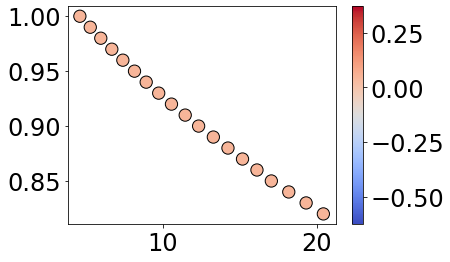

In [93]:
plt.colorbar()

### Worked example for a sun-like star

C:\Users\Matthew\AppData\Local\Temp/ipykernel_11008/43606658.py:54: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  if(isoirr):fig.colorbar(c, label=r"${\rm log}_{10}(\mathcal{F}/\mathcal{F}_\odot)$",orientation="horizontal", pad=0.25)


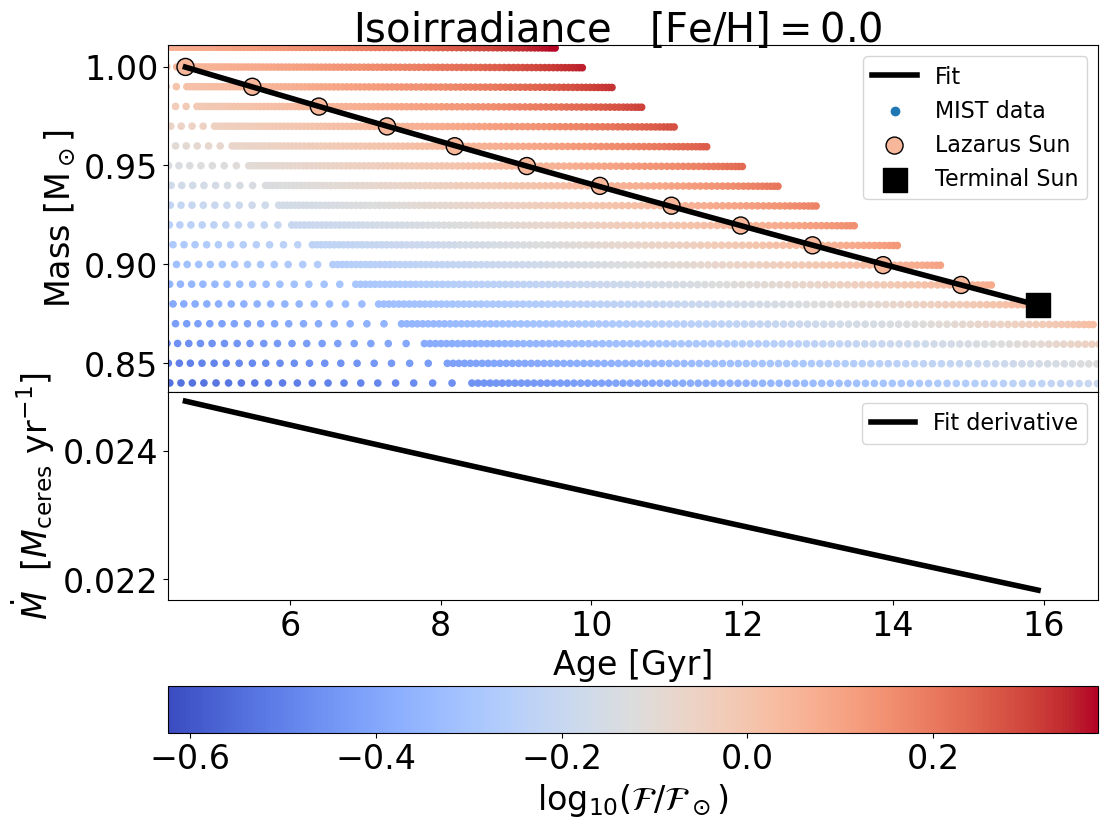

C:\Users\Matthew\AppData\Local\Temp/ipykernel_11008/43606658.py:55: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  else: plt.colorbar(c,label=r"${\rm log}_{10}(L/{\rm L}_\odot)$",orientation="horizontal", pad=0.25)


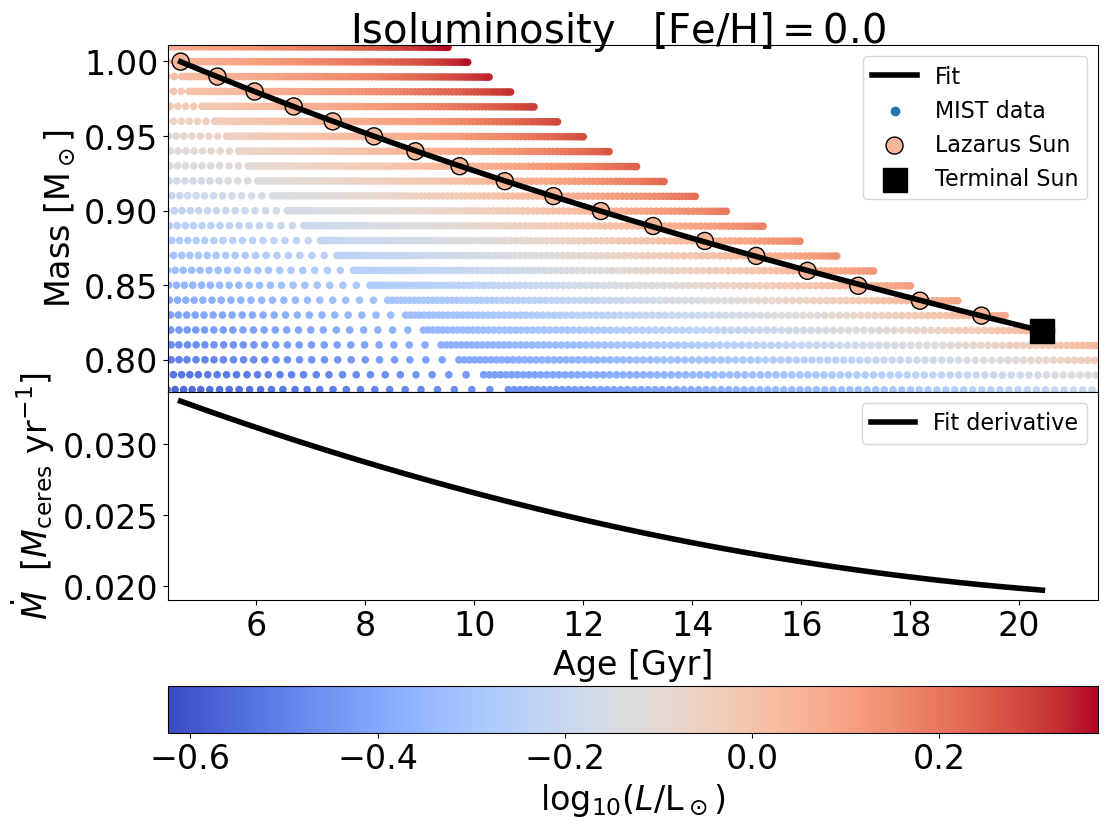

In [20]:
plt.rc('font', size=24)    # fontsize of the x and y labels
for isoirr in [True,False]:

    a_start = a_sol #the age when starlifting starts
    m_eval = np.arange(1.0,1.01,0.05)
    all_l_stables, all_a, all_m, all_fits,all_indices = get_m_vs_a(all_ages, all_mass, all_T,all_L,feh,m_eval,a_start,isoirr=isoirr,poly=POLY)
    a_sun, m_sun, fit_sun, l_stable_sun = all_a[1][0], all_m[1][0], all_fits[1][0], all_l_stables[1][0]
    pts = np.linspace(a_sun[0],a_sun[-1], 100)

    
    
    i=1
    m_min, m_max = 0.95*m_sun[-1], 1.011*m_sun[0]

    fig, axs = plt.subplots(2,1, figsize=(12,9),sharex=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    vmax, vmin = 0,0
    
    if(isoirr):
        for mass,age,log_l,temp in zip(all_mass[i], all_ages[i], all_L[i], all_T[i]):
            if(mass[0] > m_max or mass[0] < m_min): continue
            else: 
                vmax = max(vmax, np.max(np.log10(np.power(10,log_l)*np.power(mass,2))))
                vmin = min(vmin, np.min(np.log10(np.power(10,log_l)*np.power(mass,2))))
    else:
        for mass, log_l in zip(all_mass[i], all_L[i]):
            if(mass[0] > m_max or mass[0] < m_min): continue
            else: 
                vmax = max(vmax, np.max(log_l))
                vmin = min(vmin, np.min(log_l))
                


    if(isoirr): scatter_col =  np.log10(np.linspace(l_stable_sun,l_stable_sun,len(m_sun)))
    else: scatter_col = np.linspace(l_stable_sun,l_stable_sun,len(m_sun))
        
    if(isoirr): txt_str = "Isoirradiance   "+r"[Fe/H]${=}$"+str(feh[i])
    else: txt_str = "Isoluminosity   "+r"[Fe/H]${=}$"+str(feh[i])    
    plt.suptitle(txt_str, y=0.92)
        

    

    #plt.text(2.5, 1.9, txt_str, horizontalalignment='right',verticalalignment='top', transform=ax.transAxes)


    for mass,age,log_l,temp in zip(all_mass[i], all_ages[i], all_L[i], all_T[i]):
        if(mass[0] > m_max or mass[0] < m_min): continue
        
        if(isoirr): col = np.log10(np.power(10,log_l)*np.power(mass,2))
        else: col = log_l
        c = axs[0].scatter(age/1e9,mass, cmap=CMAP, c=col,s=20, vmin=vmin, vmax=vmax)  
        
    if(isoirr):fig.colorbar(c, label=r"${\rm log}_{10}(\mathcal{F}/\mathcal{F}_\odot)$",orientation="horizontal", pad=0.25)
    else: plt.colorbar(c,label=r"${\rm log}_{10}(L/{\rm L}_\odot)$",orientation="horizontal", pad=0.25)
 
        
        
    axs[0].scatter(0,0,label="MIST data",cmap=CMAP)
    
    
    axs[0].plot(pts/1e9, np.poly1d(fit_sun)(pts), label="Fit",color="black",lw=4)
    axs[0].scatter(a_sun/1e9, m_sun, label="Lazarus Sun", cmap=CMAP, c=scatter_col,s=150,edgecolors='black', vmin=vmin, vmax=vmax)
    axs[0].scatter(a_sun[-1]/1e9, m_sun[-1], label="Terminal Sun", c="black",s=300,marker="s")

    axs[0].set_ylabel(r"Mass [${\rm M}_\odot$]")
    axs[0].set_xlim(0.95*a_sun[0]/1e9,1.05*a_sun[-1]/1e9)
    axs[0].set_ylim(m_min, m_max)   
    axs[0].legend(fontsize=16)

    axs[1].plot(pts/1e9, -np.polyder(np.poly1d(fit_sun))(pts)*m_sol/m_ceres, color="black",lw=4, label="Fit derivative")
    axs[1].set_ylabel(r"$\dot{M}$  [$M_{\rm ceres} \ {\rm yr}^{-1}$]")
    axs[1].legend(fontsize=16)
    #axs[1].set_yticks([0.022,0.023,0.024,0.025])
    axs[1].set_xlabel("Age [Gyr]")

    plt.savefig("figures/worked_example_astart="+str(a_start)+"isoirr="+str(isoirr)+".pdf",bbox_inches='tight')
    plt.show()

### Comparing evolutionary tracks for different methods

In [86]:
m_eval = np.arange(0.15,1.4,0.15)
i=1
CMAP2 = plt.cm.gist_rainbow


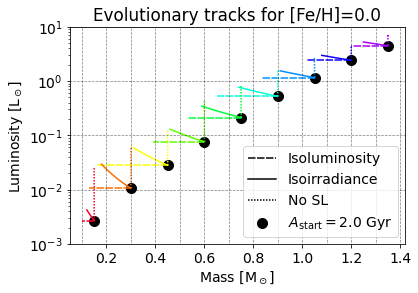

In [87]:
plt.figure()

all_l_stables, all_a, all_m, all_fits,all_indices = get_m_vs_a(all_ages, all_mass, all_T,all_L,feh,m_eval,a_start,isoirr=False,poly=POLY)
total = len(all_m[i])
cmap_total = total


for mass, l, x in zip(all_m[i],all_l_stables[i], range(total)):
    mass = np.array(mass)
    l = np.power(10,l)
    l = np.linspace(l,l, len(mass))
    plt.plot(mass, l, color = CMAP2(x/cmap_total), ls = (0,(5,1)))

all_l_stables, all_a, all_m, all_fits,all_indices = get_m_vs_a(all_ages, all_mass, all_T,all_L,feh,m_eval,a_start,isoirr=True,poly=POLY)
total = len(all_m[i])

for mass, l, x in zip(all_m[i],all_l_stables[i], range(total)):
    mass = np.array(mass)
    l = np.linspace(l,l,len(mass))/(mass*mass)
    plt.plot(mass, l, color = CMAP2(x/cmap_total))
    
    
all_init_mass = np.array([m[0] for m in all_mass[i]])  
indices = []
for init in m_eval: indices.append(np.argmin(np.abs(all_init_mass - init)))

l_natural,m_natural = [],[]
l_start, m_start = [],[]
for index in indices: 
    age_indices= np.where(np.array(all_ages[i][index]) > a_start)
    l_track = np.power(10,all_L[i][index][age_indices])
    m_track = all_mass[i][index][age_indices]
    l_natural.append(l_track)
    m_natural.append(m_track)
    l_start.append(l_track[0])
    m_start.append(m_track[0])
    
plt.scatter(m_start, l_start, s=100, c="black", label= r"$A_{\rm start}{=}$"+str(a_start/1e9)+" Gyr")

for mass, l, x in zip(m_natural,l_natural, range(total)):
    plt.plot(mass, l, color = CMAP2(x/cmap_total), ls=(0,(1,1)))
plt.xlim(0.05, m_eval[-1]*1.05)
plt.ylim(1e-3,10)
plt.plot([0,0.01], [0,0.01], label = "Isoluminosity", c="black", ls = (0,(5,1)))
plt.plot([0,0.01], [100,1000], label = "Isoirradiance", c="black")
plt.plot([0,0.01], [0,0.01], label = "No SL", c="black", ls = (0,(1,1)))
for l in np.power(10.0, np.arange(-4,3,1)): plt.plot([0,1.5], [l,l], ls="dashed", lw=0.7, color="black", alpha=0.5)
for m in np.arange(0,1.5,.1): plt.plot([m,m], [1e-4,1e3], ls="dashed", lw=0.7, color="black", alpha=0.5)
plt.legend()
    
#plt.scatter(init_mass, init_l, c = init_mass, cmap=CMAP2, edgecolors ="black", s=100, label=r"$A_{\rm start}$")

#plt.colorbar(label=r"Initial Mass [${\rm M}_\odot$]")
plt.xlabel(r"Mass [${\rm M}_\odot$]")
plt.ylabel(r"Luminosity [${\rm L}_\odot$]")
#plt.legend()
plt.yscale("log")
plt.title("Evolutionary tracks for [Fe/H]="+str(feh[i]))
plt.savefig("figures/funny_HR.pdf",bbox_inches='tight')

### Terminal age, the final age with SL, against inital mass

C:\Users\Matthew\AppData\Local\Temp/ipykernel_32888/2482139245.py:128: RankWarning: Polyfit may be poorly conditioned
  a,m,fit, indices = get_fits(age, mass, temp,log_L,l_stables,a_start,isoirr,SIGMA=True,poly=poly)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32888/2482139245.py:128: RankWarning: Polyfit may be poorly conditioned
  a,m,fit, indices = get_fits(age, mass, temp,log_L,l_stables,a_start,isoirr,SIGMA=True,poly=poly)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32888/2482139245.py:128: RankWarning: Polyfit may be poorly conditioned
  a,m,fit, indices = get_fits(age, mass, temp,log_L,l_stables,a_start,isoirr,SIGMA=True,poly=poly)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32888/2482139245.py:128: RankWarning: Polyfit may be poorly conditioned
  a,m,fit, indices = get_fits(age, mass, temp,log_L,l_stables,a_start,isoirr,SIGMA=True,poly=poly)


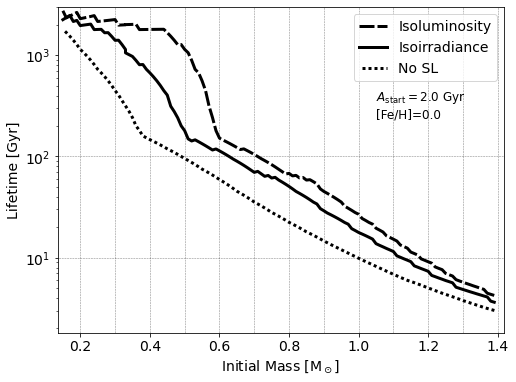

In [93]:
m_eval = np.arange(0.15,1.4,0.01)
i=1

lw=3
plt.figure(figsize=(8,6))
plt.ylabel("Lifetime [Gyr]")
plt.xlabel(r"Initial Mass [${\rm M}_\odot$]")
plt.yscale("log")
plt.ylim(a_start/1e9*0.9,3000)
plt.xlim(m_eval[0]*0.9, m_eval[-1]*1.02)

for isoirr in [False,True]:
    all_l_stables, all_a, all_m, all_fits,all_indices = get_m_vs_a(all_ages, all_mass, all_T,all_L,feh,m_eval,a_start,isoirr=isoirr,poly=POLY)
    x = [age_list[-1]/1e9 for age_list in all_a[i]]
    y = [mass_list[0] for mass_list in all_m[i]]

    if(isoirr): 
        ls = "-"
        label="Isoirradiance"
    else: 
        ls = (0,(5,1))
        label="Isoluminosity"
    plt.plot(y,x, ls=ls, label=label, c="black", lw=lw)

all_init_mass = np.array([m[0] for m in all_mass[i]])  
indices = []
for init in m_eval: indices.append(np.argmin(np.abs(all_init_mass - init)))
    
age_natural,m_natural = [],[]
for index in indices: 
    age_natural.append(all_ages[i][index][-1]/1e9)
    m_natural.append(all_mass[i][index][[0]])
    
plt.plot(m_natural,age_natural, ls=(1,(1,1)), label="No SL", c="black", lw=lw)

for age in np.power(10.0, np.arange(0,3,1)): plt.plot([0,1.5],[age,age], ls="dashed", lw=0.5, color="black", alpha=0.5)
for m in np.arange(0,1.5,.1): plt.plot([m,m],[0,1e4], ls="dashed", lw=0.5, color="black", alpha=0.5)


plt.legend(loc="upper right")
plt.text(.4, 0.4, r"$A_{\rm start}{=}$"+str(a_start/1e9)+" Gyr\n[Fe/H]="+str(feh[i]), fontsize=12, horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)



plt.savefig("figures/terminal_age_astart="+str(a_start)+".pdf", bbox_inches="tight")
plt.show()

C:\Users\Matthew\AppData\Local\Temp/ipykernel_32888/2482139245.py:128: RankWarning: Polyfit may be poorly conditioned
  a,m,fit, indices = get_fits(age, mass, temp,log_L,l_stables,a_start,isoirr,SIGMA=True,poly=poly)


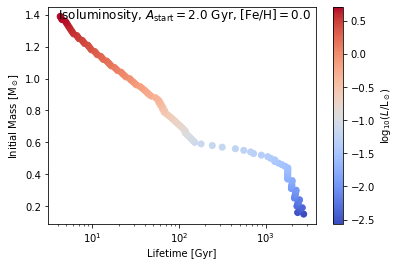

C:\Users\Matthew\AppData\Local\Temp/ipykernel_32888/2482139245.py:128: RankWarning: Polyfit may be poorly conditioned
  a,m,fit, indices = get_fits(age, mass, temp,log_L,l_stables,a_start,isoirr,SIGMA=True,poly=poly)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32888/2482139245.py:128: RankWarning: Polyfit may be poorly conditioned
  a,m,fit, indices = get_fits(age, mass, temp,log_L,l_stables,a_start,isoirr,SIGMA=True,poly=poly)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32888/2482139245.py:128: RankWarning: Polyfit may be poorly conditioned
  a,m,fit, indices = get_fits(age, mass, temp,log_L,l_stables,a_start,isoirr,SIGMA=True,poly=poly)


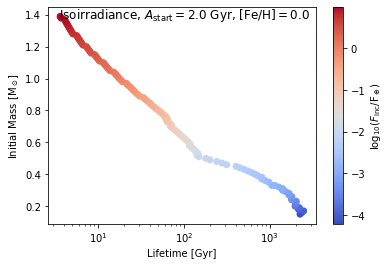

In [36]:
for isoirr in [False,True]:
    all_l_stables, all_a, all_m, all_fits,all_indices = get_m_vs_a(all_ages, all_mass, all_T,all_L,feh,m_eval,a_start,isoirr=isoirr,poly=POLY)
    fig, ax = plt.subplots()
    i=1
    plt.xlabel("Lifetime [Gyr]")
    plt.ylabel(r"Initial Mass [${\rm M}_\odot$]")


    x = [age_list[-1]/1e9 for age_list in all_a[i]]
    y = [mass_list[0] for mass_list in all_m[i]]

    if(isoirr): col = np.log10(all_l_stables[i])
    else: col = all_l_stables[i]
    c = plt.scatter(x,y,c=col, cmap=CMAP)#, vmin=vmin, vmax=vmax)
    plt.xscale("log")



    if(isoirr): 
        plt.text(0.98, 0.96, r"Isoirradiance, $A_{\rm start}{=}$"+str(a_start/1e9)+" Gyr, [Fe/H]${=}$"+str(feh[i]), fontsize=12, horizontalalignment='right',verticalalignment='center', transform=ax.transAxes)
        fig.colorbar(c, label=r"${\rm log}_{10}(F_{\rm inc}/{\rm F}_\oplus)$")  

    else: 
        plt.text(0.98, 0.96, r"Isoluminosity, $A_{\rm start}{=}$"+str(a_start/1e9)+" Gyr, [Fe/H]${=}$"+str(feh[i]), fontsize=12, horizontalalignment='right',verticalalignment='center', transform=ax.transAxes)
        fig.colorbar(c, label=r"${\rm log}_{10}(L/{\rm L}_\odot)$")  
    
    #plt.savefig("figures/terminal_age_astart="+str(a_start)+"_isoirr="+str(isoirr)+".pdf", bbox_inches="tight")
    plt.show()

### Mass (and dm/dt) vs age

0
2
1


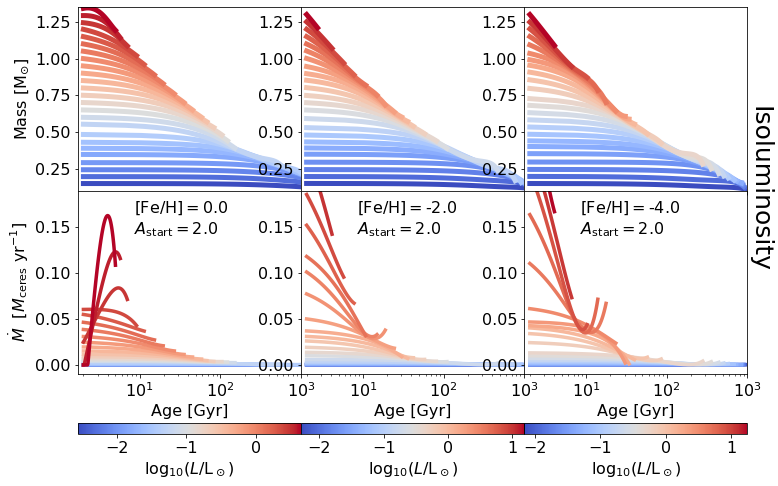

In [92]:
isoirr=False
upper=1e12
plt.rc('font', size=16)    # fontsize of the x and y labels

m_eval = np.arange(0.15,1.4,0.05)
all_l_stables, all_a, all_m, all_fits,all_indices = get_m_vs_a(all_ages, all_mass, all_T,all_L,feh,m_eval,a_start,isoirr=isoirr,poly=POLY)

desired_feh = [0.0, -2.0, -4.0]
fig, axs = plt.subplots(2,3, figsize=(12,9),sharex=True,sharey=False)
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(len(all_indices)) :
    if(feh[i] not in desired_feh): continue
    a=np.where(feh[i] == np.array(desired_feh))[0][0]
    print(a)

    if(isoirr): constant = np.log10(all_l_stables[i])
    else: constant = all_l_stables[i]
    
    c_max, c_min = np.max(constant), np.min(constant)
 

    for num,x in enumerate(all_indices[i]):
        col = (constant[num] - c_min)/(c_max-c_min)
        
        pts = np.linspace(a_start, min(upper,max(all_a[i][num])),120)
        poly = np.polyfit(all_a[i][num],all_m[i][num],DEGREE_OF_FIT)
        axs[0,a].plot(pts/1e9, np.poly1d(poly)(pts), color=CMAP(col), lw=5)
        yax = -np.polyder(np.poly1d(poly))(pts)*m_sol/m_ceres
        neg = np.where(yax<0)
        yax[neg] = 0
        axs[1,a].plot(pts/1e9, yax, color=CMAP(col), lw=3.5)

            
    if(isoirr):  c = axs[0,a].scatter(np.linspace(a_start,a_start,len(constant)),constant , cmap=CMAP, c=constant, s=0)
    else:  c = axs[0,a].scatter(np.zeros(len(constant)), np.zeros(len(constant)), cmap=CMAP, c=constant, s=0)
    
    axs[1,a].set_xlim(0.85*a_start/1e9,upper/1e9)
    axs[1,a].set_xlabel("Age [Gyr]")
    axs[0,a].set_ylim(m_eval[0]-0.05, m_eval[-1])
    axs[1,a].set_ylim(-0.01, 0.19)
    axs[0,a].set_yticks([0.25,0.5,0.75,1,1.25])
    plt.xscale("log")

    if(a==0):
        axs[0,a].set_ylabel(r"Mass $[{\rm M}_{\odot}]$")
        axs[1,a].set_ylabel(r"$\dot{M}$  [$M_{\rm ceres}\ {\rm yr}^{-1}$]")


    if(isoirr):
        fig.colorbar(c, ax=axs[:2,a],label=r"${\rm log}_{10}(\mathcal{F}/{\mathcal{F}}_\odot)$", location='bottom', pad=0.1)
        plt.text(0.25, 0.95, "[Fe/H]"+r"${=}$"+str(feh[i])+"\n"+r"$A_{\rm start}{=}$"+str(a_start/1e9), horizontalalignment='left',verticalalignment='top', transform=axs[1,a].transAxes)
    else:  
        fig.colorbar(c, ax=axs[:2,a],label=r"${\rm log}_{10}(L/{\rm L}_\odot)$", location='bottom', pad=0.1)
        plt.text(0.25, 0.95, "[Fe/H]"+r"${=}$"+str(feh[i])+"\n"+r"$A_{\rm start}{=}$"+str(a_start/1e9), horizontalalignment='left',verticalalignment='top', transform=axs[1,a].transAxes)

        
#     else: 
#         fig.colorbar(c, label=r"${\rm log}_{10}(L/{\rm L}_\odot)$")    
#         plt.suptitle("Isoluminosity, "+r"$A_{\rm start}{=}$"+str(a_start/1e9)+" Gyr, " + "[Fe/H] = "+str(feh[i]))

#     if(feh[i] < 0): feh_st = "m"+str(np.abs(feh[i]))
#     else: feh_st = "p"+str(np.abs(feh[i]))

if(isoirr):fig.supylabel("Isoirradiance", x=0.9,rotation=270,y=0.6, size=25)
else:fig.supylabel("Isoluminosity", x=0.9,rotation=270,y=0.6, size=25)
dir_ ="figures/fit_figs_l" 
if(isoirr): dir_ +="msq"
plt.savefig(dir_+"/m_vs_a_a_start="+str(a_start)+"_iso="+str(isoirr)+".pdf",bbox_inches='tight')
plt.show()

# Comparing lifetimes between SL and regular stars

In [8]:
def get_lifetime_ratios(all_ages, all_mass, all_a, all_m,feh):
    X = []
    for i in range(len(feh)):
        starting_mass = []
        for j in range(len(all_mass[i])): 
            starting_mass.append(all_mass[i][j][0])
        stating_mass = np.array(starting_mass)
        
        for j in range(len(all_m[i])):
            init_mass = all_m[i][j][0]
            final_mass = all_m[i][j][-1]
            new_age = all_a[i][j][-1]
            track_ind = np.argmin(np.abs(starting_mass-init_mass))
            expected_age = all_ages[i][track_ind][-1]
            X.append((init_mass, new_age, expected_age, new_age/expected_age, feh[i],final_mass))
    return X



In [9]:
def add_subplot_axes(ax,rect,axisbg='w'):
    #from https://stackoverflow.com/questions/17458580/embedding-small-plots-inside-subplots-in-matplotlib
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    #subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
    subax = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111)
# rect = [0.2,0.2,0.7,0.7]
# ax1 = add_subplot_axes(ax,rect)
# ax2 = add_subplot_axes(ax1,rect)
# plt.show()

In [12]:
feh

[0.5, 0.0, -4.0, -1.0, -2.0, -3.0]

C:\Users\Matthew\AppData\Local\Temp/ipykernel_5232/2482139245.py:128: RankWarning: Polyfit may be poorly conditioned
  a,m,fit, indices = get_fits(age, mass, temp,log_L,l_stables,a_start,isoirr,SIGMA=True,poly=poly)


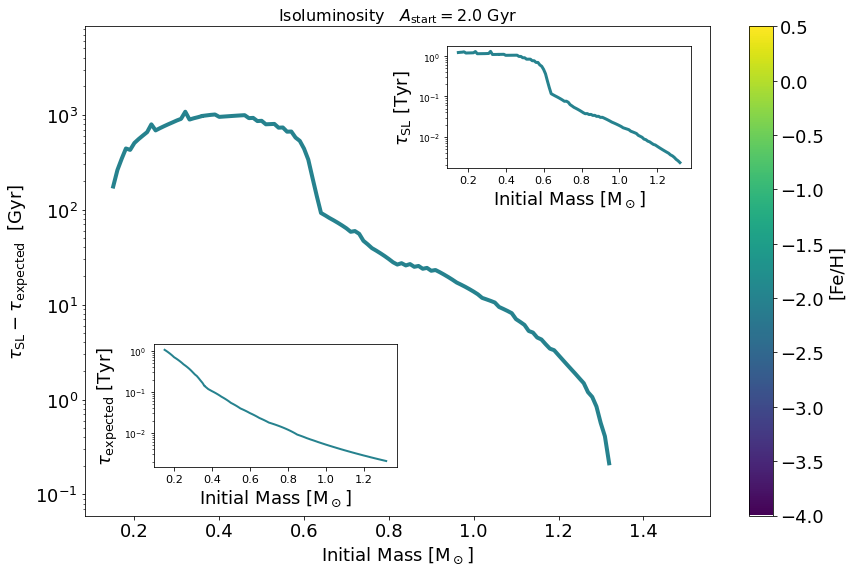

In [13]:
m_eval = np.arange(0.15,1.5,0.01)
plt.rc('font', size=18)    # fontsize of the x and y labels
m_thresh = 0.13

for isoirr in [False]:
    for a_start in [2e9]:
        all_l_stables, all_a, all_m, all_fits,all_indices = get_m_vs_a(all_ages, all_mass,all_T, all_L,feh,m_eval,a_start,isoirr=isoirr,poly=POLY)

        X = get_lifetime_ratios(all_ages, all_mass, all_a, all_m,feh)

        X2 = np.array(X).T
        init_mass = X2[0]
        sl_lifetime = X2[1]
        no_sl_lifetime = X2[2]
        feh_list = X2[-2]
        ratio = X2[-3]
        difference = sl_lifetime-no_sl_lifetime
        final_mass = X2[-1]

        fig = plt.figure(figsize=(14,9))
        ax = fig.add_subplot(111)

        x=-2
        index = np.where(feh_list == feh[x])
        ax.plot(init_mass[index], difference[index]/1e9, color=cm.viridis((feh[x]+4.0)/(4.5)), lw=4)

        #plt.legend(loc="upper left")
        c = ax.scatter(init_mass, difference/1e9, c=feh_list, cmap=cm.viridis, s=0)
        fig.colorbar(c,label="[Fe/H]")
        plt.xlabel(r"Initial Mass [${\rm M}_\odot$]")
        plt.ylabel(r"$\tau_{\rm SL} - \tau_{\rm expected}$  [Gyr]")
        plt.yscale("log")
        if(isoirr): plt.title("Isoirradiance   "+r"$A_{\rm start}{=}$"+str(a_start/1e9)+" Gyr", fontsize=16)
        else: plt.title("Isoluminosity   "+r"$A_{\rm start}{=}$"+str(a_start/1e9)+" Gyr", fontsize=16)
        #plt.yscale("log")
        #ax.set_yticks(np.arange(1,math.ceil(np.max(difference)),1))



        rect = [0.58,0.71,0.39,0.25]
        ax1 = add_subplot_axes(ax,rect)
        index = np.where(feh_list == feh[x])
        ax1.plot(init_mass[index], sl_lifetime[index]/1e12, color=cm.viridis((feh[x]+4.0)/(4.5)), lw=3)
        plt.yscale("log")
        plt.xlabel(r"Initial Mass [${\rm M}_\odot$]")
        plt.ylabel(r"$\tau_{\rm SL}$ [Tyr]")

        rect = [0.11,0.10,0.39,0.25]
        ax1 = add_subplot_axes(ax,rect)
        index = np.where(feh_list == feh[x])
        ax1.plot(init_mass[index], no_sl_lifetime[index]/1e12, color=cm.viridis((feh[x]+4.0)/(4.5)),lw=2)
        plt.yscale("log")
        plt.xlabel(r"Initial Mass [${\rm M}_\odot$]")
        plt.ylabel(r"$\tau_{\rm expected}$ [Tyr]")    


        type_ = "l"
        if(isoirr): type_ += "msq"
#         if(isoirr): ax.text(0.2, 0.95, "Isoirradiance"+r"$A_{\rm start}{=}$"+str(a_start/1e9)+" Gyr", fontsize=16,horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
#         if(not isoirr): ax.text(0.2, 0.9, "Isoluminosity"+r"$A_{\rm start}{=}$"+str(a_start/1e9)+" Gyr", fontsize=16,horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
        
        plt.savefig("video_figures/astart_"+str(a_start/1e9)+"gyr_"+type_+".pdf",bbox_inches='tight')
        plt.show()

<ipython-input-4-e2e1590199ee>:128: RankWarning: Polyfit may be poorly conditioned
  a,m,fit, indices = get_fits(age, mass, temp,log_L,l_stables,a_start,isoirr,SIGMA=True,poly=poly)
<ipython-input-4-e2e1590199ee>:128: RankWarning: Polyfit may be poorly conditioned
  a,m,fit, indices = get_fits(age, mass, temp,log_L,l_stables,a_start,isoirr,SIGMA=True,poly=poly)
<ipython-input-4-e2e1590199ee>:128: RankWarning: Polyfit may be poorly conditioned
  a,m,fit, indices = get_fits(age, mass, temp,log_L,l_stables,a_start,isoirr,SIGMA=True,poly=poly)


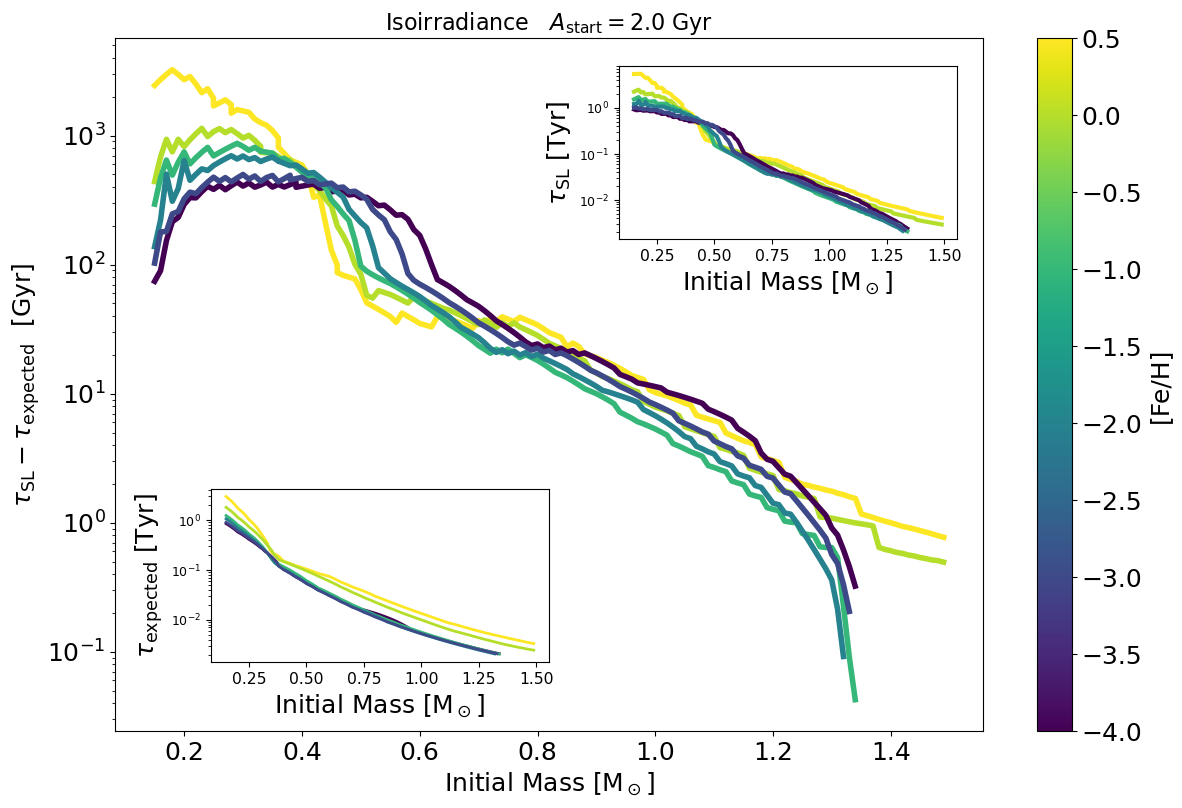

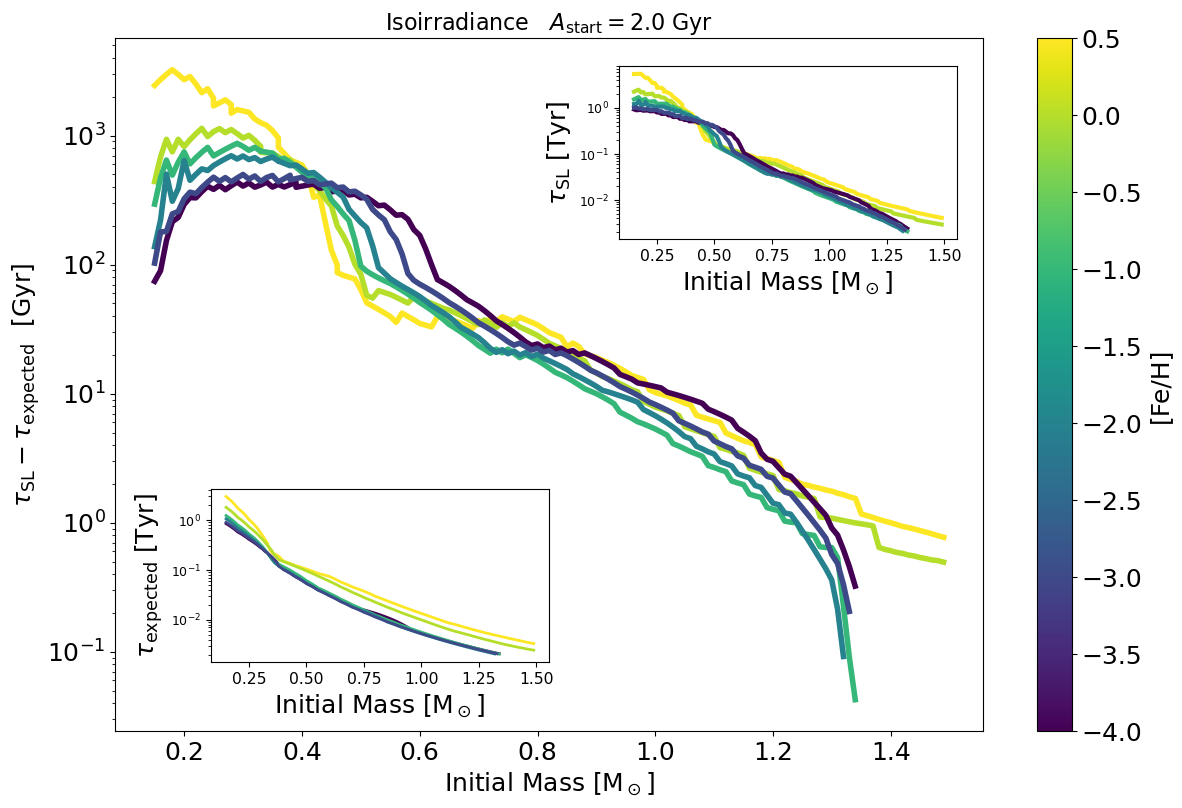

<ipython-input-4-e2e1590199ee>:128: RankWarning: Polyfit may be poorly conditioned
  a,m,fit, indices = get_fits(age, mass, temp,log_L,l_stables,a_start,isoirr,SIGMA=True,poly=poly)


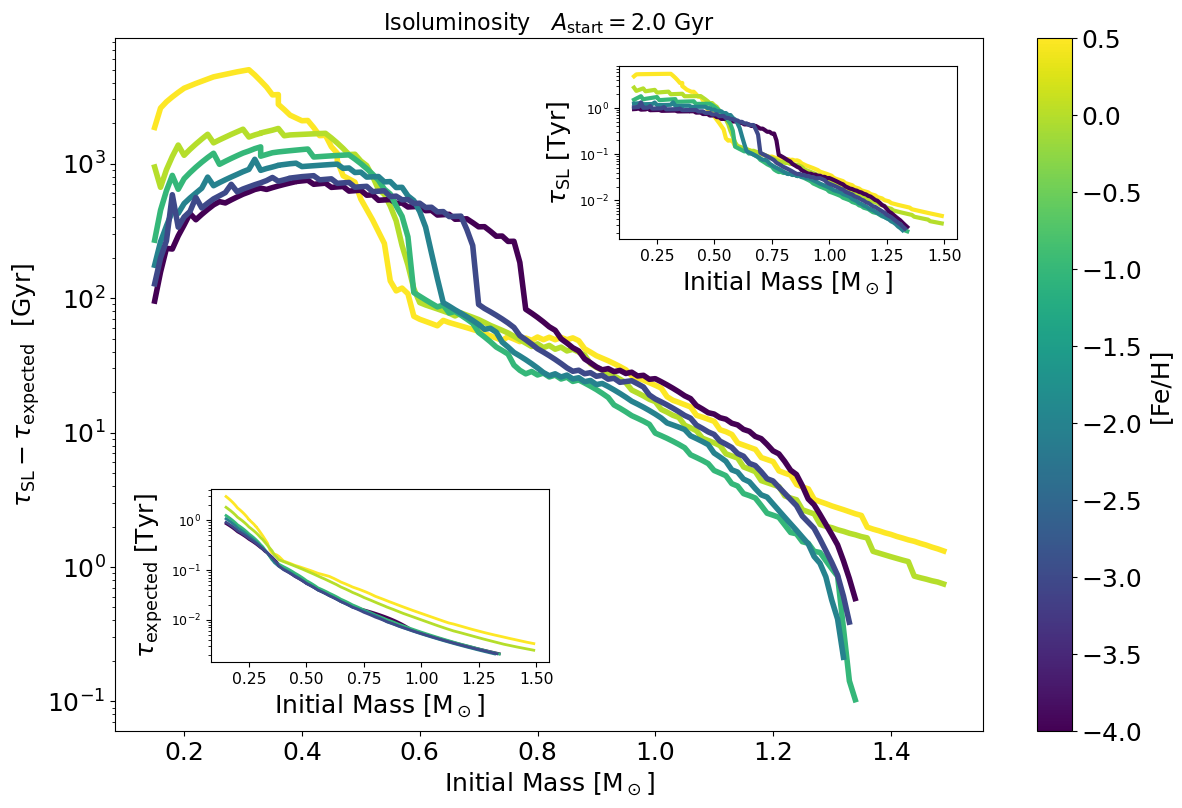

In [13]:
m_eval = np.arange(0.15,1.5,0.01)
plt.rc('font', size=18)    # fontsize of the x and y labels
m_thresh = 0.13

for isoirr in [True,False]:
    for a_start in [2e9]:
        all_l_stables, all_a, all_m, all_fits,all_indices = get_m_vs_a(all_ages, all_mass,all_T, all_L,feh,m_eval,a_start,isoirr=isoirr,poly=POLY)

        X = get_lifetime_ratios(all_ages, all_mass, all_a, all_m,feh)

        X2 = np.array(X).T
        init_mass = X2[0]
        sl_lifetime = X2[1]
        no_sl_lifetime = X2[2]
        feh_list = X2[-2]
        ratio = X2[-3]
        difference = sl_lifetime-no_sl_lifetime
        final_mass = X2[-1]

        fig = plt.figure(figsize=(14,9))
        ax = fig.add_subplot(111)

        for x in range(len(feh)):
            index = np.where(feh_list == feh[x])
            ax.plot(init_mass[index], difference[index]/1e9, color=cm.viridis((feh[x]+4.0)/(4.5)), lw=4)
            
        #plt.legend(loc="upper left")
        c = ax.scatter(init_mass, difference/1e9, c=feh_list, cmap=cm.viridis, s=0)
        fig.colorbar(c,label="[Fe/H]")
        plt.xlabel(r"Initial Mass [${\rm M}_\odot$]")
        plt.ylabel(r"$\tau_{\rm SL} - \tau_{\rm expected}$  [Gyr]")
        plt.yscale("log")
        if(isoirr): plt.title("Isoirradiance   "+r"$A_{\rm start}{=}$"+str(a_start/1e9)+" Gyr", fontsize=16)
        else: plt.title("Isoluminosity   "+r"$A_{\rm start}{=}$"+str(a_start/1e9)+" Gyr", fontsize=16)
        #plt.yscale("log")
        #ax.set_yticks(np.arange(1,math.ceil(np.max(difference)),1))



        rect = [0.58,0.71,0.39,0.25]
        ax1 = add_subplot_axes(ax,rect)
        for x in range(len(feh)):
            index = np.where(feh_list == feh[x])
            ax1.plot(init_mass[index], sl_lifetime[index]/1e12, color=cm.viridis((feh[x]+4.0)/(4.5)), lw=3)
        plt.yscale("log")
        plt.xlabel(r"Initial Mass [${\rm M}_\odot$]")
        plt.ylabel(r"$\tau_{\rm SL}$ [Tyr]")

        rect = [0.11,0.10,0.39,0.25]
        ax1 = add_subplot_axes(ax,rect)
        for x in range(len(feh)):
            index = np.where(feh_list == feh[x])
            ax1.plot(init_mass[index], no_sl_lifetime[index]/1e12, color=cm.viridis((feh[x]+4.0)/(4.5)),lw=2)
        plt.yscale("log")
        plt.xlabel(r"Initial Mass [${\rm M}_\odot$]")
        plt.ylabel(r"$\tau_{\rm expected}$ [Tyr]")    


        type_ = "l"
        if(isoirr): type_ += "msq"
#         if(isoirr): ax.text(0.2, 0.95, "Isoirradiance"+r"$A_{\rm start}{=}$"+str(a_start/1e9)+" Gyr", fontsize=16,horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
#         if(not isoirr): ax.text(0.2, 0.9, "Isoluminosity"+r"$A_{\rm start}{=}$"+str(a_start/1e9)+" Gyr", fontsize=16,horizontalalignment='left',verticalalignment='center', transform=ax.transAxes)
        
        plt.savefig("figures/lifetime_gains/astart_"+str(a_start/1e9)+"gyr_"+type_+".pdf",bbox_inches='tight')
        plt.show()

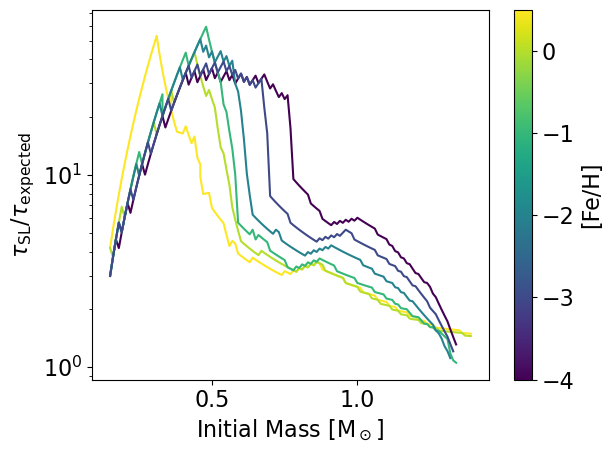

In [161]:
def analytic_lifetime_ratios(all_ages, all_mass, all_a, all_m,feh):
    X = []
    for i in range(len(feh)):
        starting_mass = []
        final_mass = []
        for j in range(len(all_m[i])): 
            starting_mass.append(all_m[i][j][0])
            final_mass.append(all_m[i][j][-1])
        stating_mass = np.array(starting_mass)
        final_mass = np.array(final_mass)
        
        for j in range(len(starting_mass)):
            init_mass_age = np.power(10,10)*np.power(starting_mass[j], -3.5)
            final_mass_age = np.power(10,10)*np.power(final_mass[j], -3.5)
            
            X.append((starting_mass[j], final_mass[j],init_mass_age, final_mass_age, final_mass_age/init_mass_age, feh[i]))
    return X

X = analytic_lifetime_ratios(all_ages, all_mass, all_a, all_m,feh)

X2 = np.array(X).T
init_mass = X2[0]
final_mass = X2[1]
feh_list = X2[-1]
ratio = X2[-2]

plt.figure()
for x in range(len(feh)):
    index = np.where(feh_list == feh[x])
    plt.plot(init_mass[index], ratio[index], color=cm.viridis((feh[x]+4.0)/(4.5)))
plt.scatter(init_mass, ratio, c=feh_list, cmap=cm.viridis, s=0)
plt.colorbar(label="[Fe/H]")
plt.xlabel(r"Initial Mass [${\rm M}_\odot$]")
plt.ylabel(r"$\tau_{\rm SL} / \tau_{\rm expected}$")
plt.yscale("log")
type_ = "l"
if(isoirr): type_ += "msq"
#plt.savefig("figures/lifetime_ratios_analytic.pdf",bbox_inches='tight')
plt.show()

# Plotting all of the MIST main-sequence data which we'll be interpolating over

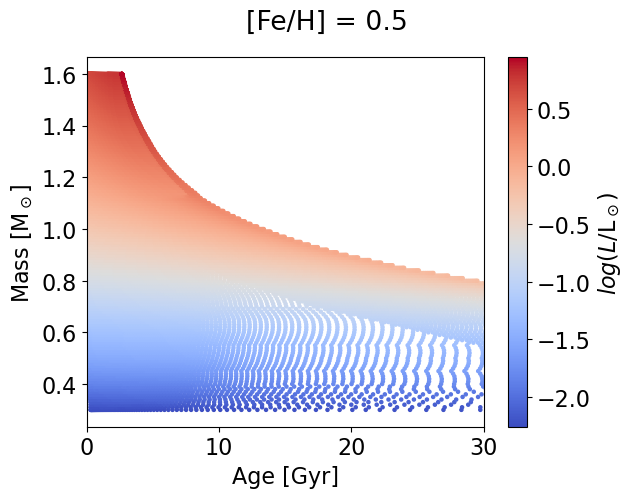

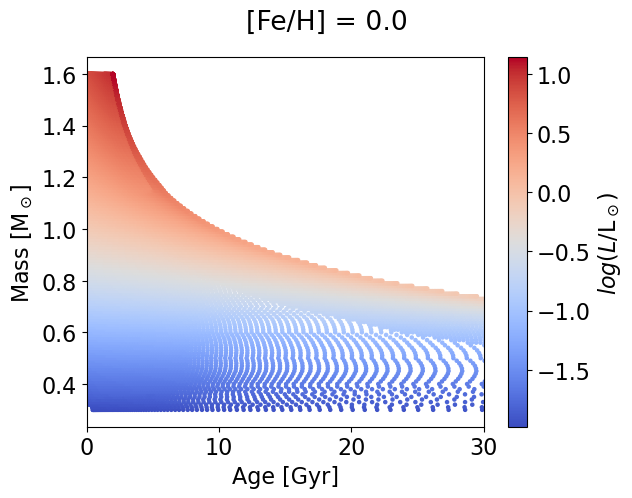

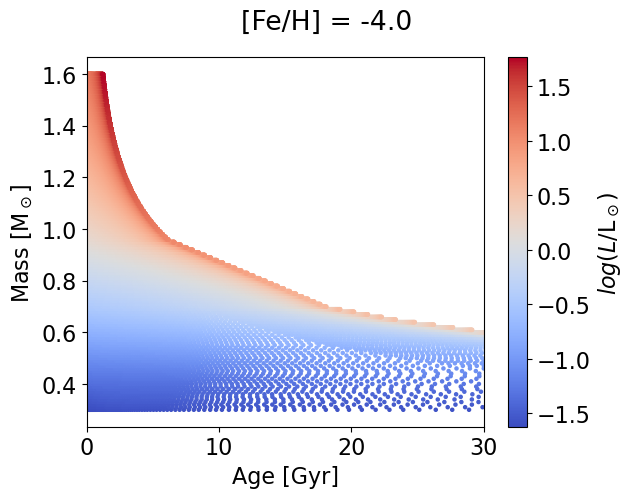

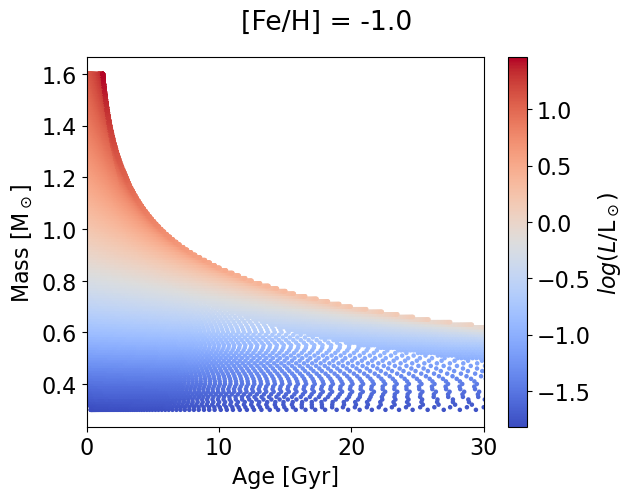

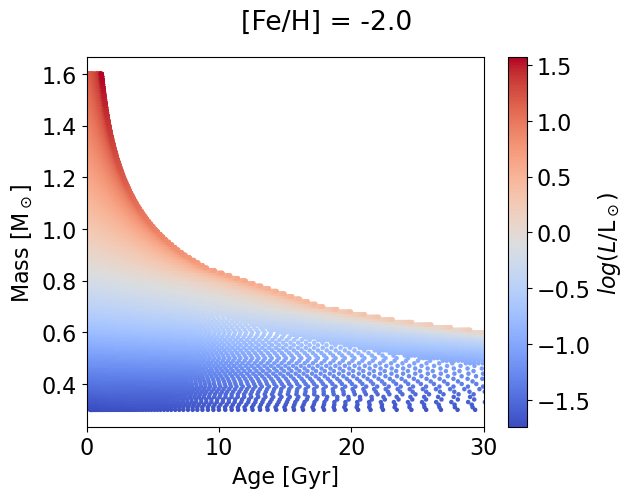

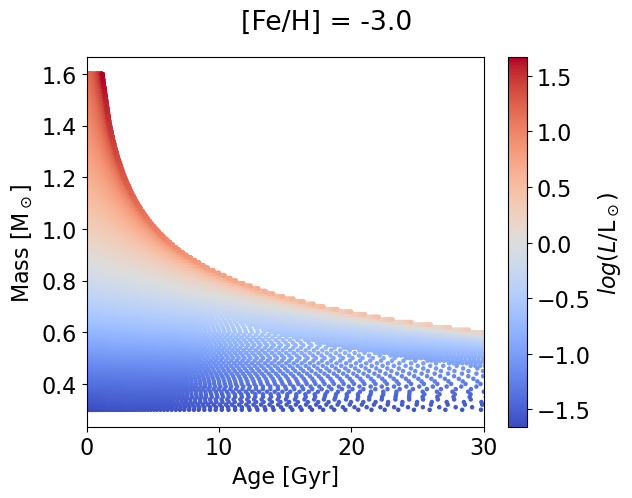

In [118]:
for i in range(len(feh)) :
    fig = plt.figure()
    if(ISOIRR): vmax, vmin = np.log10(np.max(np.power(10,all_L[i])*np.power(all_mass[i],2))),np.log10(np.min(np.power(10,all_L[i])*np.power(all_mass[i],2)))
    else: vmax, vmin = np.max(all_L[i]),np.min(all_L[i])
    
    
    
    for mass,age,log_l in zip(all_mass[i], all_ages[i], all_L[i]):
        if(ISOIRR):plt.scatter(age/1e9,mass, cmap=CMAP, c=np.log10(np.power(10,log_l)*np.power(mass,2)),s=5, vmin=vmin, vmax=vmax)
        else:plt.scatter(age/1e9,mass, cmap=CMAP, c=log_l,s=5, vmin=vmin, vmax=vmax)
    
    plt.xlim(0,30)
    plt.xlabel("Age [Gyr]")
    plt.ylabel(r"Mass [${\rm M}_\odot$]")
    if(ISOIRR): plt.colorbar(label=r"$log(L_0 M_0^2/({\rm M}^2_\odot {\rm L}_\odot))$")
    else: plt.colorbar(label=r"$log(L/{\rm L}_\odot)$")
        
    plt.suptitle("[Fe/H] = "+str(feh[i]))
    if(feh[i] < 0): feh_st = "m"+str(np.abs(feh[i]))
    else: feh_st = "p"+str(np.abs(feh[i]))
    dir_ = "figures/MIST_dense_l"
    if(ISOIRR): dir_ += "msq"
    plt.savefig(dir_+"/feh_"+feh_st+".pdf",bbox_inches='tight')

# F star investigation

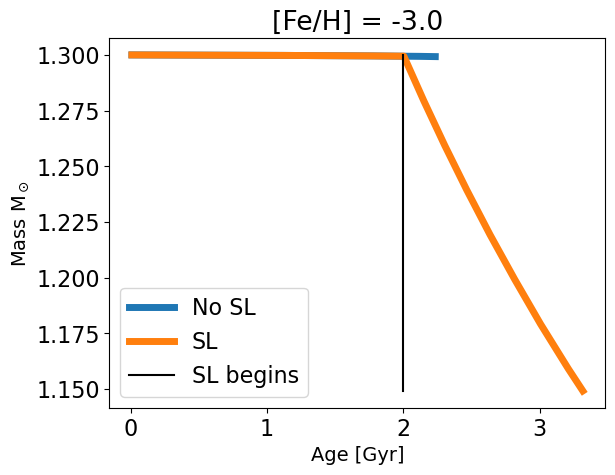

In [157]:
init_m = 1.3
feh_ind = -1
initial_masses_sl, initial_masses_norm = [],[]
for x in range(len(all_m[feh_ind])): initial_masses_sl.append(all_m[feh_ind][x][0])
for x in range(len(all_mass[feh_ind])): initial_masses_norm.append(all_mass[feh_ind][x][0])
ind_sl = np.argmin(np.abs(np.array(initial_masses_sl)-init_m))
ind_norm = np.argmin(np.abs(np.array(initial_masses_norm)-init_m))
f_mass_sl, f_age_sl, f_lum_sl= all_m[feh_ind][ind_sl], all_a[feh_ind][ind_sl], np.linspace(all_l_stables[feh_ind][ind_sl],all_l_stables[feh_ind][ind_sl],len(all_m[feh_ind][ind_sl]))
f_mass_norm, f_age_norm, f_lum_norm= all_mass[feh_ind][ind_norm], all_ages[feh_ind][ind_norm], np.power(10,all_L[feh_ind][ind_norm])*np.power(all_mass[feh_ind][ind_norm],2)

overlap_inds = np.where(f_age_norm < f_age_sl[0])

f_mass_sl =np.append(f_mass_norm[overlap_inds], f_mass_sl)
f_age_sl =np.append(f_age_norm[overlap_inds], f_age_sl)
f_lum_sl =np.append(f_lum_norm[overlap_inds], f_lum_sl)

plt.plot(f_age_norm/1e9,f_mass_norm, label = "No SL",lw=5,c="tab:blue")
plt.plot(f_age_sl/1e9,f_mass_sl, label = "SL", lw=5,c="tab:orange")
plt.plot(np.linspace(a_start/1e9,a_start/1e9,20), np.linspace(np.min(f_mass_sl),np.max(f_mass_sl), 20), label="SL begins", c="black")
plt.legend(loc="lower left")
plt.title("")
plt.xlabel("Age [Gyr]", size=14)
plt.ylabel(r"Mass ${\rm M}_\odot$", size=14)
plt.title("[Fe/H] = "+str(feh[feh_ind]))

plt.savefig("figures/f_stars/init_m_"+str(init_m)+"_feh_"+str(feh[feh_ind])+".pdf",bbox_inches='tight')

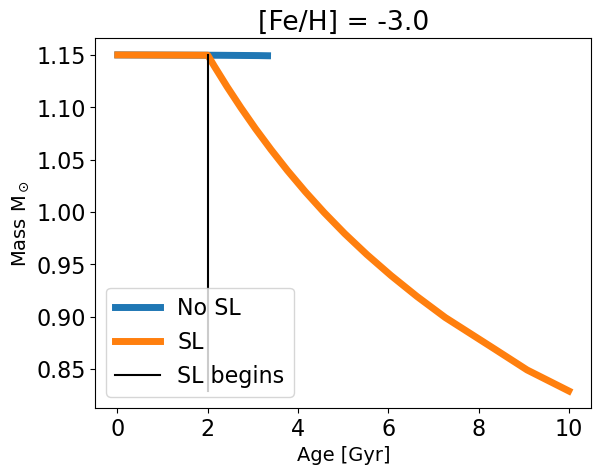

In [158]:
init_m = 1.15
feh_ind = -1
initial_masses_sl, initial_masses_norm = [],[]
for x in range(len(all_m[feh_ind])): initial_masses_sl.append(all_m[feh_ind][x][0])
for x in range(len(all_mass[feh_ind])): initial_masses_norm.append(all_mass[feh_ind][x][0])
ind_sl = np.argmin(np.abs(np.array(initial_masses_sl)-init_m))
ind_norm = np.argmin(np.abs(np.array(initial_masses_norm)-init_m))
f_mass_sl, f_age_sl, f_lum_sl= all_m[feh_ind][ind_sl], all_a[feh_ind][ind_sl], np.linspace(all_l_stables[feh_ind][ind_sl],all_l_stables[feh_ind][ind_sl],len(all_m[feh_ind][ind_sl]))
f_mass_norm, f_age_norm, f_lum_norm= all_mass[feh_ind][ind_norm], all_ages[feh_ind][ind_norm], np.power(10,all_L[feh_ind][ind_norm])*np.power(all_mass[feh_ind][ind_norm],2)

overlap_inds = np.where(f_age_norm < f_age_sl[0])

f_mass_sl =np.append(f_mass_norm[overlap_inds], f_mass_sl)
f_age_sl =np.append(f_age_norm[overlap_inds], f_age_sl)
f_lum_sl =np.append(f_lum_norm[overlap_inds], f_lum_sl)

plt.plot(f_age_norm/1e9,f_mass_norm, label = "No SL",lw=5,c="tab:blue")
plt.plot(f_age_sl/1e9,f_mass_sl, label = "SL", lw=5,c="tab:orange")
plt.plot(np.linspace(a_start/1e9,a_start/1e9,20), np.linspace(np.min(f_mass_sl),np.max(f_mass_sl), 20), label="SL begins", c="black")
plt.legend(loc="lower left")
plt.title("")
plt.xlabel("Age [Gyr]", size=14)
plt.ylabel(r"Mass ${\rm M}_\odot$", size=14)
plt.title("[Fe/H] = "+str(feh[feh_ind]))

plt.savefig("figures/f_stars/init_m_"+str(init_m)+"_feh_"+str(feh[feh_ind])+".pdf",bbox_inches='tight')

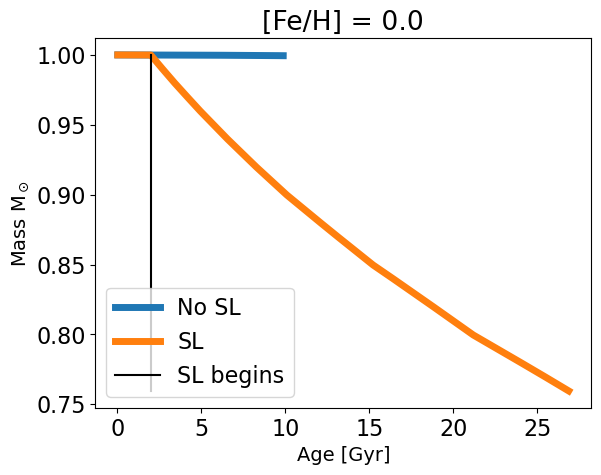

In [159]:
init_m = 1.0
feh_ind = 1
initial_masses_sl, initial_masses_norm = [],[]
for x in range(len(all_m[feh_ind])): initial_masses_sl.append(all_m[feh_ind][x][0])
for x in range(len(all_mass[feh_ind])): initial_masses_norm.append(all_mass[feh_ind][x][0])
ind_sl = np.argmin(np.abs(np.array(initial_masses_sl)-init_m))
ind_norm = np.argmin(np.abs(np.array(initial_masses_norm)-init_m))
f_mass_sl, f_age_sl, f_lum_sl= all_m[feh_ind][ind_sl], all_a[feh_ind][ind_sl], np.linspace(all_l_stables[feh_ind][ind_sl],all_l_stables[feh_ind][ind_sl],len(all_m[feh_ind][ind_sl]))
f_mass_norm, f_age_norm, f_lum_norm= all_mass[feh_ind][ind_norm], all_ages[feh_ind][ind_norm], np.power(10,all_L[feh_ind][ind_norm])*np.power(all_mass[feh_ind][ind_norm],2)

overlap_inds = np.where(f_age_norm < f_age_sl[0])

f_mass_sl =np.append(f_mass_norm[overlap_inds], f_mass_sl)
f_age_sl =np.append(f_age_norm[overlap_inds], f_age_sl)
f_lum_sl =np.append(f_lum_norm[overlap_inds], f_lum_sl)

plt.plot(f_age_norm/1e9,f_mass_norm, label = "No SL",lw=5,c="tab:blue")
plt.plot(f_age_sl/1e9,f_mass_sl, label = "SL", lw=5,c="tab:orange")
plt.plot(np.linspace(a_start/1e9,a_start/1e9,20), np.linspace(np.min(f_mass_sl),np.max(f_mass_sl), 20), label="SL begins", c="black")
plt.legend(loc="lower left")
plt.title("")
plt.xlabel("Age [Gyr]", size=14)
plt.ylabel(r"Mass ${\rm M}_\odot$", size=14)
plt.title("[Fe/H] = "+str(feh[feh_ind]))

plt.savefig("figures/f_stars/init_m_"+str(init_m)+"_feh_"+str(feh[feh_ind])+".pdf",bbox_inches='tight')

# Solar SL vs no SL for luminosity and mass

In [44]:
initial_masses_sl, initial_masses_norm = [],[]
for x in range(len(all_m[1])): initial_masses_sl.append(all_m[1][x][0])
for x in range(len(all_mass[1])): initial_masses_norm.append(all_mass[1][x][0])
ind_sl = np.argmin(np.abs(np.array(initial_masses_sl)-1))
ind_norm = np.argmin(np.abs(np.array(initial_masses_norm)-1))
solar_mass_sl, solar_age_sl, solar_lum_sl= all_m[1][ind_sl], all_a[1][ind_sl], np.linspace(all_l_stables[1][ind_sl],all_l_stables[1][ind_sl],len(all_m[1][ind_sl]))
solar_mass_norm, solar_age_norm, solar_lum_norm= all_mass[1][ind_norm], all_ages[1][ind_norm], np.power(10,all_L[1][ind_norm])*np.power(all_mass[1][ind_norm],2)

overlap_inds = np.where(solar_age_norm < solar_age_sl[0])

solar_mass_sl =np.append(solar_mass_norm[overlap_inds], solar_mass_sl)
solar_age_sl =np.append(solar_age_norm[overlap_inds], solar_age_sl)
solar_lum_sl =np.append(solar_lum_norm[overlap_inds], solar_lum_sl)


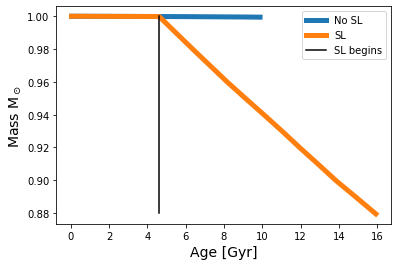

In [57]:
plt.plot(solar_age_norm/1e9,solar_mass_norm, label = "No SL",lw=5,c="tab:blue")
plt.plot(solar_age_sl/1e9,solar_mass_sl, label = "SL", lw=5,c="tab:orange")
plt.plot(np.linspace(a_start/1e9,a_start/1e9,20), np.linspace(.88,1, 20), label="SL begins", c="black")
plt.legend()
plt.xlabel("Age [Gyr]", size=14)
plt.ylabel(r"Mass ${\rm M}_\odot$", size=14)
plt.savefig("figures/solar_m_vs_a.png")

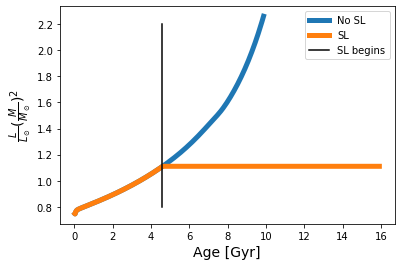

In [58]:
plt.plot(solar_age_norm/1e9,solar_lum_norm, label = "No SL",lw=5,c="tab:blue")
plt.plot(solar_age_sl/1e9,solar_lum_sl, label = "SL", lw=5,c="tab:orange")
plt.plot(np.linspace(a_start/1e9,a_start/1e9,20), np.linspace(0.8,2.2, 20), label="SL begins", c="black")

plt.legend()
plt.xlabel("Age [Gyr]", size=14)
plt.ylabel(r"$\frac{L}{L_\odot}(\frac{M}{M_\odot})^2$", size=14)
plt.savefig("figures/solar_l_vs_a.png")

# ML stuff, using ML rather than curve fitting.

In [36]:
def norm(X,lo,up):
    X=np.array(X)
    return (X-lo)/(up-lo)

def norm_inv(X,lo,up):
    X=np.array(X)
    return X*(up-lo) + lo

class ml_bounds:
    mass_min= 0
    mass_max= 1.7
    age_min= 0
    age_max= 65e9
    dmdt_min= 0
    dmdt_max= 0.3
    l_min=0.0001
    l_max=150
    feh_min= 1.5
    feh_max= -5


def prep_ML_data1(all_indices, all_exp_fits, all_l_stables,feh, a_start):
    ml_mass, ml_l, ml_feh, ml_dmdt,ml_age =[],[],[],[],[]
    #pts = np.linspace(a_start, 60e9,1500)
    for i in range(len(all_indices)) :    
        for num,x in enumerate(all_indices[i]):
            a,b,c = all_exp_fits[i][num]
            if(num > 0): a2,b2,c2= all_exp_fits[i][num-1]
            pts = np.linspace(a_start, min(60e9, np.max(all_a[i][num])*.95),1500)
            for age_ in pts:
                m1=exp(age_,a,b,c)
                if(num>0):
                    m2=exp(age_,a2,b2,c2)
#                     m3=-exp_der(age_,a,b,c)
#                     m4=-exp_der(age_,a2,b2,c2)
#                     if(m1<m2 or m3<m4):
#                         continue
                    if(m1<m2):
                        continue                  
                ml_age.append(age_)
                ml_mass.append(m1)
                ml_l.append(all_l_stables[i][x])
                ml_feh.append(feh[i])
                ml_dmdt.append(-exp_der(age_,a,b,c)*m_sol/m_ceres) 
    
    b = ml_bounds()
    ml_age =  norm(ml_age, b.age_min,b.age_max)
    ml_mass = norm(ml_mass,b.mass_min,b.mass_max)
    ml_l = norm(ml_l,b.l_min,b.l_max)
    ml_feh = norm(ml_feh, b.feh_min,b.feh_max)
    ml_dmdt = norm(ml_dmdt,b.dmdt_min,b.dmdt_max)
    all_X = [ml_age, ml_mass, ml_l, ml_feh, ml_dmdt]
    if(np.max(all_X) > 1 or np.min(all_X) <0): 
        print("Norm Error, max=",np.max(all_X), " min=", np.min(all_X))

    X,Y = [],[]
    for i in range(len(ml_mass)):
        X.append((ml_age[i], ml_l[i], ml_feh[i]))
        Y.append((ml_mass[i],ml_dmdt[i]))
    return X,Y

def prep_ML_data2(all_indices, all_exp_fits, all_l_stables,feh, a_start):
    ml_mass, ml_l, ml_feh, ml_dmdt,ml_age =[],[],[],[],[]
    for i in range(len(all_indices)) :    
        for num,x in enumerate(all_indices[i]):
            for z in range(len(all_a[i][num])):
                if(all_a[i][num][z] > 60e9): continue
                ml_age.append(all_a[i][num][z])
                ml_mass.append(all_m[i][num][z])
                ml_l.append(all_l_stables[i][x])
                ml_feh.append(feh[i])
                ml_dmdt.append(0) 

    b = ml_bounds()
    ml_age =  norm(ml_age, b.age_min,b.age_max)
    ml_mass = norm(ml_mass,b.mass_min,b.mass_max)
    ml_l = norm(ml_l,b.l_min,b.l_max)
    ml_feh = norm(ml_feh, b.feh_min,b.feh_max)
    ml_dmdt = norm(ml_dmdt,b.dmdt_min,b.dmdt_max)
    all_X = [ml_age, ml_mass, ml_l, ml_feh, ml_dmdt]
    if(np.max(all_X) > 1 or np.min(all_X) <0): 
        print("Norm Error, max=",np.max(all_X), " min=", np.min(all_X))

    X,Y = [],[]
    for i in range(len(ml_mass)):
        X.append((ml_age[i], ml_l[i], ml_feh[i]))
        Y.append((ml_mass[i],ml_dmdt[i]))
    return X,Y


def prep_ML_data3(all_ages, all_mass, all_L, feh,isoirr):
    ml_age, ml_mass,ml_l,ml_feh =[],[],[],[]
    for x in range(len(feh)):
        #feh=askldjakljd
        for y in range(len(all_ages[x])):
            for age,mass,log_L in zip(all_ages[x][y], all_mass[x][y], all_L[x][y]):
                if(age>60e9):continue
                ml_age.append(age)
                ml_mass.append(mass)
                if(isoirr): ml_l.append(np.power(10,log_L)*mass*mass)
                else: ml_l.append(log_L)
                ml_feh.append(feh[x])
    
    b = ml_bounds()
    
    ml_age =  norm(ml_age, b.age_min,b.age_max)
    ml_mass = norm(ml_mass,b.mass_min,b.mass_max)
    ml_l = norm(ml_l,b.l_min,b.l_max)
    ml_feh = norm(ml_feh, b.feh_min,b.feh_max)
    all_X = [ml_age, ml_mass, ml_l, ml_feh]
    if(np.max(ml_age) > 1 or np.min(ml_age) <0): print("Norm Error,ml_age max=",np.max(ml_age), " min=", np.min(ml_age))
    if(np.max(ml_mass) > 1 or np.min(ml_mass) <0): print("Norm Error,ml_mass max=",np.max(ml_mass), " min=", np.min(ml_mass))
    if(np.max(ml_l) > 1 or np.min(ml_l) <0): print("Norm Error,ml_l max=",np.max(ml_l), " min=", np.min(ml_l))
    if(np.max(ml_feh) > 1 or np.min(ml_feh) <0): print("Norm Error ml_feh, max=",np.max(ml_feh), " min=", np.min(ml_feh))

    X,Y = [],[]
    for i in range(len(ml_mass)):
        X.append((ml_age[i], ml_l[i], ml_feh[i]))
        Y.append((ml_mass[i]))
    return X,Y

def calc_ML(f_list,a_list,l_list):
    X_base = []
    b=ml_bounds()

    for f in norm(f_list, b.feh_min,b.feh_max):
        for lum in norm(l_list, b.l_min,b.l_max):
            for age in norm(a_list, b.age_min,b.age_max):
                X_base.append((age,lum,f))  

    out = regr.predict(X_base)
    m_predict = norm_inv(out.T[0], b.mass_min, b.mass_max)
    dmdt_predict = norm_inv(out.T[1],b.dmdt_min, b.dmdt_max)
    age_in = norm_inv(np.array(X_base).T[0], b.age_min, b.age_max)
    lum_in = norm_inv(np.array(X_base).T[1], b.l_min,b.l_max)
    feh_in = norm_inv(np.array(X_base).T[2], b.feh_min,b.feh_max)
    
    return m_predict,dmdt_predict,age_in,lum_in,feh_in



In [37]:
X,Y = prep_ML_data3(all_ages, all_mass, all_L, feh,True)
X_train, X_test, y_train, y_test = train_test_split(X, Y,random_state=1)

In [38]:
regr = MLPRegressor(random_state=1, max_iter=700, hidden_layer_sizes=(700,),alpha = 0.000001, tol=1e-5).fit(X_train, y_train)

In [39]:
regr.score(X_test, y_test)

0.9979717852276418

In [40]:
dump(regr, "ml_model_MIST_dense.joblib")
regr = load('ml_model_MIST_dense.joblib') 

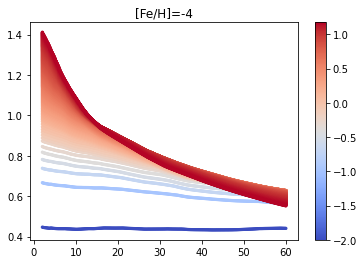

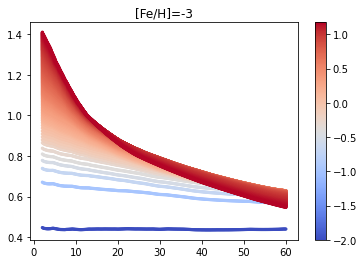

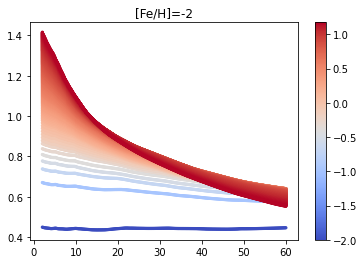

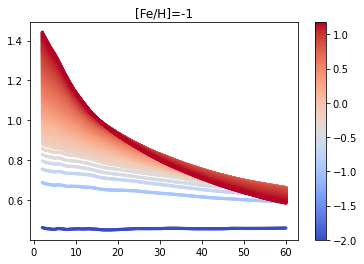

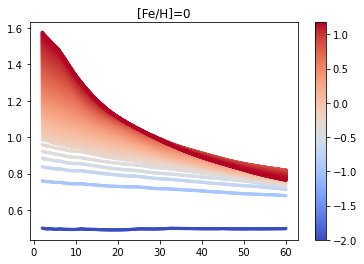

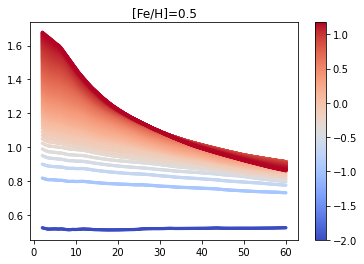

In [48]:
b=ml_bounds()
l_min, l_max = 0.01,15
for f_val in [-4,-3,-2,-1,0,0.5]:
    plt.figure()
    plt.title("[Fe/H]="+str(f_val))
    for l_val in np.arange(l_min,l_max,0.1):
        a_eval = norm(np.linspace(0,30e9,300), b.age_min,b.age_max)
        l_eval = norm(np.linspace(l_val,l_val,300), b.l_min,b.l_max)
        f_eval = norm(np.linspace(f_val,f_val,300), b.feh_min,b.feh_max)
        X=[]
        for a,c,d in zip(a_eval,l_eval,f_eval):
            X.append((a,c,d))
        plt.scatter(np.linspace(2e9,60e9,300)/1e9,norm_inv(regr.predict(X),b.mass_min, b.mass_max),s=5, cmap=CMAP,c=np.log10(norm_inv(l_eval,b.l_min,b.l_max)), vmin=np.log10(l_min), vmax=np.log10(l_max))
    plt.colorbar()

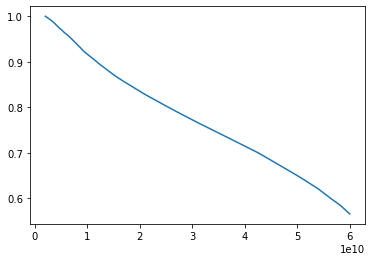

In [178]:
plt.plot(np.linspace(2e9,60e9,300),norm_inv(regr.predict(X),b.mass_min, b.mass_max))

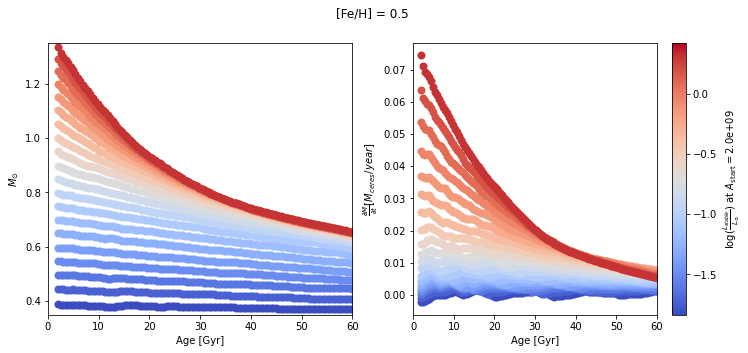

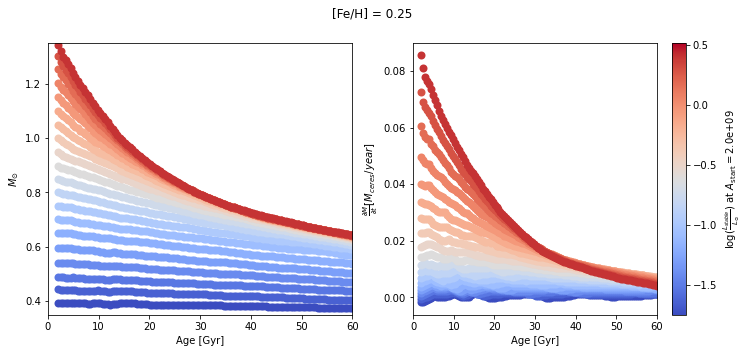

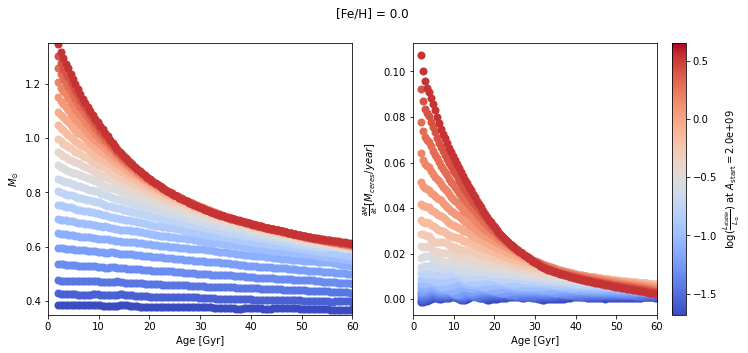

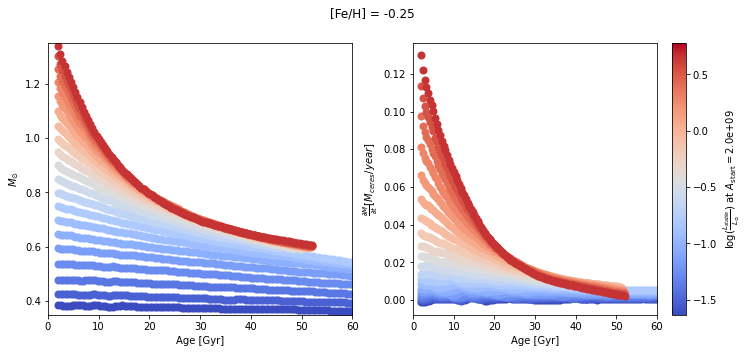

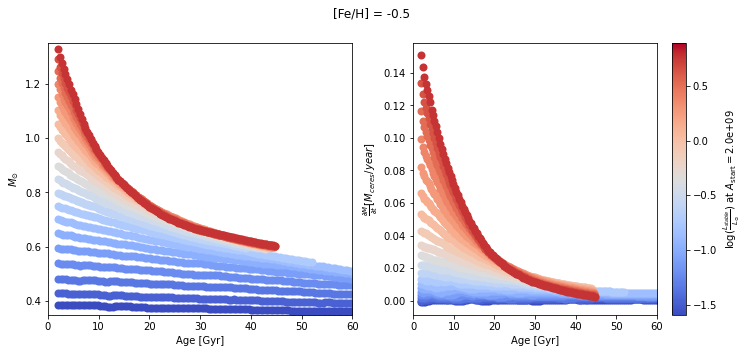

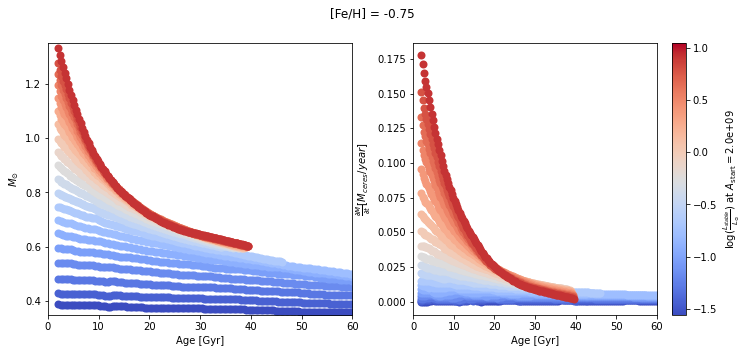

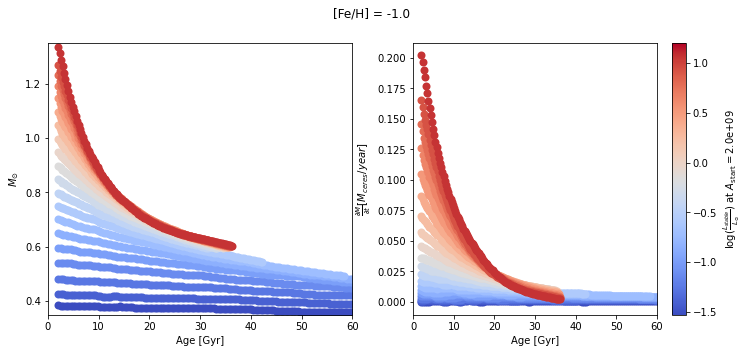

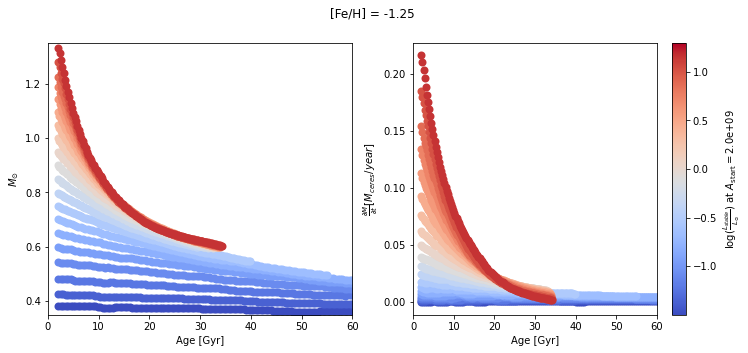

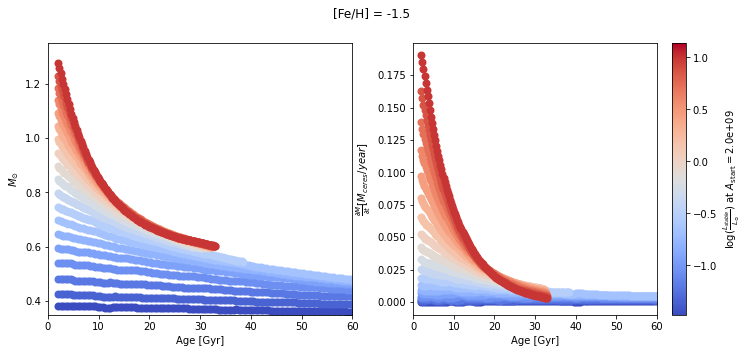

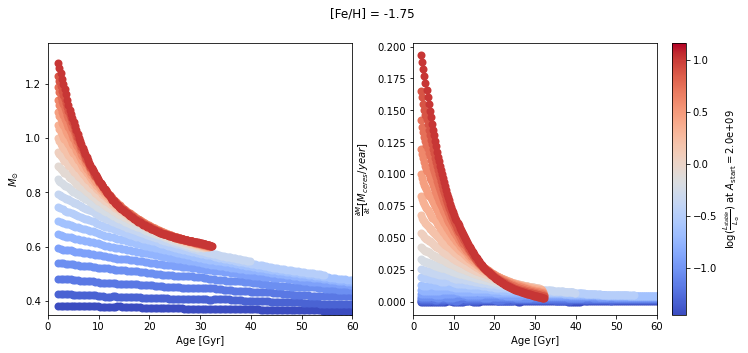

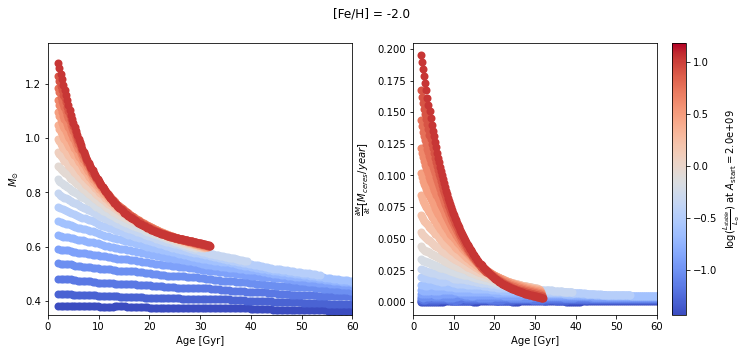

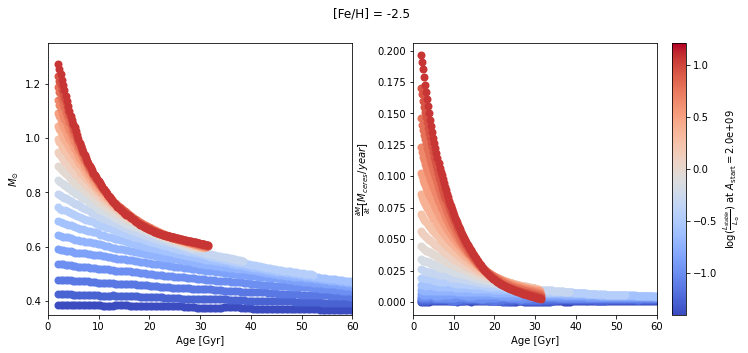

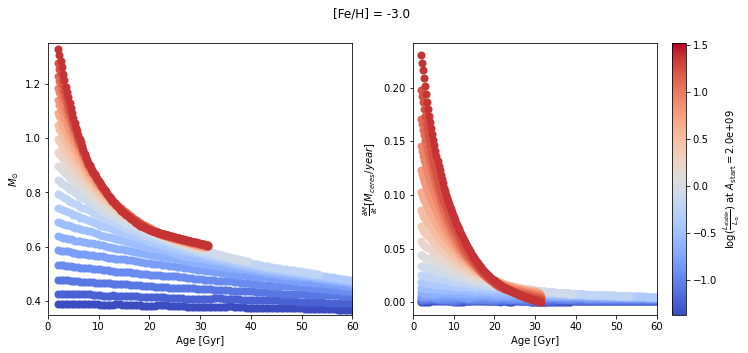

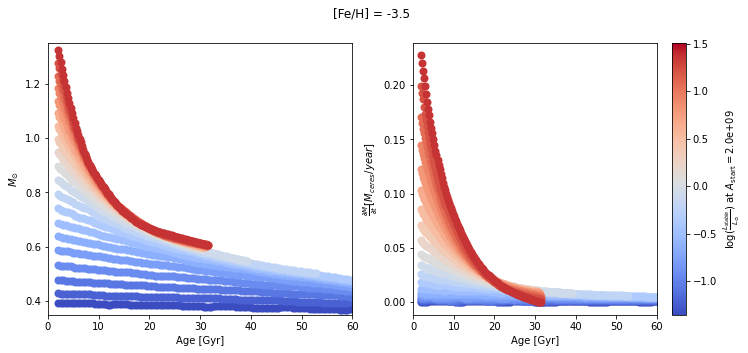

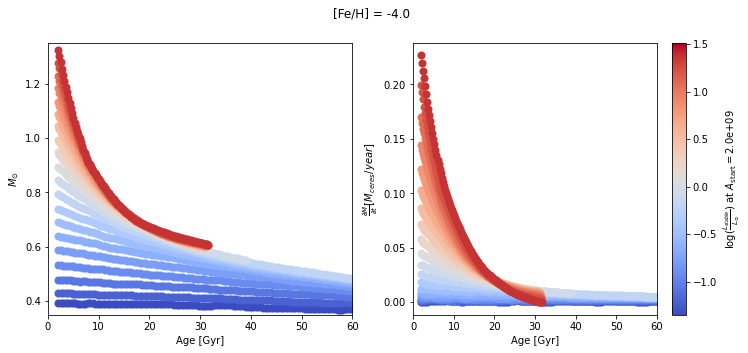

In [196]:
for i in range(len(all_indices)) :
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    
    for num,x in enumerate(all_indices[i]):
        pts = np.linspace(a_start, min(60e9,max(all_a[i][num])),120)
        
        m_predict,dmdt_predict,age_in,lum_in,feh_in = calc_ML([feh[i]],pts,[all_l_stables[i][x]])

        
        a,b,c = all_exp_fits[i][num]
        axs[0].scatter(pts/1e9, m_predict, color=CMAP(x/len(all_l_stables[i])), lw=2)
        axs[1].scatter(pts/1e9, dmdt_predict, color=CMAP(x/len(all_l_stables[i])), lw=2)
        #axs[1].plot(pts/1e9, -exp_der(pts,a,b,c)*m_sol/m_ceres, color=CMAP(x/len(all_l_stables[i])), lw=4)
        
    c = axs[1].scatter(np.zeros(len(all_l_stables[i])), np.zeros(len(all_l_stables[i])), cmap=CMAP, c=all_l_stables[i], s=0)
    axs[0].set_xlim(0,60)
    axs[0].set_ylim(m_eval[0]-0.05, m_eval[-1])
    axs[0].set_xlabel("Age [Gyr]")
    axs[0].set_ylabel(r"$M_{\odot}$")

    axs[1].set_xlim(0,60)
    axs[1].set_xlabel("Age [Gyr]")
    axs[1].set_ylabel(r"$\frac{\partial M}{\partial t} [M_{ceres}/year]$")
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(c, label=r"log($\frac{L_{stable}}{L_{\odot}}$) at $A_{\rm start}=$"+str(f"{a_start:.1e}"))    
    plt.suptitle("[Fe/H] = "+str(feh[i]))
    if(feh[i] < 0): feh_st = "m"+str(np.abs(feh[i]))
    else: feh_st = "p"+str(np.abs(feh[i]))
    plt.savefig("figures/ml_figs/feh_"+feh_st+".pdf")
    

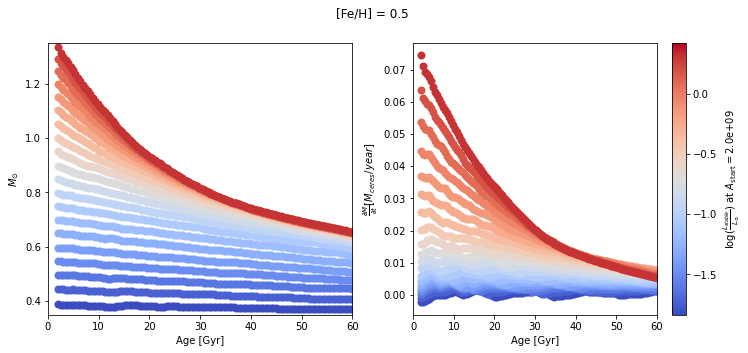

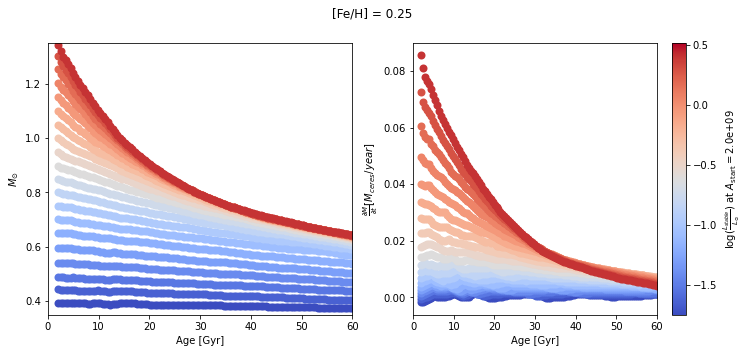

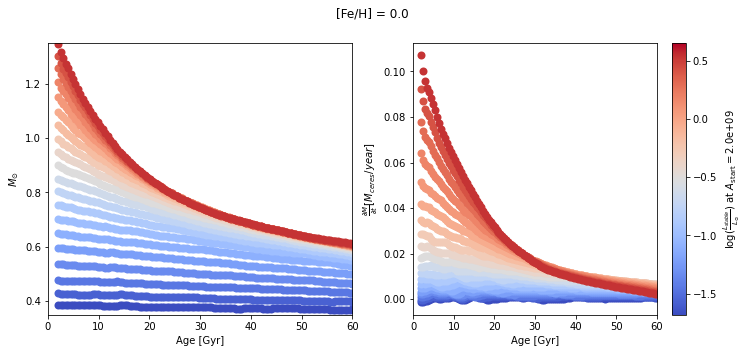

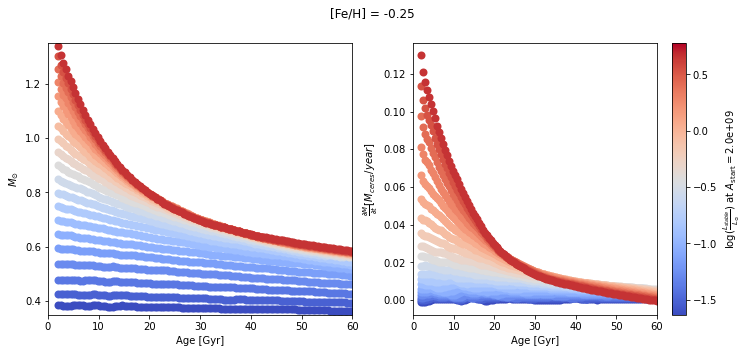

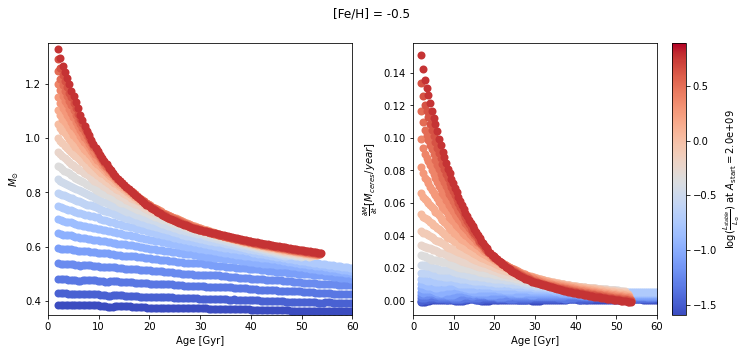

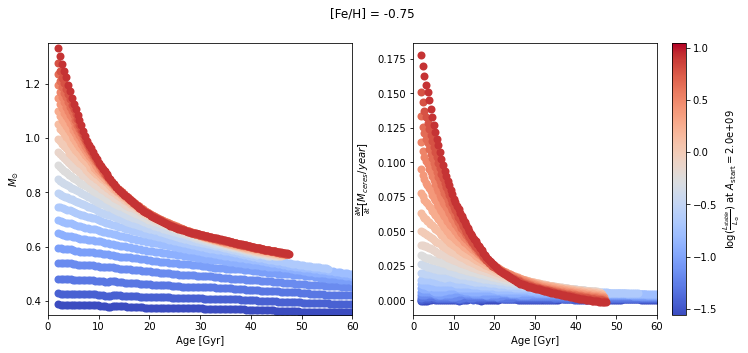

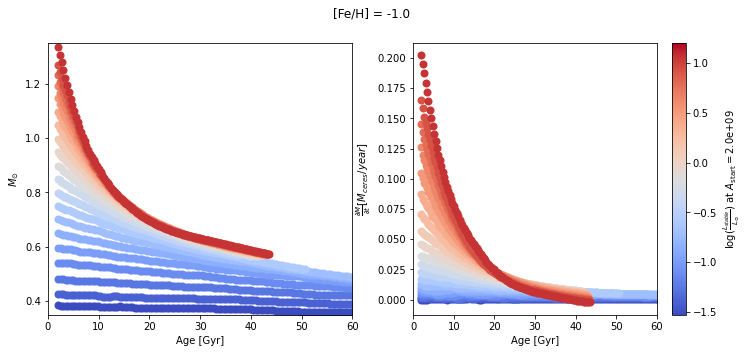

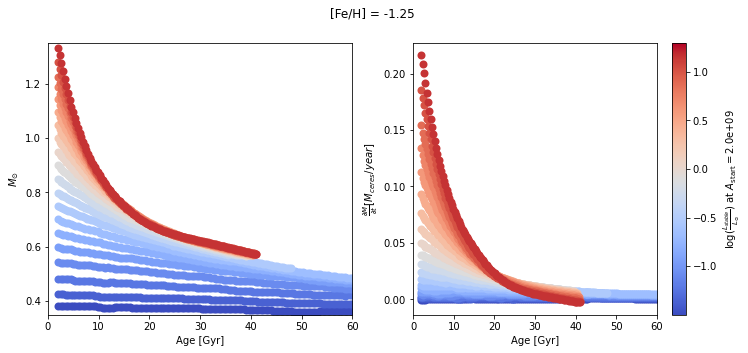

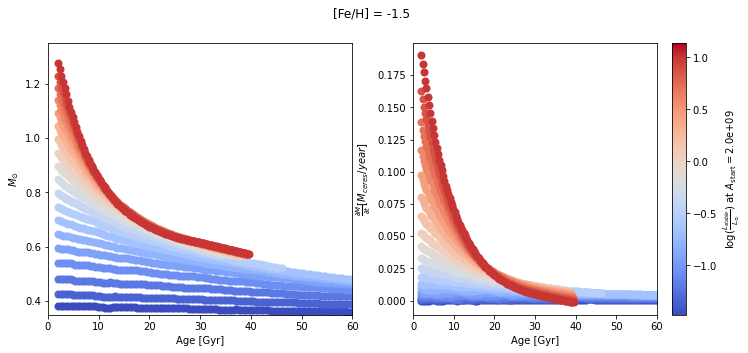

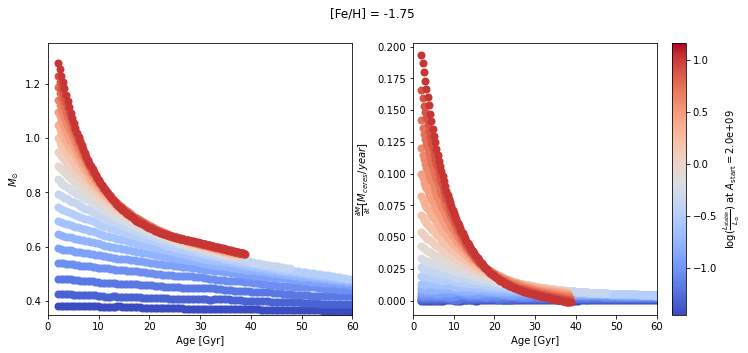

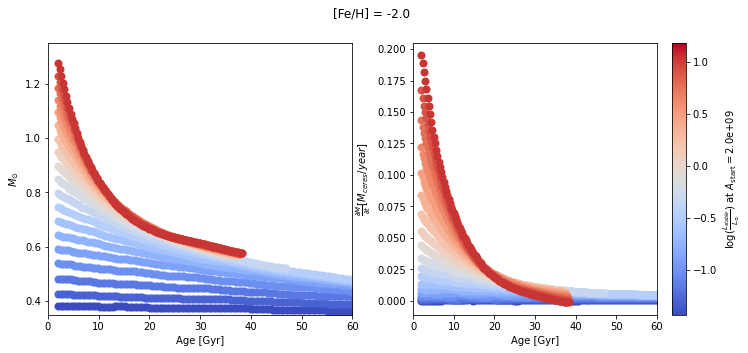

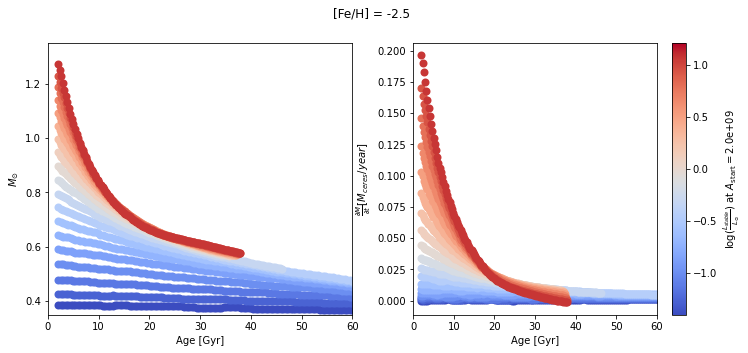

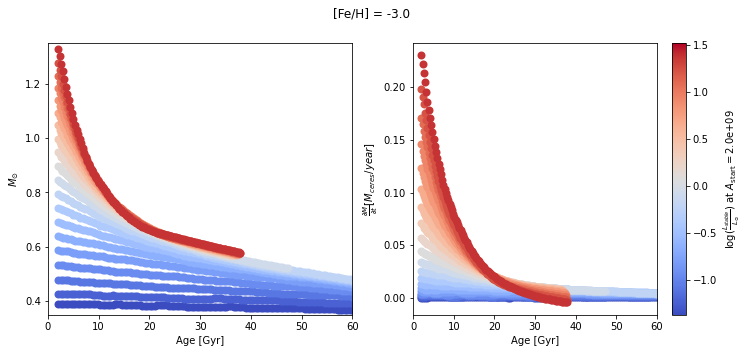

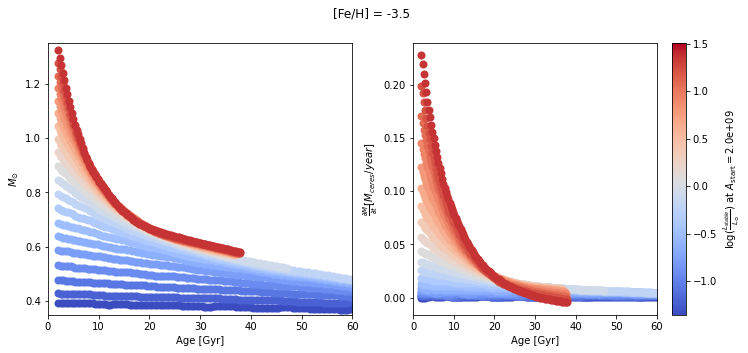

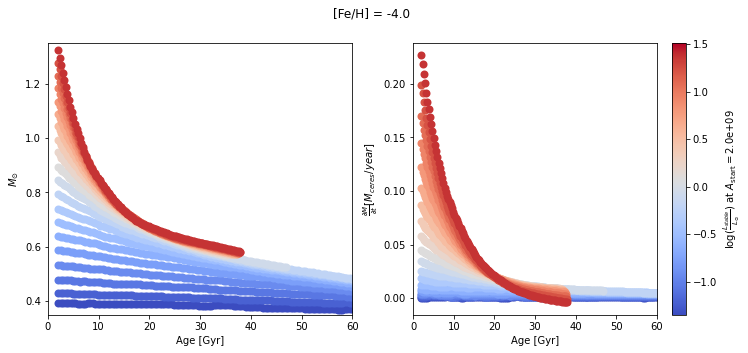

In [218]:
for i in range(len(all_indices)) :
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    
    for num,x in enumerate(all_indices[i]):
        pts = np.linspace(a_start, min(60e9,max(all_a[i][num])*1.2),120)
        
        m_predict,dmdt_predict,age_in,lum_in,feh_in = calc_ML([feh[i]],pts,[all_l_stables[i][x]])

        
        a,b,c = all_exp_fits[i][num]
        axs[0].scatter(pts/1e9, m_predict, color=CMAP(x/len(all_l_stables[i])), lw=2)
        axs[1].scatter(pts/1e9, dmdt_predict, color=CMAP(x/len(all_l_stables[i])), lw=2)
        #axs[1].plot(pts/1e9, -exp_der(pts,a,b,c)*m_sol/m_ceres, color=CMAP(x/len(all_l_stables[i])), lw=4)
        
    c = axs[1].scatter(np.zeros(len(all_l_stables[i])), np.zeros(len(all_l_stables[i])), cmap=CMAP, c=all_l_stables[i], s=0)
    axs[0].set_xlim(0,60)
    axs[0].set_ylim(m_eval[0]-0.05, m_eval[-1])
    axs[0].set_xlabel("Age [Gyr]")
    axs[0].set_ylabel(r"$M_{\odot}$")

    axs[1].set_xlim(0,60)
    axs[1].set_xlabel("Age [Gyr]")
    axs[1].set_ylabel(r"$\frac{\partial M}{\partial t} [M_{ceres}/year]$")
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(c, label=r"log($\frac{L_{stable}}{L_{\odot}}$) at $A_{\rm start}=$"+str(f"{a_start:.1e}"))    
    plt.suptitle("[Fe/H] = "+str(feh[i]))
    if(feh[i] < 0): feh_st = "m"+str(np.abs(feh[i]))
    else: feh_st = "p"+str(np.abs(feh[i]))
    plt.savefig("figures/ml_figs/feh_"+feh_st+".pdf")
    

# Checking m vs a against another set of evolutionary tracks


In [102]:
def get_geneva_data(file):
    f = open(file)
    age_full, mass_full, log_L_full, log_T_full = [],[],[],[]
    a=[]
    for i,line in enumerate(f):
        if(i==0): continue
        if("Isochrone" in line): 
            age = float(line.split()[-1])
            new_track = True
            continue
        if(new_track):
            if(len(a) > 0):
                age_full.append(a)
                mass_full.append(m)
                log_L_full.append(l)
                log_T_full.append(t)
            a,m,l,t = [],[],[],[]
        
        s=line.split()
        if(s==[]): continue
        mass, log_T, log_L = float(s[0]), float(s[3]), float(s[4])
        a.append(age), m.append(mass), l.append(log_L), t.append(log_T)            
        new_track = False
        
    return age_full,mass_full,log_L_full, log_T_full

file1, file2 = "geneva_data/low_mass.dat", "geneva_data/medium_mass.dat"        
log_age_full,mass_full,log_L_full, log_T_full = get_geneva_data(file1)
age_full = [[10**a for a in list_] for list_ in log_age_full]

age_filt = np.where(np.array([xi[0] for xi in log_age_full]) >7.7)
age_full1, mass_full1, log_L_full1 = np.array(age_full)[age_filt].tolist(), np.array(mass_full)[age_filt].tolist(), np.array(log_L_full)[age_filt].tolist()


log_age_full,mass_full,log_L_full, log_T_full = get_geneva_data(file2)
age_full = [[10**a for a in list_] for list_ in log_age_full]

age_filt = np.where(np.array([xi[0] for xi in log_age_full]) >7.7)
age_full2, mass_full2, log_L_full2 = np.array(age_full)[age_filt].tolist(), np.array(mass_full)[age_filt].tolist(), np.array(log_L_full)[age_filt].tolist()

<ipython-input-102-847deb429fab>:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  age_full1, mass_full1, log_L_full1 = np.array(age_full)[age_filt].tolist(), np.array(mass_full)[age_filt].tolist(), np.array(log_L_full)[age_filt].tolist()
<ipython-input-102-847deb429fab>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  age_full2, mass_full2, log_L_full2 = np.array(age_full)[age_filt].tolist(), np.array(mass_full)[age_filt].tolist(), np.array(log_L_full)[age_filt].tolist()


In [98]:
a_sol = 4.603e9
m_sol = 1.98847e30
m_ceres = 9.1e20
time = np.linspace(4e9,6e10,30)
CMAP = plt.cm.coolwarm
mass_range = np.arange(0.6,1.2,0.05)
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels

In [103]:
mass_gen1 =[]
age_gen1 = []
for log_l, mass, a in  zip(log_L_full1, mass_full1, age_full1):
    isoirr = np.power(10,np.array(log_l))*np.power(mass,2)
    if(is_in(1, isoirr)):
        mass_gen1.append(interp1d(isoirr1,mass, kind="linear")(1))
        age_gen1.append(a[0])

In [104]:
mass_gen2 =[]
age_gen2 = []
for log_l, mass, a in  zip(log_L_full2, mass_full2, age_full2):
    isoirr = np.power(10,np.array(log_l))*np.power(mass,2)
    if(is_in(1, isoirr)):
        mass_gen2.append(interp1d(isoirr,mass, kind="linear")(1))
        age_gen2.append(a[0])

In [118]:
mass_mist =[]
age_mist = []
for log_l, mass, age in  zip(all_L[1], all_mass[1], all_ages[1]):
    isoirr = np.power(10,np.array(log_l))*np.power(mass,2)
    if(is_in(1, isoirr)):
        mass_mist.append(interp1d(isoirr,mass, kind="linear")(1))
        age_mist.append(interp1d(isoirr,age, kind="linear")(1))

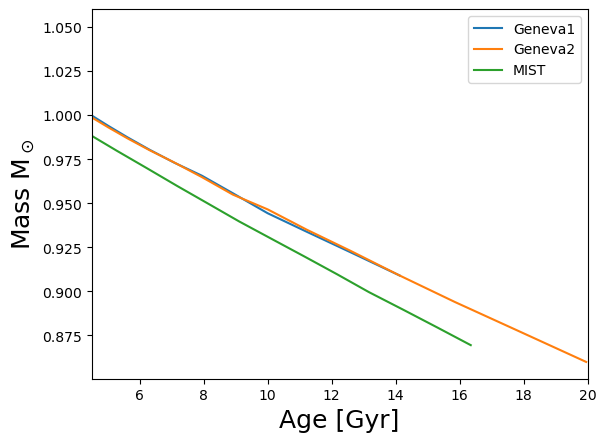

In [121]:
plt.plot(np.array(age_gen1)/1e9,mass_gen1,label="Geneva1")
plt.plot(np.array(age_gen2)/1e9,mass_gen2,label="Geneva2")
plt.plot(np.array(age_mist)/1e9,mass_mist,label="MIST")
plt.xlim(4.5,20)
plt.legend()
plt.xlabel("Age [Gyr]")
plt.ylabel(r"Mass ${\rm M}_\odot$")
plt.savefig("figures/gen_vs_mist.pdf")




### Checking the phases vs luminosity, deciding to stick with MS phase (phase == 0)

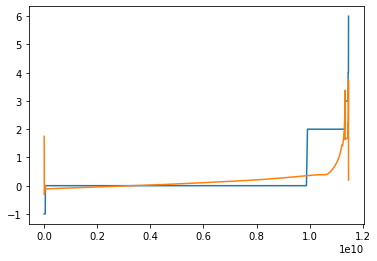

In [126]:
df = pd.read_csv("MIST_data/0010000M.track.eep", skiprows=11, delim_whitespace=True)
df
plt.plot(df["star_age"], df["phase"])
plt.plot(df["star_age"], df["log_L"])

# F-star investigation (old, allowing for red giant phase)

In [204]:
i=np.where(np.abs(np.array(feh)+4) < 0.01)[0][0]
j=np.argmax(np.array(all_l_stables[i]))

pts = np.linspace(a_start,60e9,500)
m_predict,dmdt_predict,age_in,lum_in,feh_in = calc_ML([feh[i]],pts,[2.5-1])
fit_ages, fit_masses = all_a[i][j]/1e9, all_m[i][j]

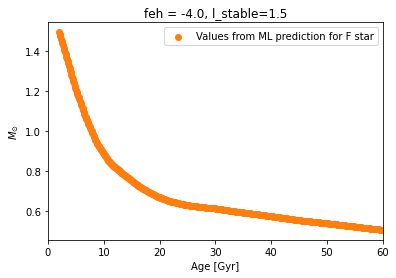

In [206]:
b=ml_bounds()
normalize = matplotlib.colors.Normalize(vmin=b.l_min, vmax=b.l_max)
plt.scatter(np.array(pts)/1e9, m_predict, c="tab:orange", label="Values from ML prediction for F star")
plt.xlabel("Age [Gyr]")
plt.ylabel(r"$M_{\odot}$")
plt.legend()
plt.xlim(0,60)
plt.title("feh = "+str(feh[i])+", l_stable="+str(2.5-1))
plt.savefig("figures/m_vs_a_for_f_star.pdf")

# Checking that a*M = constant for radius a and mass M (I'm worried I've forgotten something in the angular momentum consideration). Results show that $M\propto$ $\frac{1}{a}$

# Graveyard (things I'll probably never use again, but keeping just in case)

0.9999973742716832


<Figure size 432x288 with 0 Axes>

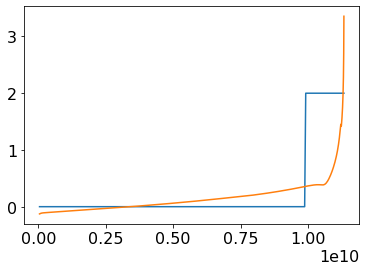

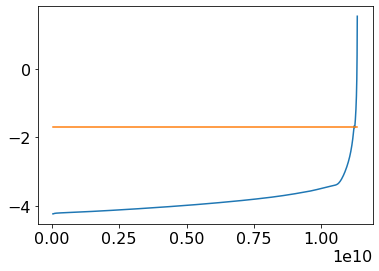

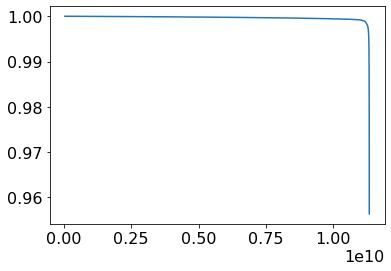

<Figure size 432x288 with 0 Axes>

In [210]:
all_tracks, feh = get_MIST_tracks_and_feh(feh_range=[-0.1,0.1])
#all_tracks, feh = get_MIST_tracks_and_feh(feh_range=[-0.1,0.1])
all_ages, all_mass, all_L,all_T, all_ages_full, all_mass_full, all_L_full,all_phases_full, all_T_full, all_dmdt = get_all_MIST_data2(all_tracks, clean=False,verbose=False)

star_id = 90
filter_ = np.where((all_phases_full[0][star_id] <2.5) & (all_phases_full[0][star_id] > -0.1))
age_sol  = all_ages_full[0][star_id][filter_]
mass_sol = all_mass_full[0][star_id][filter_]
dmdt_sol = all_dmdt[0][star_id][filter_]
lum_sol = all_L_full[0][star_id][filter_]
phase_sol = all_phases_full[0][star_id][filter_]
print(mass_sol[0])
plt.figure()
plt.plot(age_sol, phase_sol)
plt.plot(age_sol, lum_sol)
plt.figure()
plt.plot(age_sol, np.log10(-dmdt_sol*m_sol/m_ceres))
plt.plot([min(age_sol),max(age_sol)], [np.log10(0.02),np.log10(0.02)])
plt.figure()
plt.plot(age_sol, mass_sol)
plt.figure()

C:\Users\Matthew\AppData\Local\Temp/ipykernel_32888/2771052732.py:56: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  if(isoirr):fig.colorbar(c, label=r"${\rm log}_{10}(F_{\rm inc}/{\rm F}_\oplus)$",orientation="horizontal", pad=0.2)


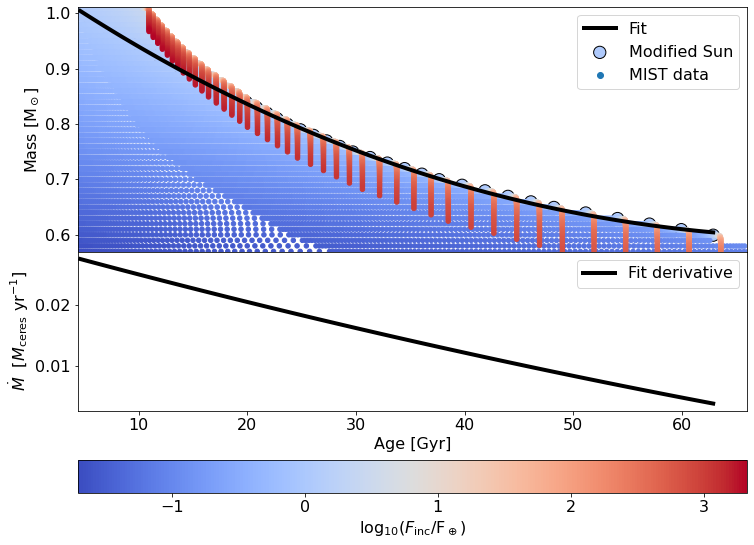

C:\Users\Matthew\AppData\Local\Temp/ipykernel_32888/2771052732.py:57: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  else: plt.colorbar(c,label=r"${\rm log}_{10}(L/{\rm L}_\odot)$",orientation="horizontal", pad=0.2)


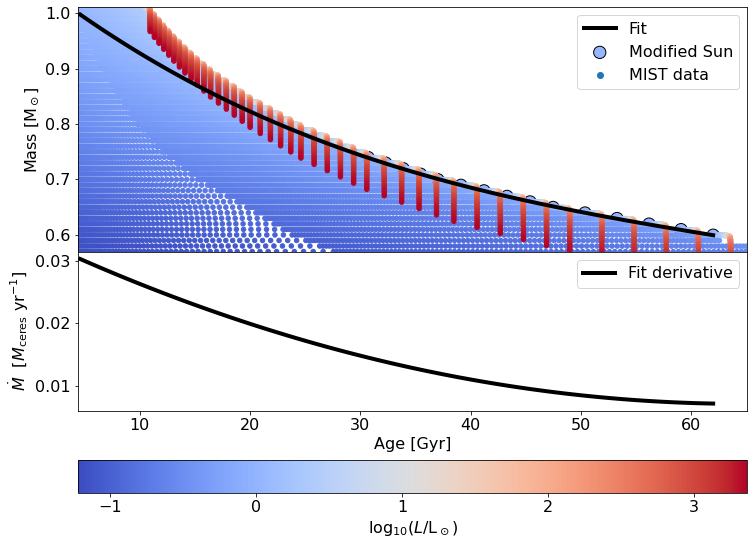

In [209]:
plt.rc('font', size=16)    # fontsize of the x and y labels
for isoirr in [True,False]:

    
    i=0

    a_start = a_sol #the age when starlifting starts
    m_eval = np.arange(1.0,1.01,0.05)
    all_l_stables, all_a, all_m, all_fits,all_indices = get_m_vs_a(all_ages, all_mass, all_T,all_L,feh,m_eval,a_start,isoirr=isoirr,poly=POLY)
    a_sun, m_sun, fit_sun, l_stable_sun = all_a[i][0], all_m[i][0], all_fits[i][0], all_l_stables[i][0]
    pts = np.linspace(a_sun[0],a_sun[-1], 100)

    
    
    m_min, m_max = 0.95*m_sun[-1], 1.011*m_sun[0]

    fig, axs = plt.subplots(2,1, figsize=(12,9),sharex=True)
    plt.subplots_adjust(wspace=0, hspace=0)

    vmax, vmin = 0,0
    
    if(isoirr):
        for mass,age,log_l,temp in zip(all_mass[i], all_ages[i], all_L[i], all_T[i]):
            if(mass[0] > m_max or mass[0] < m_min): continue
            else: 
                vmax = max(vmax, np.max(np.log10(np.power(10,log_l)*np.power(mass,2))))
                vmin = min(vmin, np.min(np.log10(np.power(10,log_l)*np.power(mass,2))))
    else:
        for mass, log_l in zip(all_mass[i], all_L[i]):
            if(mass[0] > m_max or mass[0] < m_min): continue
            else: 
                vmax = max(vmax, np.max(log_l))
                vmin = min(vmin, np.min(log_l))
                


    if(isoirr): scatter_col =  np.log10(np.linspace(l_stable_sun,l_stable_sun,len(m_sun)))
    else: scatter_col = np.linspace(l_stable_sun,l_stable_sun,len(m_sun))
    axs[0].scatter(a_sun/1e9, m_sun, label="Modified Sun", cmap=CMAP, c=scatter_col,s=150,edgecolors='black', vmin=vmin, vmax=vmax)
    axs[0].set_ylabel(r"Mass [${\rm M}_\odot$]")
    axs[0].set_xlim(0.95*a_sun[0]/1e9,1.05*a_sun[-1]/1e9)
    axs[0].set_ylim(m_min, m_max)
    
    if(isoirr): txt_str = "Isoirradiance\n"+r"[Fe/H]${=}$"+str(feh[i])
    else: txt_str = "Isoluminosity\n"+r"[Fe/H]${=}$"+str(feh[i])
    #plt.text(2.5, 1.9, txt_str, horizontalalignment='right',verticalalignment='top', transform=ax.transAxes)


    for mass,age,log_l,temp in zip(all_mass[i], all_ages[i], all_L[i], all_T[i]):
        if(mass[0] > m_max or mass[0] < m_min): continue
        
        if(isoirr): col = np.log10(np.power(10,log_l)*np.power(mass,2))
        else: col = log_l
        c = axs[0].scatter(age/1e9,mass, cmap=CMAP, c=col,s=20, vmin=vmin, vmax=vmax)  
        
    if(isoirr):fig.colorbar(c, label=r"${\rm log}_{10}(F_{\rm inc}/{\rm F}_\oplus)$",orientation="horizontal", pad=0.2)
    else: plt.colorbar(c,label=r"${\rm log}_{10}(L/{\rm L}_\odot)$",orientation="horizontal", pad=0.2)

        
        
        
    axs[0].scatter(0,0,label="MIST data",cmap=CMAP)
    axs[0].plot(pts/1e9, np.poly1d(fit_sun)(pts), label="Fit",color="black",lw=4)
    axs[0].legend()

    axs[1].plot(pts/1e9, -np.polyder(np.poly1d(fit_sun))(pts)*m_sol/m_ceres, color="black",lw=4, label="Fit derivative")
    axs[1].set_ylabel(r"$\dot{M}$  [$M_{\rm ceres} \ {\rm yr}^{-1}$]")
    axs[1].legend()
    #axs[1].set_yticks([0.022,0.023,0.024,0.025])
    axs[1].set_xlabel("Age [Gyr]")

    plt.savefig("figures/PHASE2worked_example_astart="+str(a_start)+"isoirr="+str(isoirr)+".pdf",bbox_inches='tight')
    plt.show()

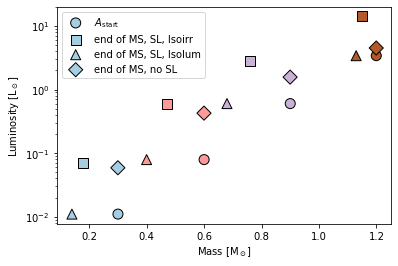

In [90]:

# plt.plot(init_mass, final_mass)
# plt.plot([0,1.3], [0,1.3])
# plt.ylabel("final")
# plt.xlabel("initial")
# plt.title("iroirr")



plt.figure()
plt.scatter(init_mass, init_l, c = init_mass, cmap=CMAP2, edgecolors ="black", s=100, label=r"$A_{\rm start}$")
plt.scatter(final_mass, final_l, c = init_mass, cmap=CMAP2, marker="s",edgecolors ="black", s=100, label="end of MS, SL, Isoirr")
plt.scatter(final_mass_isolum,final_l_isolum, c = init_mass, cmap=CMAP2, marker="^",edgecolors ="black", s=100, label="end of MS, SL, Isolum")
plt.scatter(final_m_natural, final_l_natural, c = init_mass, cmap=CMAP2, marker="D",edgecolors ="black", s=100, label="end of MS, no SL")
#plt.colorbar(label=r"Initial Mass [${\rm M}_\odot$]")
plt.xlabel(r"Mass [${\rm M}_\odot$]")
plt.ylabel(r"Luminosity [${\rm L}_\odot$]")
plt.legend()
plt.yscale("log")
plt.savefig("figures/strange_HR.pdf")

In [3]:
def calc_a(ps,n,m): 
    a=np.array([0.0,0.0])
    l = list(range(N))
    l.remove(n)
    for i in l:
        p1,p2=ps[n],ps[i]
        dist = get_dist(p1, p2)
        a+= G*m[i]*(p2 - p1)/np.power(dist,3)
    return a

def get_dist(p1,p2):
    return np.sqrt(np.sum(np.power(p1-p2,2),axis=0)) 

def calc_kinetic(vs,m,N):
    k=0
    for x in range(N): k+= 0.5*m[x]*np.sum(np.power(vs[x],2))
    return k

def calc_potential(ps,m,N):
    u=0
    for x in range(N):
        for y in range(N):
            if(x!=y): u-=G*m[x]*m[y]/(get_dist(ps[x],ps[y]))
    return u
    
def evolve_leap_frog(ps,vs,m1,m2,N,dt, t_max):
    p = np.array(ps)
    k = [calc_kinetic(vs,m1,N)]
    u = [calc_potential(ps,m1,N)]
    for n in range(N): vs[n] += (dt/2)*calc_a(ps,n,m1)
    t_s = 4*t_year
    t_e = 30*t_year
    for t in np.arange(0,t_max,dt):
        if(t<t_s): m=m1
        elif(t<t_e): m =list(np.array(m1)*(t_e-t)/(t_e-t_s) + np.array(m2)*(t-t_s)/(t_e-t_s))
        else: m=m2
        for n in range(N): ps[n] += dt*vs[n]
        for n in range(N): vs[n] += dt*calc_a(ps,n,m)
        p = np.concatenate((p,np.array(ps)),axis=1)
        k.append(calc_kinetic(vs,m,N))
        u.append(calc_potential(ps,m,N))
    return p, np.arange(0,t_max+dt/2,dt),k,u
  
    
    
    
AU = 1.496e+11 #meters
box_size = 20*AU #
N=2
dim = 2
m1 = [2e30, 6e24]
m2 = [0.8e30, 6e24]
G=6.26e-11
dt=2e4 #seconds
t_year=3.154e+7 #seconds per year
t_max=40*t_year
ps = [(0.0,0.0), (AU,0.0)]
vs = [(0.0,0.0),(0.0,np.sqrt(G*2e30/AU))]

for x in range(len(ps)): ps[x]=np.array(ps[x])
for x in range(len(vs)): vs[x]=np.array(vs[x])
p,t,k,u = evolve_leap_frog(ps,vs,m1,m2,N,dt,t_max)


p1x = p[0][0::2]
p1y = p[0][1::2]
p2x = p[1][0::2]
p2y = p[1][1::2]
plt.scatter(p2x,p2y,s=5,c=t, cmap=cm.coolwarm)
plt.scatter(p1x,p1y,s=5,c=t, cmap=cm.coolwarm)
plt.colorbar(label="time(s)")
plt.xlabel("x(m)")
plt.ylabel("y(m)")

r_final = np.sqrt(p2x[-1]*p2x[-1] + p2y[-1]*p2y[-1])
r_init = AU
m_final, m_init = 0.8e30,2e30
print(m_final*r_final)
print(m_init*r_init)

#roughly the same, so M*a constant holds

1261600000.0


In [85]:
def get_adjacent_indices(value, arr):
    arr=np.array(arr)
#     if(np.sort(arr) != arr):
#         print("ERR")
#         return
    low,upp = 0,0
    for x in range(1,len(arr)):
        #print(value/1e9,arr[x]/1e9)
        if(value<arr[x] and value>arr[x-1]):
            #print(x-1,x)
            low = x-1
            upp = x
           # print(low,upp)
            return low,upp
    print("ERROR") 
    return -1,-1
            
        
    

In [77]:

index = 1
a_temp = all_a[index]
m_temp = all_m[index]


plt.scatter(a_temp[-1]/1e9, m_temp[-1])
plt.ylabel("mass")
plt.xlabel("Gyr")
pts = np.linspace(a_start, min(20e9,max(a_temp[-1])),120)
poly = np.polyfit(a_temp[-1], m_temp[-1],DEGREE_OF_FIT)
plt.plot(pts/1e9, np.poly1d(poly)(pts), lw=5)
plt.savefig("figures/mvsa_example.pdf")


plt.figure()
#plt.xlim(0,5)
plt.ylabel("dm/dt")
plt.xlabel("Gyr")
plt.plot(pts/1e9, -np.polyder(np.poly1d(poly))(pts), lw=3.5, label = "dmdt from poly")
#plt.scatter(all_a[0][-1], all_m[0][-1])
for x in range(len(a_temp[-1])):
    a,m = a_temp[-1], m_temp[-1]
    eval_ = np.linspace(a[0]+100000, a[-1]-100000,100)
    low, upp = 0,1
    slopes = []
    for x in eval_:
        low, upp = get_adjacent_indices(x, a)
        slope = -(m[upp]-m[low])/(a[upp] - a[low])
        slopes.append(slope)
plt.scatter(eval_/1e9, slopes, c="tab:orange",label="slope using adjacent points")
fit = np.polyfit(eval_,slopes,2)
plt.plot(eval_/1e9,  np.poly1d(fit)(eval_),c="tab:orange", label="fit to raw slope")
plt.legend(fontsize=10)
plt.savefig("figures/dmdt_example.pdf")



plt.plot(all_ages[1][115]/1e9,all_mass[1][115], label="no SL")
plt.plot(pts/1e9, np.poly1d(poly)(pts), lw=5, label="with SL")
plt.legend()
plt.savefig("figures/SL_vs_noSL_example.pdf")


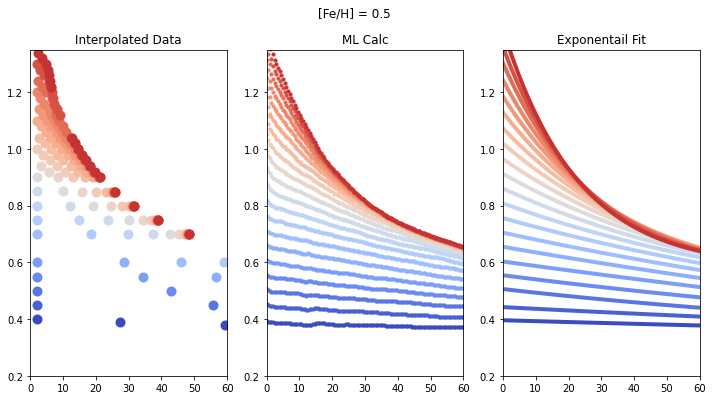

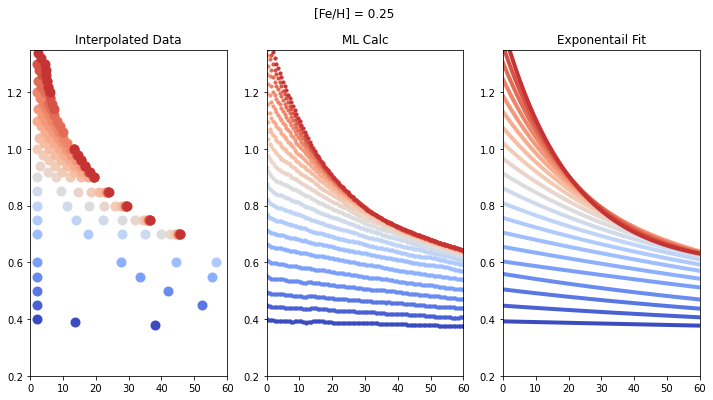

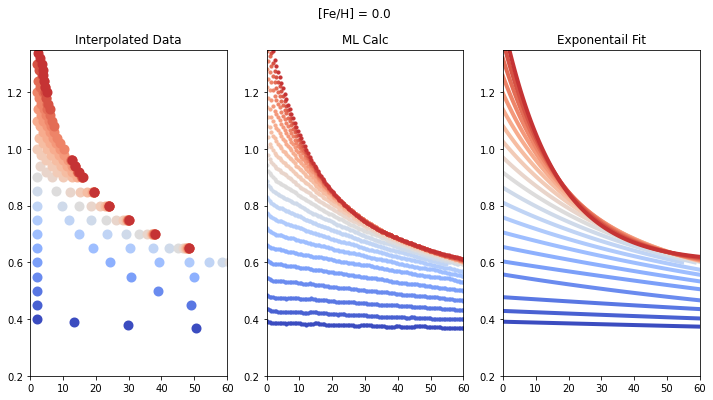

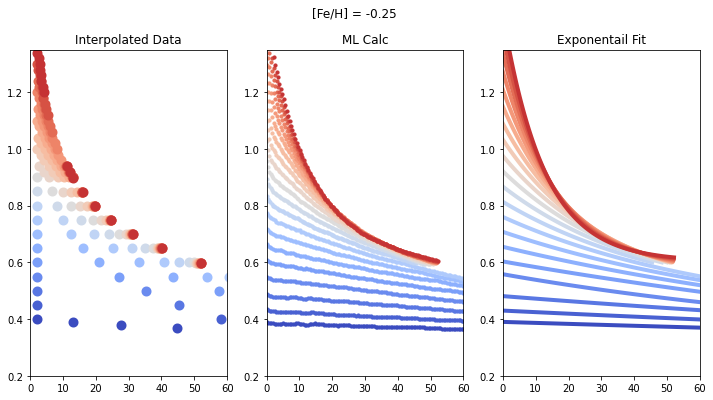

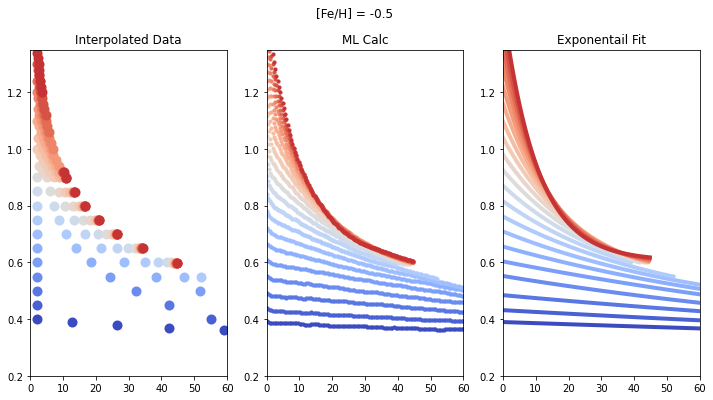

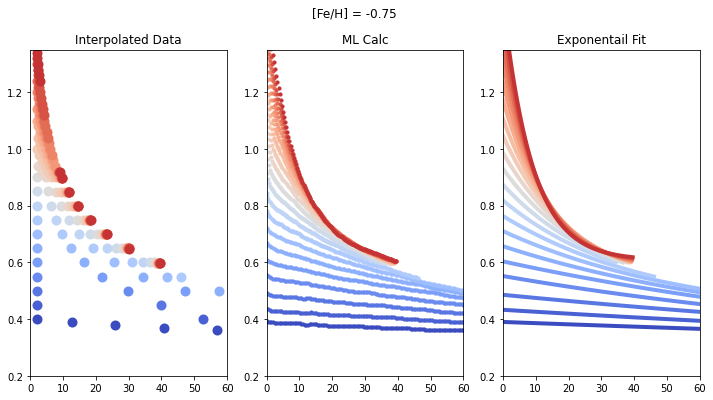

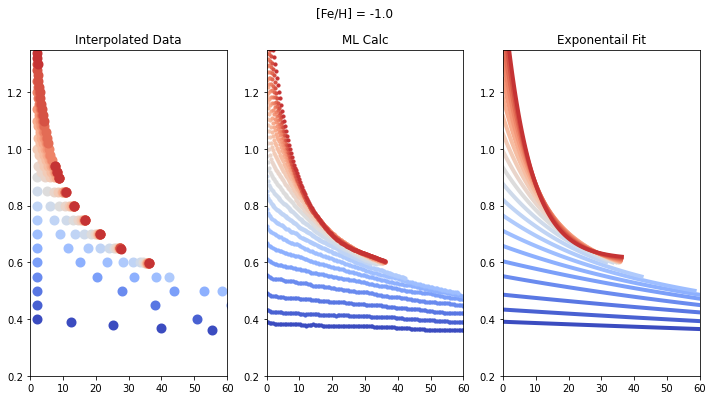

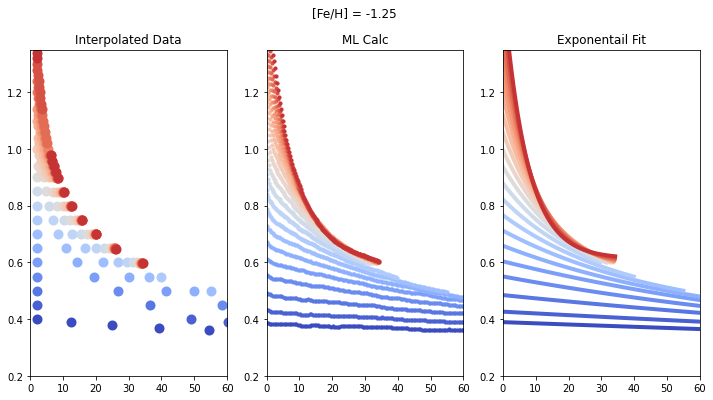

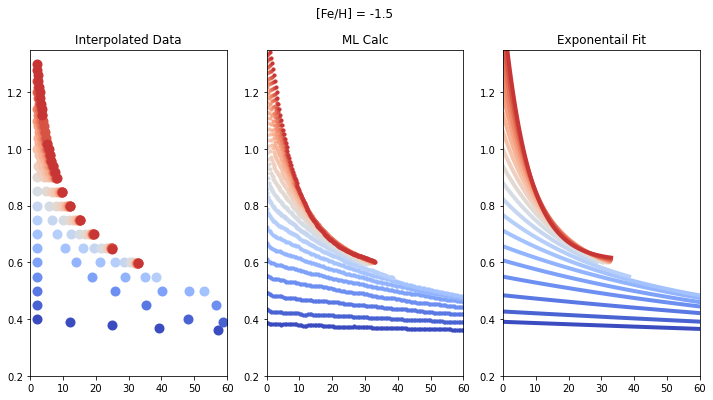

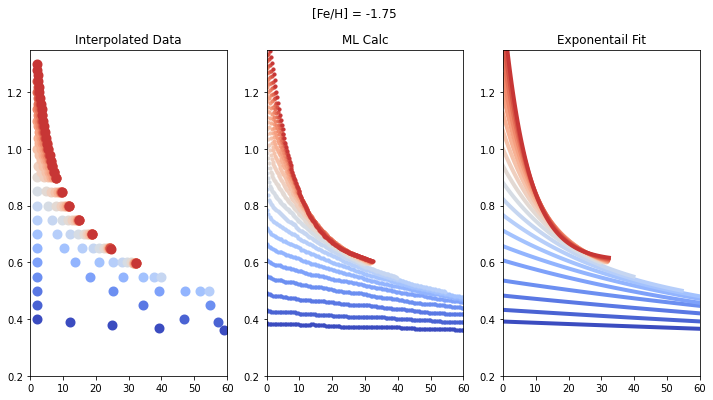

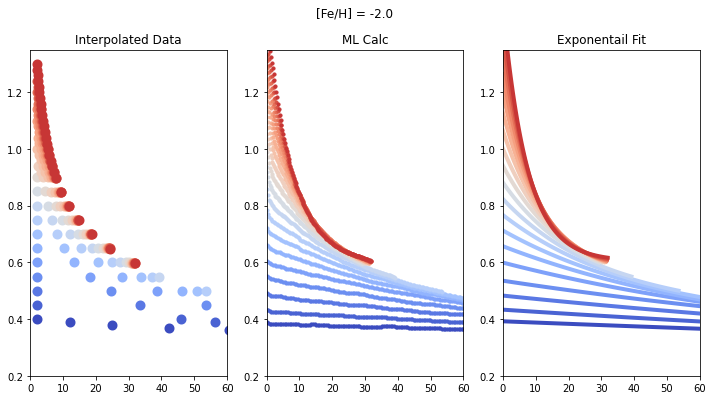

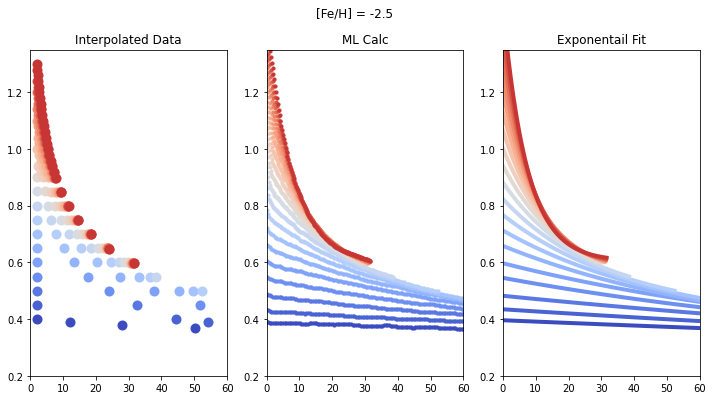

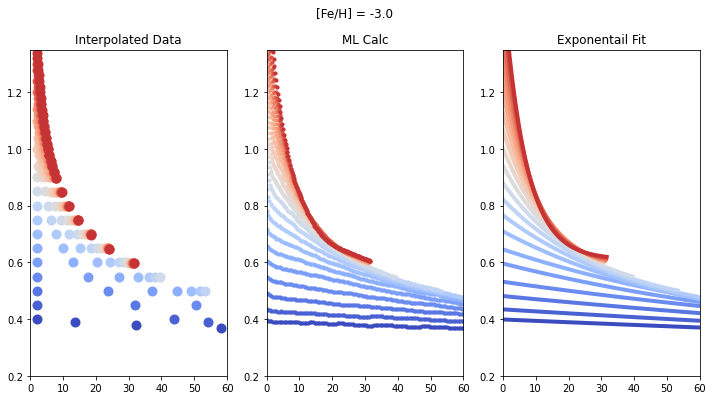

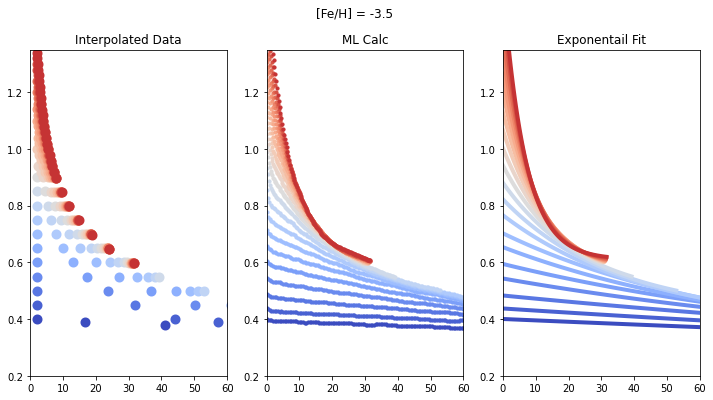

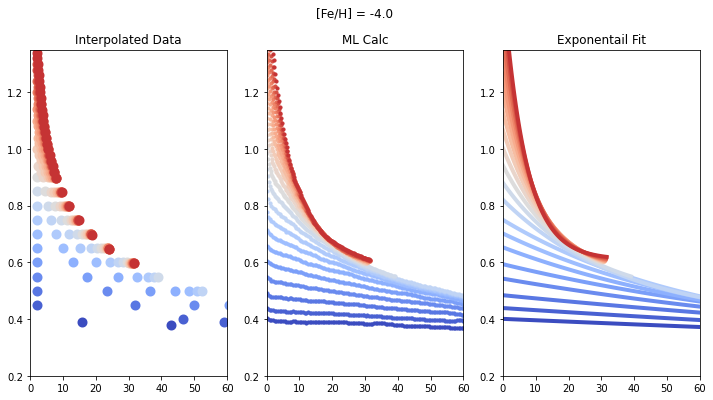

In [161]:
for i in range(len(all_indices)):
    fig, axs = plt.subplots(1,3, figsize=(12,6))
    for num,x in enumerate(all_indices[i]):

        pts = np.linspace(0, min(60e9,max(all_a[i][num])),120)
        axs[0].scatter(all_a[i][num]/1e9, all_m[i][num], color=CMAP(x/len(all_l_stables[i])), lw=4)


        m_predict,age_in,lum_in,feh_in = calc_ML([feh[i]],pts,[all_l_stables[i][x]])


        axs[1].scatter(age_in/1e9, m_predict, color=CMAP(x/len(all_l_stables[i])), s=10)
        a,b,c = all_exp_fits[i][num]
        #axs[2].scatter(age_in/1e9, m_predict, color=CMAP(x/len(all_l_stables[i])), s=15, alpha=0.5)

        axs[2].plot(pts/1e9, exp(pts,a,b,c), color=CMAP(x/len(all_l_stables[i])), lw=4)
    titles = ["Interpolated Data", "ML Calc", "Exponentail Fit"]
    for x in range(3): 
        axs[x].set_xlim(0,60)
        axs[x].set_ylim(m_eval[0]-0.2, m_eval[-1])
        axs[x].set_title(titles[x])

    plt.suptitle("[Fe/H] = "+str(feh[i]))

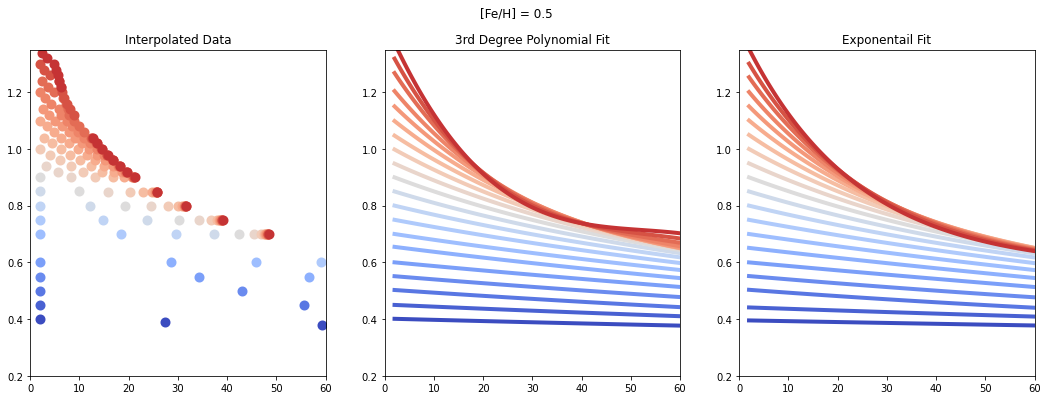

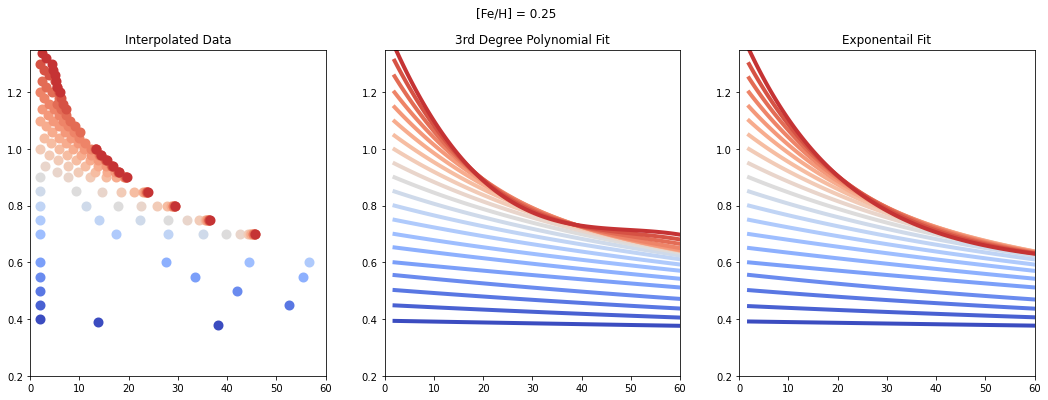

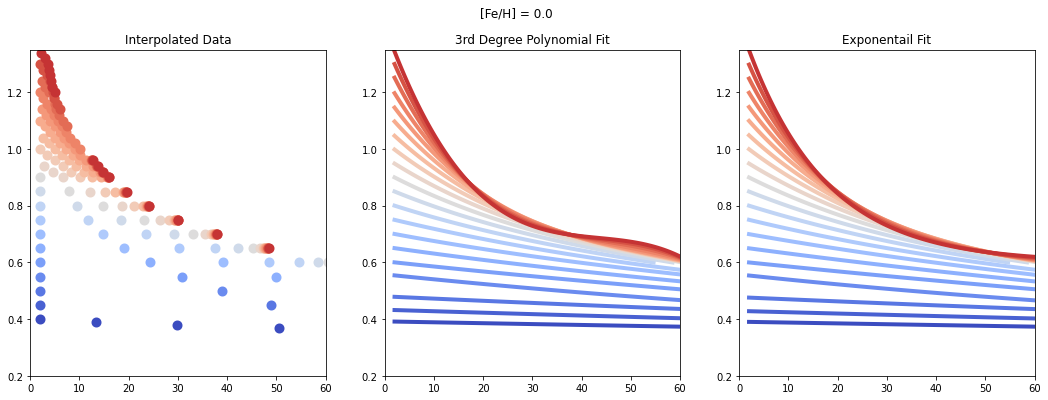

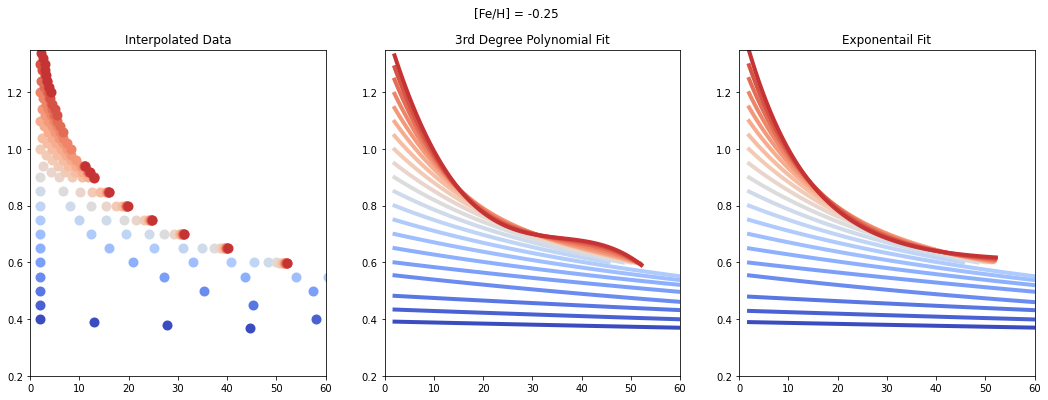

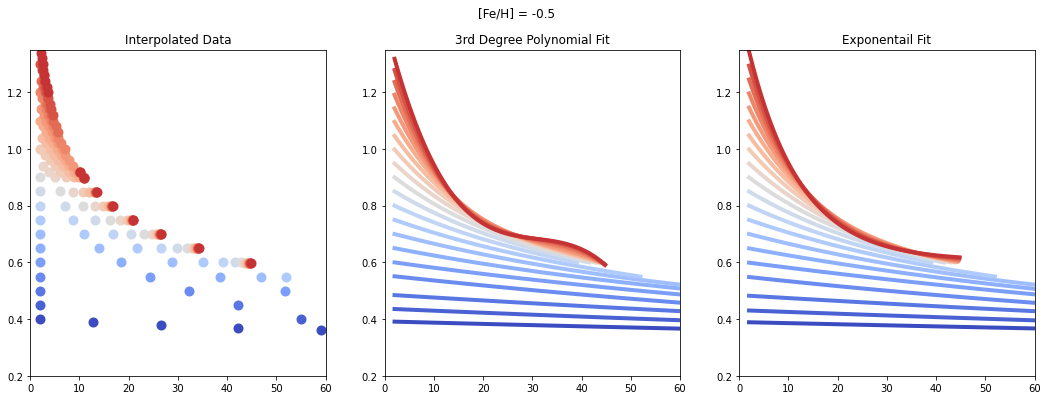

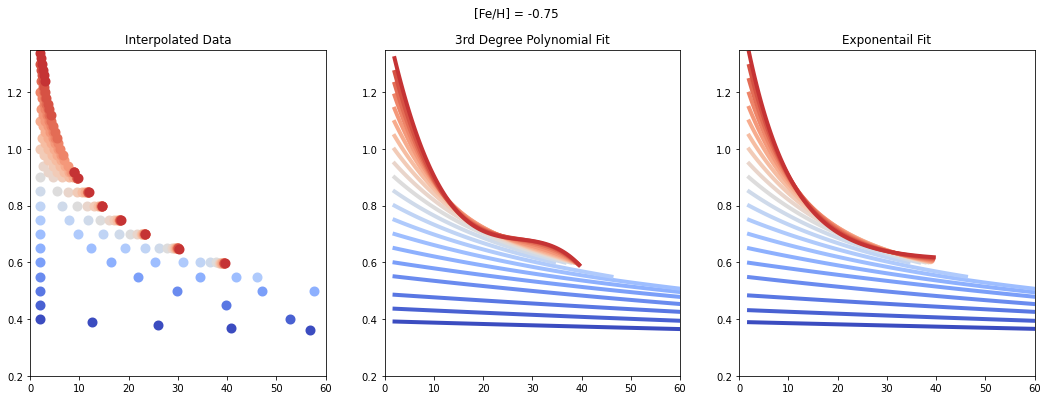

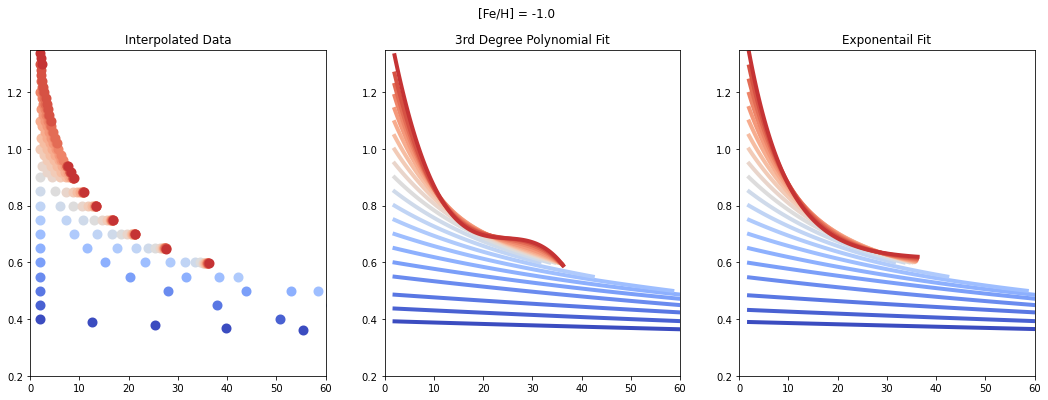

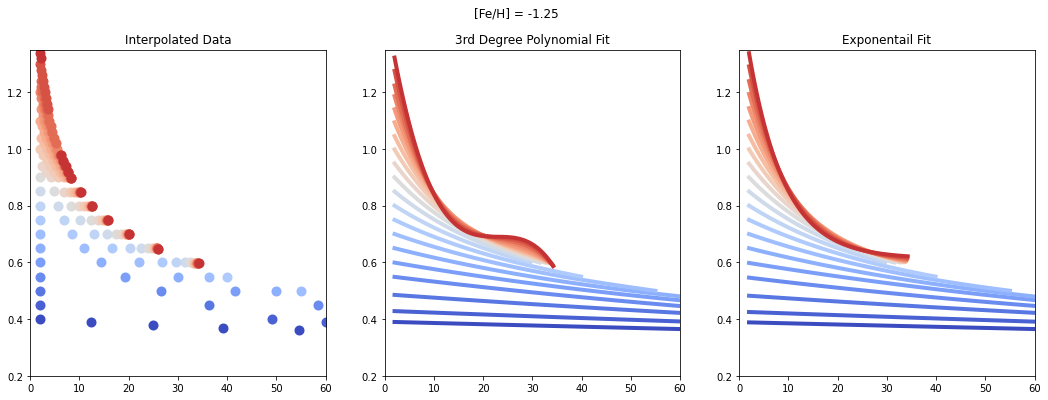

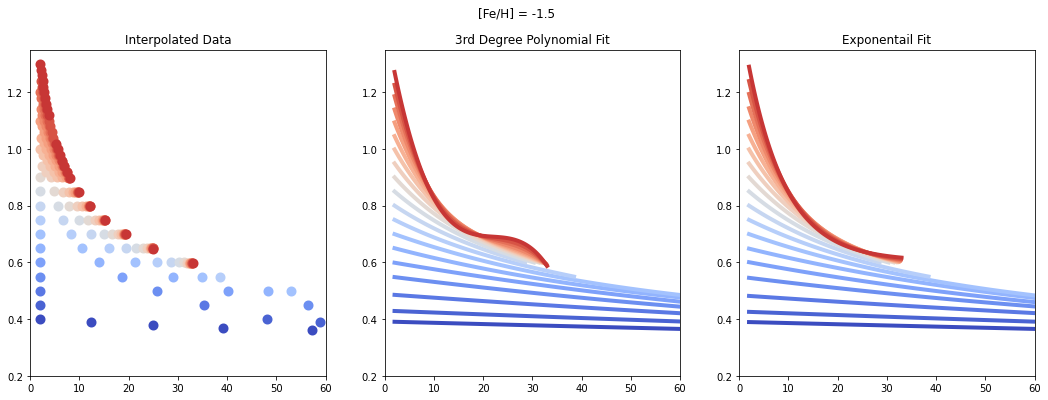

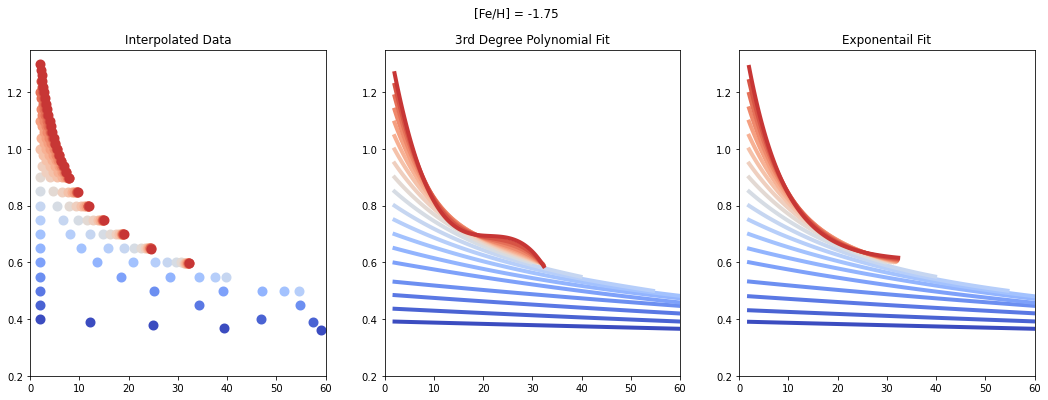

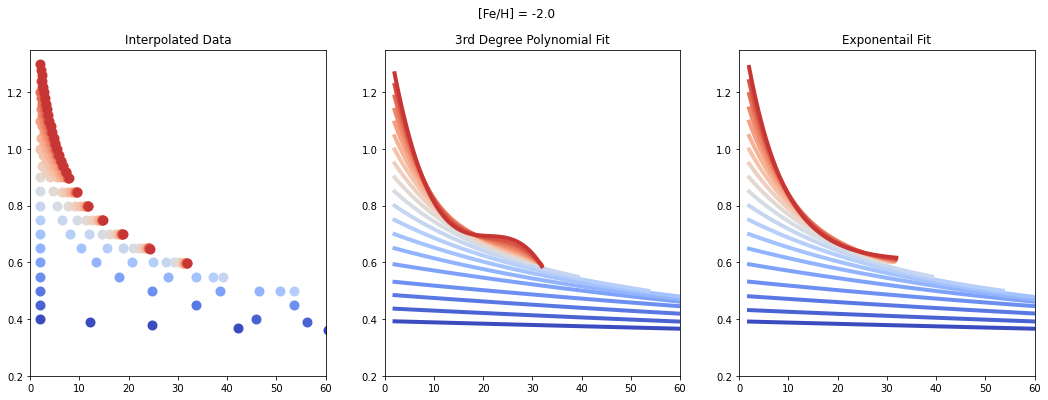

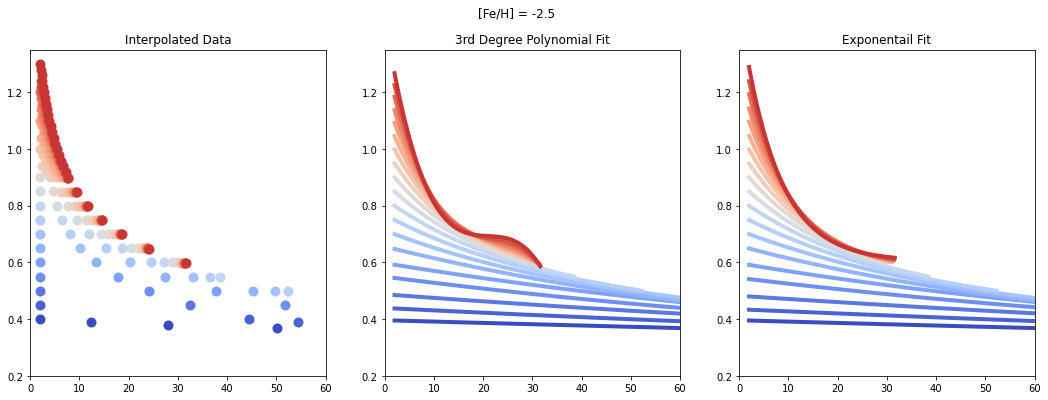

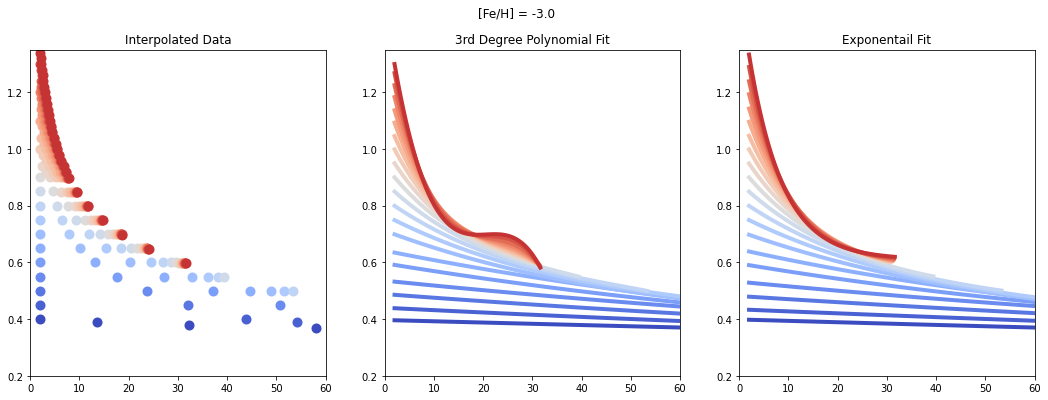

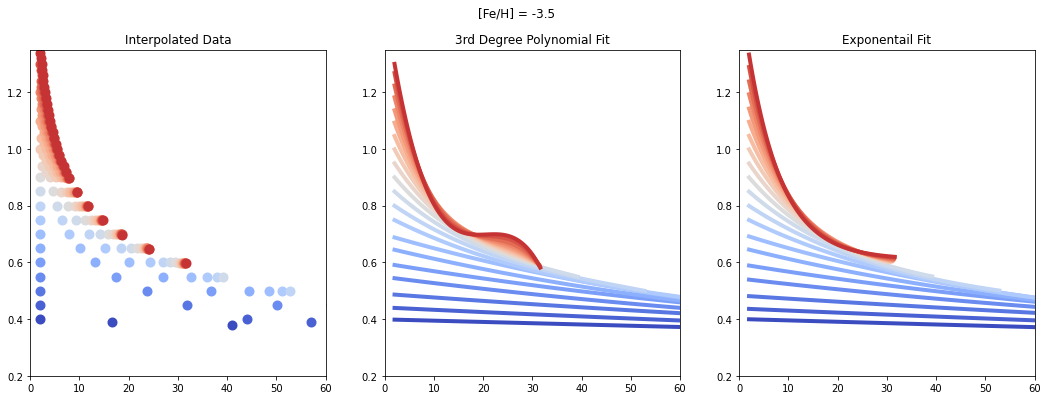

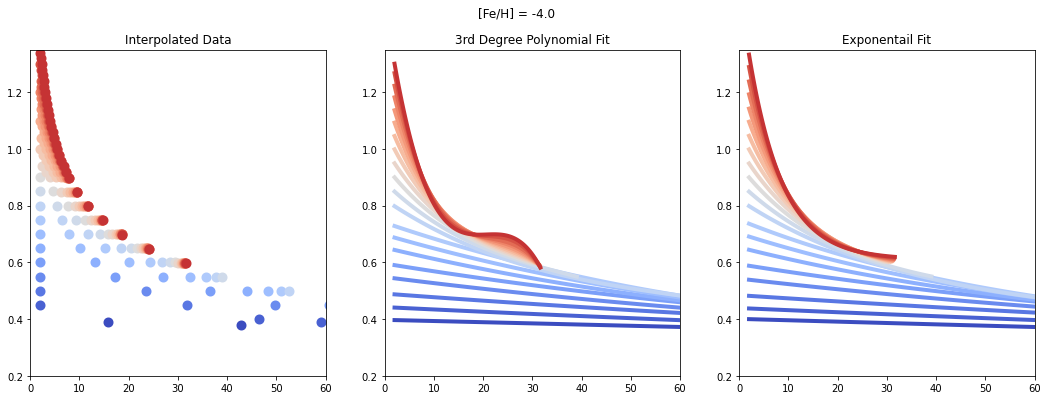

In [12]:
for i in range(len(all_indices)) :
    #if(np.abs(feh[i]+2.5 ) < 0.05):
    fig, axs = plt.subplots(1,3, figsize=(18,6))
    for num,x in enumerate(all_indices[i]):
        pts = np.linspace(a_start, min(60e9,max(all_a[i][num])),120)
        axs[0].scatter(all_a[i][num]/1e9, all_m[i][num], color=CMAP(x/len(all_l_stables[i])), lw=4)
        axs[1].plot(pts/1e9, (np.poly1d(all_poly_fits[i][num]))(pts), color=CMAP(x/len(all_l_stables[i])), lw=4)
        a,b,c = all_exp_fits[i][num]
        axs[2].plot(pts/1e9, exp(pts,a,b,c), color=CMAP(x/len(all_l_stables[i])), lw=4)
    titles = ["Interpolated Data", "3rd Degree Polynomial Fit", "Exponentail Fit"]
    for x in range(3): 
        axs[x].set_xlim(0,60)
        axs[x].set_ylim(m_eval[0]-0.2, m_eval[-1])
        axs[x].set_title(titles[x])

    plt.suptitle("[Fe/H] = "+str(feh[i]))

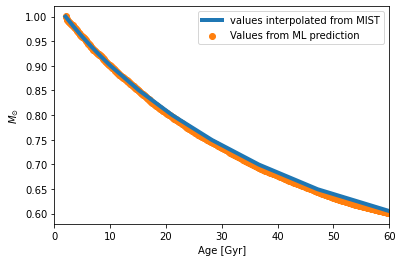

In [96]:
i=np.where(np.abs(np.array(feh)) < 0.01)[0][0]
j=np.argmin(np.abs(np.array(all_l_stables[i])))

pts = np.linspace(a_start,60e9,500)
m_predict,age_in,lum_in,feh_in = calc_ML([0.0],pts,[all_l_stables[i][j]])
solar_ages, solar_masses = all_a[i][j]/1e9, all_m[i][j]

b=ml_bounds()
normalize = matplotlib.colors.Normalize(vmin=b.l_min, vmax=b.l_max)
#plt.scatter(np.array(age)/1e9, m_predict, c=lum, s=5, cmap=CMAP, norm=normalize, label="Values from ML prediction")
plt.scatter(np.array(pts)/1e9, m_predict, c="tab:orange", label="Values from ML prediction")
plt.plot(solar_ages,solar_masses, c="tab:blue", label="values interpolated from MIST", lw=4)
plt.xlabel("Age [Gyr]")
plt.ylabel(r"$M_{\odot}$")
plt.legend()
plt.xlim(0,60)
plt.savefig("figures/ml_vs_mist_for_sun.pdf")